# Tensor Network

In [1]:
import numpy as np
from tqdm import tnrange
import matplotlib.pyplot as plt

import sys
sys.path.insert(0,"../")
import data_generator as gen
import TensorNetwork as tn

from torch.utils.data import DataLoader, Dataset, TensorDataset, SubsetRandomSampler

In [2]:
from importlib import reload

In [3]:
class NumpyDataset(Dataset):
    """
    Add description
    """
    
    def __init__(self, data, label):
        self.data = data
        self.label = label
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return (self.data[index], self.label[index])

In [4]:
def prepare_dataset(data, label, train_perc, val_perc, train_batch_size, val_batch_size, test_batch_size):
    """
    Add description
    """
    
    def psi(x):
        x = np.array((np.sin(np.pi*x/2),np.cos(np.pi*x/2)))
        return np.transpose(x, [1,2,0])


    # flatten images
    x = data.reshape(len(data),-1)
    # embedd them
    x = psi(x)
    
    # training/test splitting
    m = int(len(x)*train_perc)
    x_train= x[:m]
    y_train = label[:m]
    x_test =  x[m:]
    y_test = label[m:]
    
    # define custom NumpyDatasets
    train_set = NumpyDataset(x_train, y_train)
    test_set =  NumpyDataset(x_test, y_test)
   
    train_len = int(m*(1-val_perc))
    train_sampler = SubsetRandomSampler(np.arange(train_len))
    val_sampler = SubsetRandomSampler(np.arange(train_len,m))

    train_loader = DataLoader(train_set, train_batch_size, sampler=train_sampler, drop_last=True, collate_fn=lambda x: x)
    val_loader = DataLoader(train_set, val_batch_size, sampler=val_sampler, drop_last=True, collate_fn=lambda x: x)
    test_loader = DataLoader(test_set, test_batch_size, drop_last=False, collate_fn=lambda x: x)

    return train_loader, val_loader, test_loader

## Example of training

In [225]:
n_samples = 1000
linear_dim = 5
M = 10
B = 32

In [226]:
(data, label) = gen.create_dataset(n_samples, linear_dim=linear_dim, sigma=0.5)
batch_size = {'train_batch_size':B, 'val_batch_size':64, 'test_batch_size':128}
train_loader, val_loader, test_loader = prepare_dataset(data, label, 0.8, 0.2, **batch_size)
print("Number of batches in training set: ", len(train_loader))
print("Number of batches in validation set: ", len(val_loader))
print("Number of batches in test set: ", len(test_loader))

Number of batches in training set:  20
Number of batches in validation set:  2
Number of batches in test set:  2


In [317]:
reload(tn)

<module 'TensorNetwork' from '/home/nicola/Nicola_unipd/QuintoAnno/Quantum Information/TensorNetworkForML/TensorNetwork/TensorNetwork.py'>

In [318]:
calibration_batch = next(iter(train_loader))
x_calibration = np.array([calibration_batch[i][0] for i in range(len(calibration_batch))])

In [319]:
N = linear_dim**2
net = tn.Network(N=N, M=M, L=2, normalize=True, calibration_X=x_calibration, 
                 act_fn='linear', loss_fn='cross_entropy', T=1, L2=1e-2)

Normalizing weights...
Scaling factor: 6.40
Calibrating weights on dataset...
f_max for random input of 32 samples :  1.9535553122391676
Rescaling factor for calibration:  1.0271480085895035
f_max for random input of 32 samples (after):  0.9999999999999988


In [320]:
n_epochs = 2
train_acc, val_acc, B_log, dB_log, acc_log = net.train(train_loader, val_loader, lr = 0.01, n_epochs = n_epochs, print_freq=1)

batch_acc:  0.21875

right sweep step  0
f:  26.896531542160233
activation:  26.896531542160233
Accuracy (before optim.):  0.21875
MAE (before optim.):  0.506319142012889
loss_der:  99.13058529667532
DeltaB (before GC):  569.646568292379
DeltaB (after GC):  46.581368006952495
B: 	 46.5813680069525
Accuracy (after optim.):  0.21875
MAE (after optim.):  0.5055199022127853

right sweep step  1
f:  27.24329186446629
activation:  27.24329186446629
Accuracy (before optim.):  0.21875
MAE (before optim.):  0.5055199022127853
loss_der:  97.58473522623053
DeltaB (before GC):  241.75655594261673
DeltaB (after GC):  20.03521450894245
B: 	 20.035214508942445
Accuracy (after optim.):  0.21875
MAE (after optim.):  0.5055458282123283

right sweep step  2
f:  27.801108418922258
activation:  27.801108418922258
Accuracy (before optim.):  0.21875
MAE (before optim.):  0.5055458282123283
loss_der:  95.55112959727046
DeltaB (before GC):  243.51808018247803
DeltaB (after GC):  22.09494234585054
B: 	 22.09494


left sweep step  18
f:  62.664394552470554
activation:  62.664394552470554
Accuracy (before optim.):  0.96875
MAE (before optim.):  0.6415193179298947
loss_der:  38.061463400390465
deltaB (before GC):  111.94444854483177
deltaB (after GC):  20.080946713103387
B: 	 20.08094671310339
Accuracy (after optim.):  0.96875
MAE (after optim.):  0.6796422090781169

left sweep step  17
f:  66.30381579442574
activation:  66.30381579442574
Accuracy (before optim.):  0.96875
MAE (before optim.):  0.6796422090781169
loss_der:  35.69583481483578
deltaB (before GC):  104.57032682278019
deltaB (after GC):  20.39792939363032
B: 	 20.397929393630317
Accuracy (after optim.):  0.96875
MAE (after optim.):  0.7210408502517005

left sweep step  16
f:  69.96690751976229
activation:  69.96690751976229
Accuracy (before optim.):  0.96875
MAE (before optim.):  0.7210408502517005
loss_der:  33.712750644198664
deltaB (before GC):  112.58330133802909
deltaB (after GC):  20.520465911978185
B: 	 20.520465911978185
Accu

DeltaB (before GC):  121.76493999298023
DeltaB (after GC):  33.946250042586655
B: 	 33.94625004258666
Accuracy (after optim.):  1.0
MAE (after optim.):  4.142430072079968

right sweep step  13
f:  297.115524613118
activation:  297.115524613118
Accuracy (before optim.):  1.0
MAE (before optim.):  4.142430072079968
loss_der:  7.694275018542369
DeltaB (before GC):  121.9660943999042
DeltaB (after GC):  33.29294035734593
B: 	 33.29294035734593
Accuracy (after optim.):  1.0
MAE (after optim.):  4.47467663295599

right sweep step  14
f:  318.3793045091834
activation:  318.3793045091834
Accuracy (before optim.):  1.0
MAE (before optim.):  4.47467663295599
loss_der:  7.216553975945624
DeltaB (before GC):  120.40229713843189
DeltaB (after GC):  33.28335817814183
B: 	 33.28335817814183
Accuracy (after optim.):  1.0
MAE (after optim.):  4.826397796937215

right sweep step  15
f:  340.88945900398176
activation:  340.88945900398176
Accuracy (before optim.):  1.0
MAE (before optim.):  4.826397796937


left sweep step  4
f:  2784.7123550362517
activation:  2784.7123550362517
Accuracy (before optim.):  1.0
MAE (before optim.):  43.01113054744143
loss_der:  0.7703478507892174
deltaB (before GC):  73.50081404284298
deltaB (after GC):  38.776527539484015
B: 	 38.77652753948401
Accuracy (after optim.):  1.0
MAE (after optim.):  45.947043806419494

left sweep step  3
f:  2972.6108036108476
activation:  2972.6108036108476
Accuracy (before optim.):  1.0
MAE (before optim.):  45.947043806419494
loss_der:  0.7186183199017835
deltaB (before GC):  74.34238275803114
deltaB (after GC):  31.40375769932253
B: 	 31.403757699322526
Accuracy (after optim.):  1.0
MAE (after optim.):  48.56513310861274

left sweep step  2
f:  3140.1685189512154
activation:  3140.1685189512154
Accuracy (before optim.):  1.0
MAE (before optim.):  48.56513310861274
loss_der:  0.6835818283916348
deltaB (before GC):  70.11373066744889
deltaB (after GC):  24.89729628386045
B: 	 24.897296283860456
Accuracy (after optim.):  1.0


left sweep step  22
f:  19946.830554989006
activation:  19946.830554989006
Accuracy (before optim.):  1.0
MAE (before optim.):  311.1692274217032
loss_der:  0.09829248310026947
deltaB (before GC):  77.66789257603315
deltaB (after GC):  21.551993927368116
B: 	 21.551993927368116
Accuracy (after optim.):  1.0
MAE (after optim.):  324.8093992582154

left sweep step  21
f:  20819.801552525787
activation:  20819.801552525787
Accuracy (before optim.):  1.0
MAE (before optim.):  324.8093992582154
loss_der:  0.0945537599108113
deltaB (before GC):  77.13377238530728
deltaB (after GC):  34.90181522639066
B: 	 34.90181522639067
Accuracy (after optim.):  1.0
MAE (after optim.):  346.3420255163941

left sweep step  20
f:  22197.88963304922
activation:  22197.88963304922
Accuracy (before optim.):  1.0
MAE (before optim.):  346.3420255163941
loss_der:  0.08792380562316578
deltaB (before GC):  72.79902186397801
deltaB (after GC):  47.009823079339256
B: 	 47.009823079339256
Accuracy (after optim.):  1

Accuracy (after optim.):  1.0
MAE (after optim.):  2181.1259300422075

right sweep step  4
f:  139624.05952270128
activation:  139624.05952270128
Accuracy (before optim.):  1.0
MAE (before optim.):  2181.1259300422075
loss_der:  0.015679347222771353
DeltaB (before GC):  62.59949901545508
DeltaB (after GC):  54.820048640632045
B: 	 54.820048640632045
Accuracy (after optim.):  1.0
MAE (after optim.):  2359.8147590954654

right sweep step  5
f:  151060.1445821098
activation:  151060.1445821098
Accuracy (before optim.):  1.0
MAE (before optim.):  2359.8147590954654
loss_der:  0.014464173198141547
DeltaB (before GC):  58.486506712170254
DeltaB (after GC):  58.486506712170254
B: 	 62.612490177055946
Accuracy (after optim.):  1.0
MAE (after optim.):  2563.042349551749

right sweep step  6
f:  164066.71037131193
activation:  164066.71037131193
Accuracy (before optim.):  1.0
MAE (before optim.):  2563.042349551749
loss_der:  0.0132398768503633
DeltaB (before GC):  61.37619912333275
DeltaB (afte

f:  959605.8802835353
activation:  959605.8802835353
Accuracy (before optim.):  0.6875
MAE (before optim.):  14993.34187943024
loss_der:  0.0022173459845064507
deltaB (before GC):  56.896511459470005
deltaB (after GC):  56.896511459470005
B: 	 77.81500888805925
Accuracy (after optim.):  0.6875
MAE (after optim.):  15863.684731193585

left sweep step  12
f:  1015307.8227963895
activation:  1015307.8227963895
Accuracy (before optim.):  0.6875
MAE (before optim.):  15863.684731193585
loss_der:  0.002108211053144303
deltaB (before GC):  57.43667528222141
deltaB (after GC):  57.43667528222141
B: 	 76.22060164705081
Accuracy (after optim.):  0.6875
MAE (after optim.):  16784.277794091504

left sweep step  11
f:  1074225.7788218562
activation:  1074225.7788218562
Accuracy (before optim.):  0.65625
MAE (before optim.):  16784.277794091504
loss_der:  0.002001786158398392
deltaB (before GC):  58.901439467269896
deltaB (after GC):  58.901439467269896
B: 	 74.71920701797436
Accuracy (after optim.)

activation:  3084814.6312900637
Accuracy (before optim.):  1.0
MAE (before optim.):  48199.728613907246
loss_der:  0.0006350589242795687
DeltaB (before GC):  57.25891167796746
DeltaB (after GC):  57.25891167796746
B: 	 86.09340702404141
Accuracy (after optim.):  1.0
MAE (after optim.):  50524.49749287846

right sweep step  17
f:  3233599.8395442213
activation:  3233599.8395442213
Accuracy (before optim.):  1.0
MAE (before optim.):  50524.49749287846
loss_der:  0.0006044241805303332
DeltaB (before GC):  52.358899645669865
DeltaB (after GC):  52.358899645669865
B: 	 81.87805359957358
Accuracy (after optim.):  1.0
MAE (after optim.):  53006.90306993733

right sweep step  18
f:  3392473.7964759893
activation:  3392473.7964759893
Accuracy (before optim.):  1.0
MAE (before optim.):  53006.90306993733
loss_der:  0.0005752156588887039
DeltaB (before GC):  50.388698751682625
DeltaB (after GC):  50.388698751682625
B: 	 78.77616143687982
Accuracy (after optim.):  1.0
MAE (after optim.):  55670.23

Accuracy (after optim.):  1.0
MAE (after optim.):  180251.6649674064

left sweep step  2
f:  11536138.55791401
activation:  11536138.55791401
Accuracy (before optim.):  1.0
MAE (before optim.):  180251.6649674064
loss_der:  0.0001670631574477484
deltaB (before GC):  34.816613553177326
deltaB (after GC):  34.816613553177326
B: 	 37.319902041883296
Accuracy (after optim.):  1.0
MAE (after optim.):  185806.1718336462

left sweep step  1
f:  11891626.997353356
activation:  11891626.997353356
Accuracy (before optim.):  1.0
MAE (before optim.):  185806.1718336462
loss_der:  0.00016241832845668733
deltaB (before GC):  71.49727539644873
deltaB (after GC):  71.49727539644873
B: 	 101.73557103162294
Accuracy (after optim.):  1.0
MAE (after optim.):  189421.8868021652
Output values before normalization:
 [[ 81882.65451832 221468.58403947 185924.87294742 181904.46057818
  309862.54832305 220204.16791887 150986.25320644 203462.54085775
  140337.11391605 191082.18712255 162202.33627508 239843.229256

deltaB (before GC):  37.780413284420725
deltaB (after GC):  33.33473568171805
B: 	 33.33473568171806
Accuracy (after optim.):  1.0
MAE (after optim.):  598937.9648402698

left sweep step  22
f:  38332061.749777265
activation:  38332061.749777265
Accuracy (before optim.):  1.0
MAE (before optim.):  598937.9648402698
loss_der:  5.1460955090385427e-05
deltaB (before GC):  44.68177418428695
deltaB (after GC):  44.58704971909131
B: 	 44.587049719091326
Accuracy (after optim.):  1.0
MAE (after optim.):  622706.4797777074

left sweep step  21
f:  39853246.70577327
activation:  39853246.70577327
Accuracy (before optim.):  1.0
MAE (before optim.):  622706.4797777074
loss_der:  4.964004000166956e-05
deltaB (before GC):  48.26197487192909
deltaB (after GC):  48.26197487192909
B: 	 68.72679251829976
Accuracy (after optim.):  1.0
MAE (after optim.):  652030.6613776344

left sweep step  20
f:  41729994.3281686
activation:  41729994.3281686
Accuracy (before optim.):  1.0
MAE (before optim.):  652030.

DeltaB (before GC):  56.41239421643505
DeltaB (after GC):  56.41239421643505
B: 	 121.99794626845437
Accuracy (after optim.):  1.0
MAE (after optim.):  1674379.0360609996

right sweep step  8
f:  107160290.30790398
activation:  107160290.30790398
Accuracy (before optim.):  1.0
MAE (before optim.):  1674379.0360609996
loss_der:  1.7984704287343806e-05
DeltaB (before GC):  59.75375490499319
DeltaB (after GC):  59.75375490499319
B: 	 128.78472059780697
Accuracy (after optim.):  1.0
MAE (after optim.):  1741198.413333398

right sweep step  9
f:  111436730.45333748
activation:  111436730.45333748
Accuracy (before optim.):  1.0
MAE (before optim.):  1741198.413333398
loss_der:  1.7223175728545513e-05
DeltaB (before GC):  61.38879063074866
DeltaB (after GC):  61.38879063074866
B: 	 127.92779150964728
Accuracy (after optim.):  1.0
MAE (after optim.):  1810005.5424653902

right sweep step  10
f:  115840386.71778497
activation:  115840386.71778497
Accuracy (before optim.):  1.0
MAE (before optim

deltaB (before GC):  62.135862134631175
deltaB (after GC):  62.135862134631175
B: 	 132.91693176120793
Accuracy (after optim.):  1.0
MAE (after optim.):  4137051.110748655

left sweep step  12
f:  264771303.08791393
activation:  264771303.08791393
Accuracy (before optim.):  1.0
MAE (before optim.):  4137051.110748655
loss_der:  7.288591917952233e-06
deltaB (before GC):  64.3802704620671
deltaB (after GC):  64.3802704620671
B: 	 131.83090170917683
Accuracy (after optim.):  1.0
MAE (after optim.):  4275850.009640617

left sweep step  11
f:  273654432.6169995
activation:  273654432.6169995
Accuracy (before optim.):  1.0
MAE (before optim.):  4275850.009640617
loss_der:  7.074681364857089e-06
deltaB (before GC):  63.133084882492646
deltaB (after GC):  63.133084882492646
B: 	 133.29233537400262
Accuracy (after optim.):  1.0
MAE (after optim.):  4419862.29867693

left sweep step  10
f:  282871219.11532354
activation:  282871219.11532354
Accuracy (before optim.):  1.0
MAE (before optim.):  44

Accuracy (after optim.):  1.0
MAE (after optim.):  8578402.821569413

right sweep step  18
f:  549017812.5804424
activation:  549017812.5804424
Accuracy (before optim.):  1.0
MAE (before optim.):  8578402.821569413
loss_der:  3.6152810405268513e-06
DeltaB (before GC):  43.85341373950832
DeltaB (after GC):  43.85341373950832
B: 	 126.77409763471222
Accuracy (after optim.):  1.0
MAE (after optim.):  8818765.542068217

right sweep step  19
f:  564401026.6923659
activation:  564401026.6923659
Accuracy (before optim.):  1.0
MAE (before optim.):  8818765.542068217
loss_der:  3.496422672374725e-06
DeltaB (before GC):  39.23352912217757
DeltaB (after GC):  39.23352912217757
B: 	 114.45840976277653
Accuracy (after optim.):  1.0
MAE (after optim.):  9047026.884652773

right sweep step  20
f:  579009752.6177775
activation:  579009752.6177775
Accuracy (before optim.):  1.0
MAE (before optim.):  9047026.884652773
loss_der:  3.4023453612113577e-06
DeltaB (before GC):  38.76838455182991
DeltaB (after

DeltaB (before GC):  24.060685950220048
DeltaB (after GC):  24.060685950220048
B: 	 50.73211364999598
Accuracy (after optim.):  1.0
MAE (after optim.):  20208821.449518293

right sweep step  2
f:  1293364604.7691708
activation:  1293364604.7691708
Accuracy (before optim.):  1.0
MAE (before optim.):  20208821.449518293
loss_der:  1.5610595242778297e-06
DeltaB (before GC):  31.36593200289502
DeltaB (after GC):  31.36593200289502
B: 	 56.208052262137016
Accuracy (after optim.):  1.0
MAE (after optim.):  20572524.607931167

right sweep step  3
f:  1316641606.9075947
activation:  1316641606.9075947
Accuracy (before optim.):  1.0
MAE (before optim.):  20572524.607931167
loss_der:  1.5356636753401003e-06
DeltaB (before GC):  40.37063234162534
DeltaB (after GC):  40.37063234162534
B: 	 88.60884295546234
Accuracy (after optim.):  1.0
MAE (after optim.):  21075764.46994666

right sweep step  4
f:  1348848958.0765862
activation:  1348848958.0765862
Accuracy (before optim.):  1.0
MAE (before optim

f:  3126947409.514356
activation:  3126947409.514356
Accuracy (before optim.):  1.0
MAE (before optim.):  48858552.773661815
loss_der:  6.478370115710032e-07
deltaB (before GC):  62.15496610534093
deltaB (after GC):  62.15496610534093
B: 	 174.96042547792666
Accuracy (after optim.):  1.0
MAE (after optim.):  50392754.59089493

left sweep step  12
f:  3225136325.8172755
activation:  3225136325.8172755
Accuracy (before optim.):  1.0
MAE (before optim.):  50392754.59089493
loss_der:  6.298576771757287e-07
deltaB (before GC):  62.6782384944358
deltaB (after GC):  62.6782384944358
B: 	 179.08796255042952
Accuracy (after optim.):  1.0
MAE (after optim.):  51928139.68823457

left sweep step  11
f:  3323400972.0470123
activation:  3323400972.0470123
Accuracy (before optim.):  1.0
MAE (before optim.):  51928139.68823457
loss_der:  6.131279905230331e-07
deltaB (before GC):  62.64939950002413
deltaB (after GC):  62.64939950002413
B: 	 182.84493016995233
Accuracy (after optim.):  1.0
MAE (after op

f:  5333811451.490433
activation:  5333811451.490433
Accuracy (before optim.):  1.0
MAE (before optim.):  83340803.42953801
loss_der:  3.6648715176000654e-07
DeltaB (before GC):  58.26627736242575
DeltaB (after GC):  58.26627736242575
B: 	 185.36859226979325
Accuracy (after optim.):  1.0
MAE (after optim.):  85653956.53633286

right sweep step  15
f:  5481853250.325303
activation:  5481853250.325303
Accuracy (before optim.):  1.0
MAE (before optim.):  85653956.53633286
loss_der:  3.57470730526459e-07
DeltaB (before GC):  57.31763175801356
DeltaB (after GC):  57.31763175801356
B: 	 195.56397606480772
Accuracy (after optim.):  1.0
MAE (after optim.):  87958835.53338668

right sweep step  16
f:  5629365506.136747
activation:  5629365506.136747
Accuracy (before optim.):  1.0
MAE (before optim.):  87958835.53338668
loss_der:  3.4741061215819e-07
DeltaB (before GC):  51.783877650651334
DeltaB (after GC):  51.783877650651334
B: 	 193.75580598539685
Accuracy (after optim.):  1.0
MAE (after opt

deltaB (before GC):  30.924402408498022
deltaB (after GC):  30.924402408498022
B: 	 119.71017841299556
Accuracy (after optim.):  1.0
MAE (after optim.):  164572703.2721306

left sweep step  3
f:  10532653041.416359
activation:  10532653041.416359
Accuracy (before optim.):  1.0
MAE (before optim.):  164572703.2721306
loss_der:  1.846889646262464e-07
deltaB (before GC):  22.975063574949953
deltaB (after GC):  22.975063574949953
B: 	 82.88311893171422
Accuracy (after optim.):  1.0
MAE (after optim.):  166116665.51945347

left sweep step  2
f:  10631466625.245022
activation:  10631466625.245022
Accuracy (before optim.):  1.0
MAE (before optim.):  166116665.51945347
loss_der:  1.831325562519919e-07
deltaB (before GC):  17.216202281281802
deltaB (after GC):  17.216202281281802
B: 	 71.48499557488299
Accuracy (after optim.):  1.0
MAE (after optim.):  167214684.91554773

left sweep step  1
f:  10701739866.595055
activation:  10701739866.595055
Accuracy (before optim.):  1.0
MAE (before optim.)

Accuracy (after optim.):  0.8125
MAE (after optim.):  295187342.5804391

left sweep step  24
f:  18891989957.1481
activation:  18891989957.1481
Accuracy (before optim.):  0.8125
MAE (before optim.):  295187342.5804391
loss_der:  1.055511272511429e-07
deltaB (before GC):  36.02383743655167
deltaB (after GC):  36.02383743655167
B: 	 187.5006698197007
Accuracy (after optim.):  0.8125
MAE (after optim.):  296222257.7880546

left sweep step  23
f:  18958224530.435493
activation:  18958224530.435493
Accuracy (before optim.):  0.8125
MAE (before optim.):  296222257.7880546
loss_der:  1.0510316015574704e-07
deltaB (before GC):  20.81128559380919
deltaB (after GC):  20.81128559380919
B: 	 57.71459803809577
Accuracy (after optim.):  0.8125
MAE (after optim.):  298336911.51642287

left sweep step  22
f:  19093562369.051064
activation:  19093562369.051064
Accuracy (before optim.):  0.8125
MAE (before optim.):  298336911.51642287
loss_der:  1.0437019751516682e-07
deltaB (before GC):  28.90820040575

B: 	 105.60510105410283
Accuracy (after optim.):  0.625
MAE (after optim.):  436157534.2523495

right sweep step  4
f:  27914082224.150368
activation:  27914082224.150368
Accuracy (before optim.):  0.625
MAE (before optim.):  436157534.2523495
loss_der:  7.577920886948731e-08
DeltaB (before GC):  41.42060194525253
DeltaB (after GC):  41.42060194525253
B: 	 136.46178365513066
Accuracy (after optim.):  0.65625
MAE (after optim.):  445048281.61744606

right sweep step  5
f:  28483090055.51655
activation:  28483090055.51655
Accuracy (before optim.):  0.65625
MAE (before optim.):  445048281.61744606
loss_der:  7.397012013446095e-08
DeltaB (before GC):  48.60924886487359
DeltaB (after GC):  48.60924886487359
B: 	 168.60646456567247
Accuracy (after optim.):  0.6875
MAE (after optim.):  456616678.2573736

right sweep step  6
f:  29223467440.47191
activation:  29223467440.47191
Accuracy (before optim.):  0.6875
MAE (before optim.):  456616678.2573736
loss_der:  7.164181605042019e-08
DeltaB (bef

deltaB (before GC):  70.19049998102545
deltaB (after GC):  70.19049998102545
B: 	 212.1685616012387
Accuracy (after optim.):  1.0
MAE (after optim.):  833825427.0015128

left sweep step  13
f:  53364827360.09682
activation:  53364827360.09682
Accuracy (before optim.):  1.0
MAE (before optim.):  833825427.0015128
loss_der:  3.78524058152987e-08
deltaB (before GC):  71.2026193769278
deltaB (after GC):  71.2026193769278
B: 	 207.350490604593
Accuracy (after optim.):  1.0
MAE (after optim.):  856665391.3785839

left sweep step  12
f:  54826585080.22937
activation:  54826585080.22937
Accuracy (before optim.):  1.0
MAE (before optim.):  856665391.3785839
loss_der:  3.694035606058567e-08
deltaB (before GC):  70.29559333815737
deltaB (after GC):  70.29559333815737
B: 	 206.9129048635312
Accuracy (after optim.):  1.0
MAE (after optim.):  879622574.0543692

left sweep step  11
f:  56295844771.47963
activation:  56295844771.47963
Accuracy (before optim.):  1.0
MAE (before optim.):  879622574.0543

Accuracy (after optim.):  0.84375
MAE (after optim.):  1625651993.7386215

right sweep step  17
f:  104041727631.27177
activation:  104041727631.27177
Accuracy (before optim.):  0.84375
MAE (before optim.):  1625651993.7386215
loss_der:  1.8659894325331275e-08
DeltaB (before GC):  44.494748791212224
DeltaB (after GC):  44.494748791212224
B: 	 225.496995349449
Accuracy (after optim.):  0.8125
MAE (after optim.):  1658613302.9983268

right sweep step  18
f:  106151251423.89291
activation:  106151251423.89291
Accuracy (before optim.):  0.8125
MAE (before optim.):  1658613302.9983268
loss_der:  1.8253230231860203e-08
DeltaB (before GC):  42.48787684207017
DeltaB (after GC):  42.48787684207017
B: 	 206.23356044250022
Accuracy (after optim.):  0.78125
MAE (after optim.):  1686508242.261926

right sweep step  19
f:  107936527536.76326
activation:  107936527536.76326
Accuracy (before optim.):  0.78125
MAE (before optim.):  1686508242.261926
loss_der:  1.7905665078477216e-08
DeltaB (before GC):

DeltaB (before GC):  26.661388758681973
DeltaB (after GC):  26.661388758681973
B: 	 224.46337446633743
Accuracy (after optim.):  0.75
MAE (after optim.):  2636655267.6098847

right sweep step  1
f:  168745937159.03262
activation:  168745937159.03262
Accuracy (before optim.):  0.75
MAE (before optim.):  2636655267.6098847
loss_der:  1.1949175966784897e-08
DeltaB (before GC):  14.742929742838282
DeltaB (after GC):  14.742929742838282
B: 	 71.54936413274662
Accuracy (after optim.):  0.75
MAE (after optim.):  2646620751.3940415

right sweep step  2
f:  169383728121.21866
activation:  169383728121.21866
Accuracy (before optim.):  0.75
MAE (before optim.):  2646620751.3940415
loss_der:  1.1903915333584287e-08
DeltaB (before GC):  20.37854370768374
DeltaB (after GC):  20.37854370768374
B: 	 79.52932540303672
Accuracy (after optim.):  0.75
MAE (after optim.):  2662681827.8453765

right sweep step  3
f:  170411637014.1041
activation:  170411637014.1041
Accuracy (before optim.):  0.75
MAE (befor


left sweep step  15
f:  276925605595.1638
activation:  276925605595.1638
Accuracy (before optim.):  0.75
MAE (before optim.):  4326962586.924435
loss_der:  7.2411798863161476e-09
deltaB (before GC):  58.94075105229954
deltaB (after GC):  58.94075105229954
B: 	 244.00427499977732
Accuracy (after optim.):  0.75
MAE (after optim.):  4436101376.738516

left sweep step  14
f:  283910488143.265
activation:  283910488143.265
Accuracy (before optim.):  0.75
MAE (before optim.):  4436101376.738516
loss_der:  7.087568028526897e-09
deltaB (before GC):  63.82073853823574
deltaB (after GC):  63.82073853823574
B: 	 247.2525216157244
Accuracy (after optim.):  0.75
MAE (after optim.):  4544700934.59908

left sweep step  13
f:  290860859846.3411
activation:  290860859846.3411
Accuracy (before optim.):  0.75
MAE (before optim.):  4544700934.59908
loss_der:  6.930292215631447e-09
deltaB (before GC):  67.72248583324823
deltaB (after GC):  67.72248583324823
B: 	 249.64077410341469
Accuracy (after optim.):

DeltaB (before GC):  72.73100761750266
DeltaB (after GC):  72.73100761750266
B: 	 240.6126621945422
Accuracy (after optim.):  0.46875
MAE (after optim.):  7138014444.398125

right sweep step  14
f:  456832924473.48
activation:  456832924473.48
Accuracy (before optim.):  0.46875
MAE (before optim.):  7138014444.398125
loss_der:  4.722310768114314e-09
DeltaB (before GC):  65.27570817807826
DeltaB (after GC):  65.27570817807826
B: 	 240.83597000661868
Accuracy (after optim.):  0.46875
MAE (after optim.):  7297557046.079988

right sweep step  15
f:  467043650981.1192
activation:  467043650981.1192
Accuracy (before optim.):  0.46875
MAE (before optim.):  7297557046.079988
loss_der:  4.6092380296339116e-09
DeltaB (before GC):  56.197733373155714
DeltaB (after GC):  56.197733373155714
B: 	 253.33901656599593
Accuracy (after optim.):  0.625
MAE (after optim.):  7451616116.61998

right sweep step  16
f:  476903431495.6787
activation:  476903431495.6787
Accuracy (before optim.):  0.625
MAE (befo

Accuracy (after optim.):  1.0
MAE (after optim.):  10916722497.79683

left sweep step  5
f:  698670239890.9971
activation:  698670239890.9971
Accuracy (before optim.):  1.0
MAE (before optim.):  10916722497.79683
loss_der:  2.9454096031853455e-09
deltaB (before GC):  25.72804397934532
deltaB (after GC):  25.72804397934532
B: 	 171.8832040802647
Accuracy (after optim.):  1.0
MAE (after optim.):  11020212644.071346

left sweep step  4
f:  705293609252.5662
activation:  705293609252.5662
Accuracy (before optim.):  1.0
MAE (before optim.):  11020212644.071346
loss_der:  2.9153564486915767e-09
deltaB (before GC):  19.602095534888917
deltaB (after GC):  19.602095534888917
B: 	 147.2111738080897
Accuracy (after optim.):  1.0
MAE (after optim.):  11089522254.088043

left sweep step  3
f:  709729424293.6348
activation:  709729424293.6348
Accuracy (before optim.):  1.0
MAE (before optim.):  11089522254.088043
loss_der:  2.89511987287188e-09
deltaB (before GC):  13.603240663704916
deltaB (after G

Accuracy (after optim.):  1.0
MAE (after optim.):  14536161272.647882

right sweep step  23
f:  930314321481.4645
activation:  930314321481.4645
Accuracy (before optim.):  1.0
MAE (before optim.):  14536161272.647882
loss_der:  2.1236473698746187e-09
DeltaB (before GC):  20.79914846367981
DeltaB (after GC):  20.79914846367981
B: 	 316.395657648949
Accuracy (after optim.):  1.0
MAE (after optim.):  14554736451.748772

left sweep step  24
f:  931503132943.9214
activation:  931503132943.9214
Accuracy (before optim.):  1.0
MAE (before optim.):  14554736451.748772
loss_der:  2.1207230213450766e-09
deltaB (before GC):  20.761948358822345
deltaB (after GC):  20.761948358822345
B: 	 316.13860645600374
Accuracy (after optim.):  1.0
MAE (after optim.):  14573191003.82289

left sweep step  23
f:  932684224276.6649
activation:  932684224276.6649
Accuracy (before optim.):  1.0
MAE (before optim.):  14573191003.82289
loss_der:  2.1178166877687874e-09
deltaB (before GC):  12.682430284512735
deltaB (a

DeltaB (before GC):  16.35838454839364
DeltaB (after GC):  16.35838454839364
B: 	 360.0428910037689
Accuracy (after optim.):  0.6875
MAE (after optim.):  21997996503.52717

right sweep step  1
f:  1407871776257.7388
activation:  1407871776257.7388
Accuracy (before optim.):  0.6875
MAE (before optim.):  21997996503.52717
loss_der:  1.5278314781682452e-09
DeltaB (before GC):  9.18952199712049
DeltaB (after GC):  9.18952199712049
B: 	 101.77106804919755
Accuracy (after optim.):  0.71875
MAE (after optim.):  22047936682.60868

right sweep step  2
f:  1411067947718.9556
activation:  1411067947718.9556
Accuracy (before optim.):  0.71875
MAE (before optim.):  22047936682.60868
loss_der:  1.524395311544057e-09
DeltaB (before GC):  12.913780879442797
DeltaB (after GC):  12.913780879442797
B: 	 101.29769436388209
Accuracy (after optim.):  0.71875
MAE (after optim.):  22127901384.491657

right sweep step  3
f:  1416185688639.466
activation:  1416185688639.466
Accuracy (before optim.):  0.71875
MA

Accuracy (before optim.):  1.0
MAE (before optim.):  30774587875.39125
loss_der:  1.082939107689726e-09
deltaB (before GC):  39.14001544478074
deltaB (after GC):  39.14001544478074
B: 	 184.98970338645813
Accuracy (after optim.):  1.0
MAE (after optim.):  31193299646.784096

left sweep step  18
f:  1996371177426.1821
activation:  1996371177426.1821
Accuracy (before optim.):  1.0
MAE (before optim.):  31193299646.784096
loss_der:  1.067298548715828e-09
deltaB (before GC):  44.01977154769396
deltaB (after GC):  44.01977154769396
B: 	 212.23420775717912
Accuracy (after optim.):  1.0
MAE (after optim.):  31763695907.826027

left sweep step  17
f:  2032876538132.8657
activation:  2032876538132.8657
Accuracy (before optim.):  1.0
MAE (before optim.):  31763695907.826027
loss_der:  1.0459197467392788e-09
deltaB (before GC):  46.88368274978582
deltaB (after GC):  46.88368274978582
B: 	 242.15906713427538
Accuracy (after optim.):  1.0
MAE (after optim.):  32463550440.89234

left sweep step  16


Accuracy (after optim.):  1.0
MAE (after optim.):  41893530719.24933

right sweep step  10
f:  2681185966063.957
activation:  2681185966063.957
Accuracy (before optim.):  1.0
MAE (before optim.):  41893530719.24933
loss_der:  7.43370006630837e-10
DeltaB (before GC):  52.671529493070125
DeltaB (after GC):  52.671529493070125
B: 	 253.76229907307055
Accuracy (after optim.):  1.0
MAE (after optim.):  42778661287.89003

right sweep step  11
f:  2737834322456.962
activation:  2737834322456.962
Accuracy (before optim.):  1.0
MAE (before optim.):  42778661287.89003
loss_der:  7.293427960531336e-10
DeltaB (before GC):  50.93323516108901
DeltaB (after GC):  50.93323516108901
B: 	 250.94385578480276
Accuracy (after optim.):  1.0
MAE (after optim.):  43660246716.47032

right sweep step  12
f:  2794255789886.1006
activation:  2794255789886.1006
Accuracy (before optim.):  1.0
MAE (before optim.):  43660246716.47032
loss_der:  7.15740612354482e-10
DeltaB (before GC):  47.7302208651443
DeltaB (after 

f:  3731697990105.3125
activation:  3731697990105.3125
Accuracy (before optim.):  1.0
MAE (before optim.):  58307781094.89551
loss_der:  5.346410959676137e-10
deltaB (before GC):  52.182025564787374
deltaB (after GC):  52.182025564787374
B: 	 273.7190572484441
Accuracy (after optim.):  1.0
MAE (after optim.):  59561133245.19418

left sweep step  10
f:  3811912527724.4277
activation:  3811912527724.4277
Accuracy (before optim.):  1.0
MAE (before optim.):  59561133245.19418
loss_der:  5.243091360549843e-10
deltaB (before GC):  49.49431266372302
deltaB (after GC):  49.49431266372302
B: 	 273.493573458411
Accuracy (after optim.):  1.0
MAE (after optim.):  60787300099.74048

left sweep step  9
f:  3890387206415.3906
activation:  3890387206415.3906
Accuracy (before optim.):  1.0
MAE (before optim.):  60787300099.74048
loss_der:  5.145526207402475e-10
deltaB (before GC):  45.990745153719196
deltaB (after GC):  45.990745153719196
B: 	 288.5422052007667
Accuracy (after optim.):  1.0
MAE (after 


right sweep step  18
f:  5417177509828.98
activation:  5417177509828.98
Accuracy (before optim.):  1.0
MAE (before optim.):  84643398590.57782
loss_der:  3.8045869733142027e-10
DeltaB (before GC):  33.37676281426741
DeltaB (after GC):  33.37676281426741
B: 	 206.47396849620483
Accuracy (after optim.):  1.0
MAE (after optim.):  85345727446.74904

right sweep step  19
f:  5462126556623.938
activation:  5462126556623.938
Accuracy (before optim.):  1.0
MAE (before optim.):  85345727446.74904
loss_der:  3.769845506901454e-10
DeltaB (before GC):  25.528559991460913
DeltaB (after GC):  25.528559991460913
B: 	 172.40551510167504
Accuracy (after optim.):  1.0
MAE (after optim.):  85818419343.4479

right sweep step  20
f:  5492378838012.666
activation:  5492378838012.666
Accuracy (before optim.):  1.0
MAE (before optim.):  85818419343.4479
loss_der:  3.745982966052583e-10
DeltaB (before GC):  17.814205206911524
DeltaB (after GC):  17.814205206911524
B: 	 155.66144614079792
Accuracy (after optim

batch_acc:  1.0

right sweep step  0
f:  7243261257648.279
activation:  7243261257648.279
Accuracy (before optim.):  1.0
MAE (before optim.):  113175957150.25436
loss_der:  2.8721339205558543e-10
DeltaB (before GC):  13.152687165111026
DeltaB (after GC):  13.152687165111026
B: 	 461.11680549059633
Accuracy (after optim.):  1.0
MAE (after optim.):  113256073534.14505

right sweep step  1
f:  7248388706217.283
activation:  7248388706217.283
Accuracy (before optim.):  1.0
MAE (before optim.):  113256073534.14505
loss_der:  2.869549732995252e-10
DeltaB (before GC):  8.021412216743947
DeltaB (after GC):  8.021412216743947
B: 	 124.87131636047272
Accuracy (after optim.):  1.0
MAE (after optim.):  113417502800.1953

right sweep step  2
f:  7258720179244.499
activation:  7258720179244.499
Accuracy (before optim.):  1.0
MAE (before optim.):  113417502800.1953
loss_der:  2.865399333995274e-10
DeltaB (before GC):  12.757811865185921
DeltaB (after GC):  12.757811865185921
B: 	 120.75678561106048
A

Accuracy (after optim.):  1.0
MAE (after optim.):  149911953882.34802

left sweep step  18
f:  9594365048502.273
activation:  9594365048502.273
Accuracy (before optim.):  1.0
MAE (before optim.):  149911953882.34802
loss_der:  2.1422261175550502e-10
deltaB (before GC):  40.80656736258172
deltaB (after GC):  40.80656736258172
B: 	 234.2975143943791
Accuracy (after optim.):  1.0
MAE (after optim.):  151883628792.49384

left sweep step  17
f:  9720552242751.605
activation:  9720552242751.605
Accuracy (before optim.):  1.0
MAE (before optim.):  151883628792.49384
loss_der:  2.109038146991569e-10
deltaB (before GC):  50.61435762007028
deltaB (after GC):  50.61435762007028
B: 	 257.52877445859895
Accuracy (after optim.):  1.0
MAE (after optim.):  154334603676.06628

left sweep step  16
f:  9877414635300.242
activation:  9877414635300.242
Accuracy (before optim.):  1.0
MAE (before optim.):  154334603676.06628
loss_der:  2.0791040460604684e-10
deltaB (before GC):  52.24493538976345
deltaB (aft

Accuracy (after optim.):  1.0
MAE (after optim.):  213357966835.8466

right sweep step  5
f:  13654909877526.182
activation:  13654909877526.182
Accuracy (before optim.):  1.0
MAE (before optim.):  213357966835.8466
loss_der:  1.540210197459764e-10
DeltaB (before GC):  37.42095785502747
DeltaB (after GC):  37.42095785502747
B: 	 218.06880420134001
Accuracy (after optim.):  1.0
MAE (after optim.):  215807710673.71387

right sweep step  6
f:  13811693483149.688
activation:  13811693483149.688
Accuracy (before optim.):  1.0
MAE (before optim.):  215807710673.71387
loss_der:  1.5221211791765224e-10
DeltaB (before GC):  44.68004556392299
DeltaB (after GC):  44.68004556392299
B: 	 257.0634659421641
Accuracy (after optim.):  1.0
MAE (after optim.):  219286730923.4766

right sweep step  7
f:  14034350779134.502
activation:  14034350779134.502
Accuracy (before optim.):  1.0
MAE (before optim.):  219286730923.4766
loss_der:  1.495490428773667e-10
DeltaB (before GC):  50.23843694835341
DeltaB (af

f:  18804650837989.6
activation:  18804650837989.6
Accuracy (before optim.):  1.0
MAE (before optim.):  293822669343.0875
loss_der:  1.1150196453973164e-10
deltaB (before GC):  55.86096460928203
deltaB (after GC):  55.86096460928203
B: 	 272.8427968624406
Accuracy (after optim.):  1.0
MAE (after optim.):  300186524728.5482

left sweep step  14
f:  19211937582659.086
activation:  19211937582659.086
Accuracy (before optim.):  0.96875
MAE (before optim.):  300186524728.5482
loss_der:  1.0962186747553297e-10
deltaB (before GC):  56.258714060040646
deltaB (after GC):  56.258714060040646
B: 	 286.2359602375529
Accuracy (after optim.):  0.96875
MAE (after optim.):  306963463843.99243

left sweep step  13
f:  19645661686047.516
activation:  19645661686047.516
Accuracy (before optim.):  0.96875
MAE (before optim.):  306963463843.99243
loss_der:  1.073844406463871e-10
deltaB (before GC):  54.24404900909673
deltaB (after GC):  54.24404900909673
B: 	 289.5362735516753
Accuracy (after optim.):  0.9

Accuracy (after optim.):  1.0
MAE (after optim.):  405307370895.1443

right sweep step  13
f:  25939671737321.234
activation:  25939671737321.234
Accuracy (before optim.):  1.0
MAE (before optim.):  405307370895.1443
loss_der:  7.830982045905366e-11
DeltaB (before GC):  44.338494087984266
DeltaB (after GC):  44.338494087984266
B: 	 275.0658491475575
Accuracy (after optim.):  1.0
MAE (after optim.):  412566245660.1858

right sweep step  14
f:  26404239722283.89
activation:  26404239722283.89
Accuracy (before optim.):  1.0
MAE (before optim.):  412566245660.1858
loss_der:  7.693819074059685e-11
DeltaB (before GC):  42.90394718337641
DeltaB (after GC):  42.90394718337641
B: 	 275.40567456903705
Accuracy (after optim.):  1.0
MAE (after optim.):  419302246203.8737

right sweep step  15
f:  26835343757079.918
activation:  26835343757079.918
Accuracy (before optim.):  1.0
MAE (before optim.):  419302246203.8737
loss_der:  7.570576463171796e-11
DeltaB (before GC):  42.83590329123886
DeltaB (af

B: 	 223.17378543080298
Accuracy (after optim.):  0.96875
MAE (after optim.):  561377119155.6168

left sweep step  4
f:  35928135625991.48
activation:  35928135625991.48
Accuracy (before optim.):  0.96875
MAE (before optim.):  561377119155.6168
loss_der:  5.576840517360578e-11
deltaB (before GC):  14.176581998966896
deltaB (after GC):  14.176581998966896
B: 	 200.27773473897847
Accuracy (after optim.):  0.96875
MAE (after optim.):  562977458465.9462

left sweep step  3
f:  36030557341852.555
activation:  36030557341852.555
Accuracy (before optim.):  0.96875
MAE (before optim.):  562977458465.9462
loss_der:  5.5591723106477084e-11
deltaB (before GC):  9.153223672012473
deltaB (after GC):  9.153223672012473
B: 	 168.4832205264303
Accuracy (after optim.):  0.96875
MAE (after optim.):  563895424453.1903

left sweep step  2
f:  36089307165036.18
activation:  36089307165036.18
Accuracy (before optim.):  0.96875
MAE (before optim.):  563895424453.1903
loss_der:  5.55060294157159e-11
deltaB (b

Accuracy (after optim.):  1.0
MAE (after optim.):  740800374140.2312

right sweep step  23
f:  47411223945006.8
activation:  47411223945006.8
Accuracy (before optim.):  1.0
MAE (before optim.):  740800374140.2312
loss_der:  4.467838441325102e-11
DeltaB (before GC):  12.306364326128467
DeltaB (after GC):  12.306364326128467
B: 	 545.8183094493488
Accuracy (after optim.):  1.0
MAE (after optim.):  741075907904.3998

left sweep step  24
f:  47428858105913.586
activation:  47428858105913.586
Accuracy (before optim.):  1.0
MAE (before optim.):  741075907904.3998
loss_der:  4.465883809013467e-11
deltaB (before GC):  12.293315763679399
deltaB (after GC):  12.293315763679399
B: 	 545.3170058704732
Accuracy (after optim.):  1.0
MAE (after optim.):  741346316047.3962

left sweep step  23
f:  47446164227065.36
activation:  47446164227065.36
Accuracy (before optim.):  1.0
MAE (before optim.):  741346316047.3962
loss_der:  4.463998426947963e-11
deltaB (before GC):  7.092412444747903
deltaB (after G

f:  58557462509407.87
activation:  58557462509407.87
Accuracy (before optim.):  0.90625
MAE (before optim.):  914960351708.9979
loss_der:  3.48812079284002e-11
DeltaB (before GC):  28.450363107262767
DeltaB (after GC):  28.450363107262767
B: 	 235.0645349293423
Accuracy (after optim.):  0.90625
MAE (after optim.):  922889032888.0428

right sweep step  6
f:  59064898104866.74
activation:  59064898104866.74
Accuracy (before optim.):  0.90625
MAE (before optim.):  922889032888.0428
loss_der:  3.459321749879054e-11
DeltaB (before GC):  33.64025516255536
DeltaB (after GC):  33.64025516255536
B: 	 267.85735149491677
Accuracy (after optim.):  0.90625
MAE (after optim.):  934626403830.3079

right sweep step  7
f:  59816089845171.7
activation:  59816089845171.7
Accuracy (before optim.):  0.90625
MAE (before optim.):  934626403830.3079
loss_der:  3.412013076947383e-11
DeltaB (before GC):  42.5266107952115
DeltaB (after GC):  42.5266107952115
B: 	 285.41100969725085
Accuracy (after optim.):  0.90


left sweep step  13
f:  80021510321738.53
activation:  80021510321738.53
Accuracy (before optim.):  0.8125
MAE (before optim.):  1250336098776.6646
loss_der:  2.5788006529807394e-11
deltaB (before GC):  43.789885660424545
deltaB (after GC):  43.789885660424545
B: 	 316.3290296444779
Accuracy (after optim.):  0.8125
MAE (after optim.):  1272176013848.5376

left sweep step  12
f:  81419264886338.4
activation:  81419264886338.4
Accuracy (before optim.):  0.8125
MAE (before optim.):  1272176013848.5376
loss_der:  2.5369946160734053e-11
deltaB (before GC):  42.778227662332114
deltaB (after GC):  42.778227662332114
B: 	 325.6826710422024
Accuracy (after optim.):  0.8125
MAE (after optim.):  1293581355917.3306

left sweep step  11
f:  82789206778741.16
activation:  82789206778741.16
Accuracy (before optim.):  0.8125
MAE (before optim.):  1293581355917.3306
loss_der:  2.497186476423256e-11
deltaB (before GC):  41.11903686839632
deltaB (after GC):  41.11903686839632
B: 	 322.4281660448746
Accu

Accuracy (after optim.):  0.84375
MAE (after optim.):  1628494122733.3499

right sweep step  18
f:  104223623854966.39
activation:  104223623854966.39
Accuracy (before optim.):  0.84375
MAE (before optim.):  1628494122733.3499
loss_der:  2.004981648027194e-11
DeltaB (before GC):  24.92750223903116
DeltaB (after GC):  24.92750223903116
B: 	 240.30187728236714
Accuracy (after optim.):  0.84375
MAE (after optim.):  1636097313753.717

right sweep step  19
f:  104710228080269.89
activation:  104710228080269.89
Accuracy (before optim.):  0.84375
MAE (before optim.):  1636097313753.717
loss_der:  1.994294086669268e-11
DeltaB (before GC):  16.511966205633616
DeltaB (after GC):  16.511966205633616
B: 	 208.6550625383573
Accuracy (after optim.):  0.875
MAE (after optim.):  1641140080443.4526

right sweep step  20
f:  105032965148412.97
activation:  105032965148412.97
Accuracy (before optim.):  0.875
MAE (before optim.):  1641140080443.4526
loss_der:  1.9878287972596638e-11
DeltaB (before GC):  1

activation:  144286548681352.62
Accuracy (before optim.):  0.9375
MAE (before optim.):  2254477323145.635
loss_der:  1.5011373827763128e-11
DeltaB (before GC):  5.770671678211822
DeltaB (after GC):  5.770671678211822
B: 	 162.18401610849187
Accuracy (after optim.):  0.9375
MAE (after optim.):  2256000142574.7256

right sweep step  2
f:  144384009124814.44
activation:  144384009124814.44
Accuracy (before optim.):  0.9375
MAE (before optim.):  2256000142574.7256
loss_der:  1.5000142405881453e-11
DeltaB (before GC):  8.463347309654282
DeltaB (after GC):  8.463347309654282
B: 	 155.7319295638726
Accuracy (after optim.):  0.9375
MAE (after optim.):  2258729531336.902

right sweep step  3
f:  144558690005593.72
activation:  144558690005593.72
Accuracy (before optim.):  0.9375
MAE (before optim.):  2258729531336.902
loss_der:  1.4981029216558895e-11
DeltaB (before GC):  13.099196700356242
DeltaB (after GC):  13.099196700356242
B: 	 180.41718783423403
Accuracy (after optim.):  0.9375
MAE (afte


left sweep step  14
f:  189423831119331.0
activation:  189423831119331.0
Accuracy (before optim.):  1.0
MAE (before optim.):  2959747361239.047
loss_der:  1.1244665212949679e-11
deltaB (before GC):  47.45604483152333
deltaB (after GC):  47.45604483152333
B: 	 324.04294821557323
Accuracy (after optim.):  1.0
MAE (after optim.):  3010975117938.6406

left sweep step  13
f:  192702407548105.0
activation:  192702407548105.0
Accuracy (before optim.):  1.0
MAE (before optim.):  3010975117938.6406
loss_der:  1.1054197734071558e-11
deltaB (before GC):  44.08348860730273
deltaB (after GC):  44.08348860730273
B: 	 324.488693073996
Accuracy (after optim.):  1.0
MAE (after optim.):  3064978665726.2363

left sweep step  12
f:  196158634606511.12
activation:  196158634606511.12
Accuracy (before optim.):  0.96875
MAE (before optim.):  3064978665726.2363
loss_der:  1.0860457259152846e-11
deltaB (before GC):  42.27214209004205
deltaB (after GC):  42.27214209004205
B: 	 318.3029013352054
Accuracy (after

Accuracy (before optim.):  0.6875
MAE (before optim.):  3636010119327.815
loss_der:  8.580781697369688e-12
DeltaB (before GC):  27.212744936296367
DeltaB (after GC):  27.212744936296367
B: 	 325.87621954481466
Accuracy (after optim.):  0.6875
MAE (after optim.):  3670153514436.2554

right sweep step  17
f:  234889824923952.34
activation:  234889824923952.34
Accuracy (before optim.):  0.6875
MAE (before optim.):  3670153514436.2554
loss_der:  8.492003834151285e-12
DeltaB (before GC):  25.66604294619726
DeltaB (after GC):  25.66604294619726
B: 	 302.8232367420643
Accuracy (after optim.):  0.6875
MAE (after optim.):  3698508954305.9336

right sweep step  18
f:  236704573075611.75
activation:  236704573075611.75
Accuracy (before optim.):  0.6875
MAE (before optim.):  3698508954305.9336
loss_der:  8.42407865446915e-12
DeltaB (before GC):  21.26067240276762
DeltaB (after GC):  21.26067240276762
B: 	 278.9946390684104
Accuracy (after optim.):  0.6875
MAE (after optim.):  3716174047324.676

ri

batch_acc:  0.71875

right sweep step  0
f:  288180899731880.1
activation:  288180899731880.1
Accuracy (before optim.):  0.71875
MAE (before optim.):  4502826558310.127
loss_der:  7.2735604984174426e-12
DeltaB (before GC):  9.560476097833329
DeltaB (after GC):  9.560476097833329
B: 	 538.45033128407
Accuracy (after optim.):  0.71875
MAE (after optim.):  4503839626702.156

right sweep step  1
f:  288245736108970.0
activation:  288245736108970.0
Accuracy (before optim.):  0.71875
MAE (before optim.):  4503839626702.156
loss_der:  7.271432036375017e-12
DeltaB (before GC):  5.33229513477742
DeltaB (after GC):  5.33229513477742
B: 	 157.98952043561627
Accuracy (after optim.):  0.71875
MAE (after optim.):  4506250953711.635

right sweep step  2
f:  288400061037576.6
activation:  288400061037576.6
Accuracy (before optim.):  0.71875
MAE (before optim.):  4506250953711.635
loss_der:  7.267307330216449e-12
DeltaB (before GC):  7.826422493066202
DeltaB (after GC):  7.826422493066202
B: 	 158.2651


left sweep step  16
f:  372329268002694.0
activation:  372329268002694.0
Accuracy (before optim.):  0.71875
MAE (before optim.):  5817644812541.594
loss_der:  5.558967307727372e-12
deltaB (before GC):  43.495786258375325
deltaB (after GC):  43.495786258375325
B: 	 338.355020665363
Accuracy (after optim.):  0.71875
MAE (after optim.):  5916151377119.629

left sweep step  15
f:  378633688135688.25
activation:  378633688135688.25
Accuracy (before optim.):  0.71875
MAE (before optim.):  5916151377119.629
loss_der:  5.449604704985363e-12
deltaB (before GC):  41.73896906184225
deltaB (after GC):  41.73896906184225
B: 	 325.23802034941116
Accuracy (after optim.):  0.71875
MAE (after optim.):  6029770379062.084

left sweep step  14
f:  385905304260005.4
activation:  385905304260005.4
Accuracy (before optim.):  0.71875
MAE (before optim.):  6029770379062.084
loss_der:  5.380246688651908e-12
deltaB (before GC):  41.57304489061728
deltaB (after GC):  41.57304489061728
B: 	 327.37409826596905
Acc

DeltaB (before GC):  29.712462207721433
DeltaB (after GC):  29.712462207721433
B: 	 329.2789191287769
Accuracy (after optim.):  0.59375
MAE (after optim.):  8540333057152.41

right sweep step  18
f:  546581315657786.25
activation:  546581315657786.25
Accuracy (before optim.):  0.59375
MAE (before optim.):  8540333057152.41
loss_der:  3.8748823051438875e-12
DeltaB (before GC):  22.415173573305765
DeltaB (after GC):  22.415173573305765
B: 	 310.6432008168212
Accuracy (after optim.):  0.59375
MAE (after optim.):  8580196807058.925

right sweep step  19
f:  549132595651803.2
activation:  549132595651803.2
Accuracy (before optim.):  0.59375
MAE (before optim.):  8580196807058.925
loss_der:  3.853121889183862e-12
DeltaB (before GC):  15.470922568163829
DeltaB (after GC):  15.470922568163829
B: 	 272.2735986014063
Accuracy (after optim.):  0.59375
MAE (after optim.):  8604446152351.163

right sweep step  20
f:  550684553750506.44
activation:  550684553750506.44
Accuracy (before optim.):  0.59

Accuracy (after optim.):  0.46875
MAE (after optim.):  9607199245034.79

right sweep step  2
f:  614860751682258.5
activation:  614860751682258.5
Accuracy (before optim.):  0.46875
MAE (before optim.):  9607199245034.79
loss_der:  3.5590456840230374e-12
DeltaB (before GC):  6.253688538599345
DeltaB (after GC):  6.253688538599345
B: 	 188.50983077004645
Accuracy (after optim.):  0.46875
MAE (after optim.):  9614779321231.709

right sweep step  3
f:  615345876558861.4
activation:  615345876558861.4
Accuracy (before optim.):  0.46875
MAE (before optim.):  9614779321231.709
loss_der:  3.5560680918969172e-12
DeltaB (before GC):  9.541416392533884
DeltaB (after GC):  9.541416392533884
B: 	 211.55174437017695
Accuracy (after optim.):  0.46875
MAE (after optim.):  9629145939883.39

right sweep step  4
f:  616265340152569.0
activation:  616265340152569.0
Accuracy (before optim.):  0.46875
MAE (before optim.):  9629145939883.39
loss_der:  3.5498438835610212e-12
DeltaB (before GC):  14.4193204816

activation:  784730458581955.2
Accuracy (before optim.):  0.625
MAE (before optim.):  12261413415342.55
loss_der:  2.726827387548552e-12
deltaB (before GC):  38.86424025647492
deltaB (after GC):  38.86424025647492
B: 	 327.35625021514704
Accuracy (after optim.):  0.625
MAE (after optim.):  12462031314088.172

left sweep step  13
f:  797570004101675.0
activation:  797570004101675.0
Accuracy (before optim.):  0.65625
MAE (before optim.):  12462031314088.172
loss_der:  2.6837266081089493e-12
deltaB (before GC):  42.53283491196714
deltaB (after GC):  42.53283491196714
B: 	 335.07600601384695
Accuracy (after optim.):  0.65625
MAE (after optim.):  12667387322064.979

left sweep step  12
f:  810712788612190.6
activation:  810712788612190.6
Accuracy (before optim.):  0.6875
MAE (before optim.):  12667387322064.979
loss_der:  2.640905655639689e-12
deltaB (before GC):  45.226765769912646
deltaB (after GC):  45.226765769912646
B: 	 339.37979332400295
Accuracy (after optim.):  0.6875
MAE (after op

Accuracy (after optim.):  0.6875
MAE (after optim.):  16466492641583.64

right sweep step  18
f:  1053855529061385.0
activation:  1053855529061385.0
Accuracy (before optim.):  0.6875
MAE (before optim.):  16466492641583.64
loss_der:  1.977138990399754e-12
DeltaB (before GC):  20.64435739603521
DeltaB (after GC):  20.64435739603521
B: 	 276.0122140880409
Accuracy (after optim.):  0.6875
MAE (after optim.):  16527634229972.812

right sweep step  19
f:  1057768590718292.0
activation:  1057768590718292.0
Accuracy (before optim.):  0.6875
MAE (before optim.):  16527634229972.812
loss_der:  1.9683575565401662e-12
DeltaB (before GC):  14.826277884308173
DeltaB (after GC):  14.826277884308173
B: 	 243.63224085348875
Accuracy (after optim.):  0.6875
MAE (after optim.):  16563695731279.05

right sweep step  20
f:  1060076526801891.2
activation:  1060076526801891.2
Accuracy (before optim.):  0.6875
MAE (before optim.):  16563695731279.05
loss_der:  1.963651530914022e-12
DeltaB (before GC):  9.803

f:  1280733063355381.5
activation:  1280733063355381.5
Accuracy (before optim.):  0.40625
MAE (before optim.):  20011454114927.336
loss_der:  1.6765097711519852e-12
DeltaB (before GC):  4.159582633409475
DeltaB (after GC):  4.159582633409475
B: 	 224.64827454433464
Accuracy (after optim.):  0.40625
MAE (after optim.):  20018727478391.78

right sweep step  2
f:  1281198558617106.0
activation:  1281198558617106.0
Accuracy (before optim.):  0.40625
MAE (before optim.):  20018727478391.78
loss_der:  1.6757884302320062e-12
DeltaB (before GC):  6.0404650755441756
DeltaB (after GC):  6.0404650755441756
B: 	 205.30309073608615
Accuracy (after optim.):  0.40625
MAE (after optim.):  20032146806454.336

right sweep step  3
f:  1282057395613109.5
activation:  1282057395613109.5
Accuracy (before optim.):  0.40625
MAE (before optim.):  20032146806454.336
loss_der:  1.674495411057475e-12
DeltaB (before GC):  9.106569072255112
DeltaB (after GC):  9.106569072255112
B: 	 217.0718405030193
Accuracy (afte


left sweep step  15
f:  1574011781309422.8
activation:  1574011781309422.8
Accuracy (before optim.):  0.875
MAE (before optim.):  24593934082959.23
loss_der:  1.321632640823744e-12
deltaB (before GC):  42.361374484386474
deltaB (after GC):  42.361374484386474
B: 	 319.71491112328965
Accuracy (after optim.):  0.875
MAE (after optim.):  24941566218918.54

left sweep step  14
f:  1596260238010818.5
activation:  1596260238010818.5
Accuracy (before optim.):  0.9375
MAE (before optim.):  24941566218918.54
loss_der:  1.304167231706259e-12
deltaB (before GC):  46.31021389703633
deltaB (after GC):  46.31021389703633
B: 	 329.6427136452769
Accuracy (after optim.):  0.9375
MAE (after optim.):  25317770027209.15

left sweep step  13
f:  1620337281741417.5
activation:  1620337281741417.5
Accuracy (before optim.):  0.9375
MAE (before optim.):  25317770027209.15
loss_der:  1.2844217561190652e-12
deltaB (before GC):  49.362468511337376
deltaB (after GC):  49.362468511337376
B: 	 339.0789069021124
Acc

DeltaB (before GC):  34.547859644290796
DeltaB (after GC):  34.547859644290796
B: 	 348.1881949783317
Accuracy (after optim.):  1.0
MAE (after optim.):  33504325126417.895

right sweep step  17
f:  2144276808090777.2
activation:  2144276808090777.2
Accuracy (before optim.):  1.0
MAE (before optim.):  33504325126417.895
loss_der:  9.621378734589146e-13
DeltaB (before GC):  27.883747872248733
DeltaB (after GC):  27.883747872248733
B: 	 331.29561198530587
Accuracy (after optim.):  1.0
MAE (after optim.):  33747460500252.35

right sweep step  18
f:  2159837472016182.5
activation:  2159837472016182.5
Accuracy (before optim.):  1.0
MAE (before optim.):  33747460500252.35
loss_der:  9.548828978122342e-13
DeltaB (before GC):  21.246879857815944
DeltaB (after GC):  21.246879857815944
B: 	 320.5566922469322
Accuracy (after optim.):  1.0
MAE (after optim.):  33891718975733.85

right sweep step  19
f:  2169070014446998.5
activation:  2169070014446998.5
Accuracy (before optim.):  1.0
MAE (before op

batch_acc:  0.96875

right sweep step  0
f:  2538117529724559.0
activation:  2538117529724559.0
Accuracy (before optim.):  0.96875
MAE (before optim.):  39658086401945.734
loss_der:  8.402333101844872e-13
DeltaB (before GC):  7.87938692323508
DeltaB (after GC):  7.87938692323508
B: 	 878.3154961556445
Accuracy (after optim.):  0.96875
MAE (after optim.):  39661729222157.34

right sweep step  1
f:  2538350670218102.0
activation:  2538350670218102.0
Accuracy (before optim.):  0.96875
MAE (before optim.):  39661729222157.34
loss_der:  8.401281257431113e-13
DeltaB (before GC):  3.881898149707088
DeltaB (after GC):  3.881898149707088
B: 	 237.45170851443044
Accuracy (after optim.):  0.96875
MAE (after optim.):  39672784531814.67

right sweep step  2
f:  2539058210036171.0
activation:  2539058210036171.0
Accuracy (before optim.):  0.96875
MAE (before optim.):  39672784531814.67
loss_der:  8.398939830305314e-13
DeltaB (before GC):  5.385303209575548
DeltaB (after GC):  5.385303209575548
B: 	 

f:  2985124858703773.0
activation:  2985124858703773.0
Accuracy (before optim.):  0.96875
MAE (before optim.):  46642575917245.95
loss_der:  7.146338416442023e-13
deltaB (before GC):  31.694896675760027
deltaB (after GC):  31.694896675760027
B: 	 316.6741124488502
Accuracy (after optim.):  0.96875
MAE (after optim.):  46960706831512.53

left sweep step  17
f:  3005485237216834.0
activation:  3005485237216834.0
Accuracy (before optim.):  0.96875
MAE (before optim.):  46960706831512.53
loss_der:  7.089603978781023e-13
deltaB (before GC):  39.7728090990108
deltaB (after GC):  39.7728090990108
B: 	 333.7062209025582
Accuracy (after optim.):  0.96875
MAE (after optim.):  47434162349801.5

left sweep step  16
f:  3035786390387328.0
activation:  3035786390387328.0
Accuracy (before optim.):  0.96875
MAE (before optim.):  47434162349801.5
loss_der:  7.015164324454914e-13
deltaB (before GC):  43.70882281958679
deltaB (after GC):  43.70882281958679
B: 	 356.0643186307444
Accuracy (after optim.): 

DeltaB (before GC):  41.34288087495968
DeltaB (after GC):  41.34288087495968
B: 	 361.37161761020036
Accuracy (after optim.):  0.9375
MAE (after optim.):  53923471721075.49

right sweep step  9
f:  3451102190148863.5
activation:  3451102190148863.5
Accuracy (before optim.):  0.9375
MAE (before optim.):  53923471721075.49
loss_der:  5.967092286926168e-13
DeltaB (before GC):  40.386372238870685
DeltaB (after GC):  40.386372238870685
B: 	 355.99722361967054
Accuracy (after optim.):  0.875
MAE (after optim.):  54714786438151.81

right sweep step  10
f:  3501746332041748.0
activation:  3501746332041748.0
Accuracy (before optim.):  0.875
MAE (before optim.):  54714786438151.81
loss_der:  5.905176740433269e-13
DeltaB (before GC):  40.338046658805425
DeltaB (after GC):  40.338046658805425
B: 	 365.99031970929923
Accuracy (after optim.):  0.875
MAE (after optim.):  55578974289618.79

right sweep step  11
f:  3557054354535634.5
activation:  3557054354535634.5
Accuracy (before optim.):  0.875
MAE

deltaB (before GC):  34.51143361883777
deltaB (after GC):  34.51143361883777
B: 	 347.59935067250296
Accuracy (after optim.):  0.75
MAE (after optim.):  70704302207839.06

left sweep step  7
f:  4525075341301732.0
activation:  4525075341301732.0
Accuracy (before optim.):  0.78125
MAE (before optim.):  70704302207839.06
loss_der:  4.575323809434338e-13
deltaB (before GC):  23.978069590021803
deltaB (after GC):  23.978069590021803
B: 	 345.86916959817654
Accuracy (after optim.):  0.78125
MAE (after optim.):  71089713745202.2

left sweep step  6
f:  4549741679692973.0
activation:  4549741679692973.0
Accuracy (before optim.):  0.78125
MAE (before optim.):  71089713745202.2
loss_der:  4.550529714173589e-13
deltaB (before GC):  18.067432916665048
deltaB (after GC):  18.067432916665048
B: 	 318.60520697487874
Accuracy (after optim.):  0.78125
MAE (after optim.):  71310109623864.75

left sweep step  5
f:  4563847015927376.0
activation:  4563847015927376.0
Accuracy (before optim.):  0.8125
MAE 

Accuracy (after optim.):  1.0
MAE (after optim.):  80853756659208.25

right sweep step  22
f:  5174640426189360.0
activation:  5174640426189360.0
Accuracy (before optim.):  1.0
MAE (before optim.):  80853756659208.25
loss_der:  4.1703337301108796e-13
DeltaB (before GC):  4.109473635064482
DeltaB (after GC):  4.109473635064482
B: 	 249.19975805444324
Accuracy (after optim.):  1.0
MAE (after optim.):  80870773184514.88

right sweep step  23
f:  5175729483808984.0
activation:  5175729483808984.0
Accuracy (before optim.):  1.0
MAE (before optim.):  80870773184514.88
loss_der:  4.1694546996839076e-13
DeltaB (before GC):  8.747548902245411
DeltaB (after GC):  8.747548902245411
B: 	 858.7861653080656
Accuracy (after optim.):  1.0
MAE (after optim.):  80876001228677.88

left sweep step  24
f:  5176064078635416.0
activation:  5176064078635416.0
Accuracy (before optim.):  1.0
MAE (before optim.):  80876001228677.88
loss_der:  4.169026009126827e-13
deltaB (before GC):  8.747182917804983
deltaB (a

Accuracy (after optim.):  1.0
MAE (after optim.):  93349119905587.03

right sweep step  1
f:  5974343673957602.0
activation:  5974343673957602.0
Accuracy (before optim.):  1.0
MAE (before optim.):  93349119905587.03
loss_der:  3.624682206801856e-13
DeltaB (before GC):  3.7265687679008215
DeltaB (after GC):  3.7265687679008215
B: 	 216.94723584431821
Accuracy (after optim.):  1.0
MAE (after optim.):  93367800313294.03

right sweep step  2
f:  5975539220050850.0
activation:  5975539220050850.0
Accuracy (before optim.):  1.0
MAE (before optim.):  93367800313294.03
loss_der:  3.6239723881063645e-13
DeltaB (before GC):  5.74229756734172
DeltaB (after GC):  5.74229756734172
B: 	 200.03287946235287
Accuracy (after optim.):  1.0
MAE (after optim.):  93406254665815.64

right sweep step  3
f:  5978000298612233.0
activation:  5978000298612233.0
Accuracy (before optim.):  1.0
MAE (before optim.):  93406254665815.64
loss_der:  3.622573135690555e-13
DeltaB (before GC):  9.493774281423397
DeltaB (aft

Accuracy (before optim.):  1.0
MAE (before optim.):  117806573275773.06
loss_der:  2.891514225746345e-13
deltaB (before GC):  42.84479166047645
deltaB (after GC):  42.84479166047645
B: 	 374.76866056122356
Accuracy (after optim.):  1.0
MAE (after optim.):  119497977639799.47

left sweep step  13
f:  7647870568947198.0
activation:  7647870568947198.0
Accuracy (before optim.):  1.0
MAE (before optim.):  119497977639799.47
loss_der:  2.8527308122594695e-13
deltaB (before GC):  51.475827184516795
deltaB (after GC):  51.475827184516795
B: 	 375.8857349938971
Accuracy (after optim.):  1.0
MAE (after optim.):  121186390315758.75

left sweep step  12
f:  7755928980208592.0
activation:  7755928980208592.0
Accuracy (before optim.):  1.0
MAE (before optim.):  121186390315758.75
loss_der:  2.8148884102779494e-13
deltaB (before GC):  49.48587876726843
deltaB (after GC):  49.48587876726843
B: 	 378.01220633724887
Accuracy (after optim.):  1.0
MAE (after optim.):  122869026797984.14

left sweep step 

Accuracy (after optim.):  0.90625
MAE (after optim.):  168434203038447.94

right sweep step  17
f:  1.07797889944607e+16
activation:  1.07797889944607e+16
Accuracy (before optim.):  0.90625
MAE (before optim.):  168434203038447.94
loss_der:  1.9459074992133228e-13
DeltaB (before GC):  26.371903335691165
DeltaB (after GC):  26.371903335691165
B: 	 388.51227142940763
Accuracy (after optim.):  0.90625
MAE (after optim.):  169493169120157.25

right sweep step  18
f:  1.0847562823690096e+16
activation:  1.0847562823690096e+16
Accuracy (before optim.):  0.90625
MAE (before optim.):  169493169120157.25
loss_der:  1.9377208652785622e-13
DeltaB (before GC):  21.597367314845947
DeltaB (after GC):  21.597367314845947
B: 	 377.38735293996467
Accuracy (after optim.):  0.90625
MAE (after optim.):  170129875372887.94

right sweep step  19
f:  1.088831202386486e+16
activation:  1.088831202386486e+16
Accuracy (before optim.):  0.90625
MAE (before optim.):  170129875372887.94
loss_der:  1.92871765714469

Accuracy (after optim.):  0.6875
MAE (after optim.):  194643347015531.97

left sweep step  1
f:  1.2457174208994078e+16
activation:  1.2457174208994078e+16
Accuracy (before optim.):  0.6875
MAE (before optim.):  194643347015531.97
loss_der:  1.677569030435023e-13
deltaB (before GC):  8.036999646901734
deltaB (after GC):  8.036999646901734
B: 	 996.7401654118089
Accuracy (after optim.):  0.6875
MAE (after optim.):  194649895197686.62
Output values before normalization:
 [[2.35690403e+14 1.53099910e+14 1.38923008e+14 1.30421492e+14
  1.26144880e+14 1.92731724e+14 3.71238443e+14 2.52534803e+14
  1.21854271e+14 2.17473640e+14 3.03396558e+14 2.54278778e+14
  1.82797415e+14 2.89006551e+14 2.54245168e+14 1.69849267e+14
  2.02769229e+14 3.12262390e+14 1.19130621e+14 3.24840639e+14
  2.62799406e+14 2.15925861e+14 2.31296785e+14 1.43648680e+14
  1.94006095e+14 1.54154960e+14 1.83348844e+14 1.85603342e+14
  2.20215130e+14 2.35490327e+14 1.91845515e+14 1.75243487e+14]
 [1.91982822e+14 1.50678977e+


left sweep step  19
f:  1.3991006013801706e+16
activation:  1.3991006013801706e+16
Accuracy (before optim.):  0.5625
MAE (before optim.):  218609468965651.16
loss_der:  1.5612723203621006e-13
deltaB (before GC):  21.966418009257605
deltaB (after GC):  21.966418009257605
B: 	 364.01027701638
Accuracy (after optim.):  0.5625
MAE (after optim.):  219508795538096.34

left sweep step  18
f:  1.4048562914438198e+16
activation:  1.4048562914438198e+16
Accuracy (before optim.):  0.5625
MAE (before optim.):  219508795538096.34
loss_der:  1.5551700689454699e-13
deltaB (before GC):  27.265750889584815
deltaB (after GC):  27.265750889584815
B: 	 382.09543023326586
Accuracy (after optim.):  0.5625
MAE (after optim.):  221044042073028.06

left sweep step  17
f:  1.4146818692673828e+16
activation:  1.4146818692673828e+16
Accuracy (before optim.):  0.5625
MAE (before optim.):  221044042073028.06
loss_der:  1.5426819217889228e-13
deltaB (before GC):  35.1118051754351
deltaB (after GC):  35.11180517543

f:  1.59963352468188e+16
activation:  1.59963352468188e+16
Accuracy (before optim.):  0.6875
MAE (before optim.):  249942738231543.25
loss_der:  1.3453157339970246e-13
DeltaB (before GC):  39.93152658910281
DeltaB (after GC):  39.93152658910281
B: 	 394.7966082624767
Accuracy (after optim.):  0.75
MAE (after optim.):  253500114547318.56

right sweep step  11
f:  1.622400733102842e+16
activation:  1.622400733102842e+16
Accuracy (before optim.):  0.75
MAE (before optim.):  253500114547318.56
loss_der:  1.3250499063300813e-13
DeltaB (before GC):  36.979212895869786
DeltaB (after GC):  36.979212895869786
B: 	 398.68897948437086
Accuracy (after optim.):  0.90625
MAE (after optim.):  257301324347659.62

right sweep step  12
f:  1.6467284758250248e+16
activation:  1.6467284758250248e+16
Accuracy (before optim.):  0.90625
MAE (before optim.):  257301324347659.62
loss_der:  1.304220599212441e-13
DeltaB (before GC):  36.280274478225905
DeltaB (after GC):  36.280274478225905
B: 	 410.419748071644

f:  2.017100292203877e+16
activation:  2.017100292203877e+16
Accuracy (before optim.):  1.0
MAE (before optim.):  315171920656855.25
loss_der:  1.0466734545930679e-13
deltaB (before GC):  20.750697648049076
deltaB (after GC):  20.750697648049076
B: 	 387.84095971886865
Accuracy (after optim.):  1.0
MAE (after optim.):  316599330365070.06

left sweep step  6
f:  2.0262357143364516e+16
activation:  2.0262357143364516e+16
Accuracy (before optim.):  1.0
MAE (before optim.):  316599330365070.06
loss_der:  1.0418029078878805e-13
deltaB (before GC):  15.773829738283133
deltaB (after GC):  15.773829738283133
B: 	 353.88913044512174
Accuracy (after optim.):  1.0
MAE (after optim.):  317375708311517.25

left sweep step  5
f:  2.0312045331937136e+16
activation:  2.0312045331937136e+16
Accuracy (before optim.):  1.0
MAE (before optim.):  317375708311517.25
loss_der:  1.0386474771282433e-13
deltaB (before GC):  11.05740468959252
deltaB (after GC):  11.05740468959252
B: 	 322.97755859997346
Accuracy

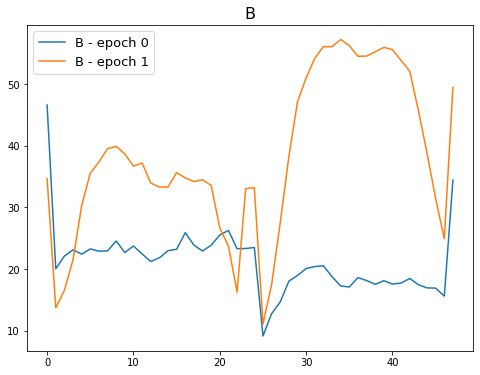

In [321]:
x_axis = np.arange(len(B_log[0]))
plt.figure(figsize=(8,6))
for i in range(n_epochs):
    B = B_log[i]
    plt.plot(x_axis, B, label='B - epoch %d'%i)
plt.legend(fontsize=13)
plt.title("B", fontsize=16)
plt.show()

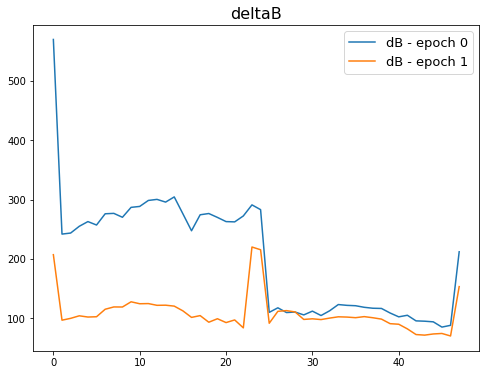

In [322]:
x_axis = np.arange(len(B_log[0]))
plt.figure(figsize=(8,6))
for i in range(n_epochs):
    dB = dB_log[i]
    plt.plot(x_axis, dB, label='dB - epoch %d'%i)
plt.legend(fontsize=13)
plt.title("deltaB", fontsize=16)
plt.show()

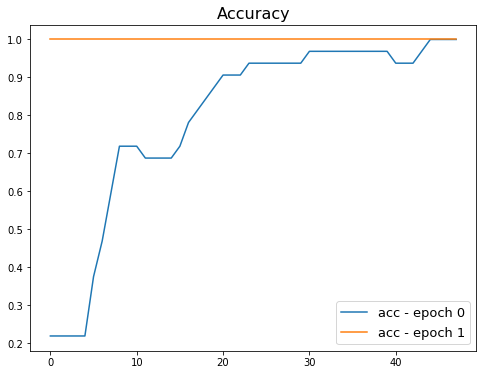

In [323]:
x_axis = np.arange(len(B_log[0]))
plt.figure(figsize=(8,6))
for i in range(n_epochs):
    plt.plot(x_axis, acc_log[i], label='acc - epoch %d'%i)
plt.legend(fontsize=13)
plt.title("Accuracy", fontsize=16)
plt.show()

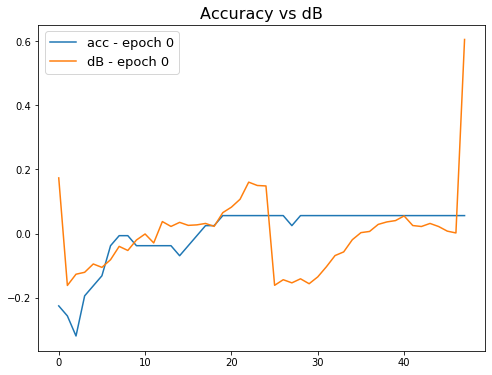

In [172]:
x_axis = np.arange(len(B_log[0]))
for i in range(n_epochs):

    plt.figure(figsize=(8,6))
    plt.plot(x_axis, acc_log[i] - acc_log[i].mean(), label='acc - epoch %d'%i)
    dB_scaled = dB_log[i]/dB_log[i].max()
    plt.plot(x_axis, dB_scaled - dB_scaled.mean(), label='dB - epoch %d'%i)
    plt.legend(fontsize=13)
    plt.title("Accuracy vs dB", fontsize=16)
    plt.show()

In [135]:
data = next(iter(train_loader))
x = np.array([data[i][0] for i in range(len(data))])
y = np.array([data[i][1] for i in range(len(data))])
y

array([0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,

In [136]:
f = net.forward(x)
print(f.elem.shape)
y_pred = np.argmax(f.elem, axis=0)
y_pred

(2, 320)


array([0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,

In [137]:
net.accuracy(x, y, return_MAE=True)

(1.0, 0.5)

## Output normalization
Does a rescaling affects precision?

In [139]:
f_max = np.abs(f.elem).max().astype('float')
print('f_max for random input : ',f_max)
F2 = f_max**(1./net.N) # factor for rescaling
print("Rescaling factor for calibration: ", F2)
for i in range(net.N):
    net.As[i].elem = net.As[i].elem/F2
# compute the new order of magnitude of the output (should be 1)
f = net.forward(x)  

f_max for random input :  105.9943026230132
Rescaling factor for calibration:  1.2050672972858087


In [142]:
f_max = np.abs(f.elem).max().astype('float')
f_max

1.0000000000000002

In [140]:
y_pred = np.argmax(f.elem, axis=0)
y_pred

array([0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,

In [141]:
net.accuracy(x,y, return_MAE=True)

(1.0, 0.5)

## Computer characters recognition

In [21]:
reload(gen)

<module 'data_generator' from '../data_generator.py'>

In [101]:
B = 1168
factor = 4
(dataset, label) = gen.get_computer_characters(factor=factor)
batch_size = {'train_batch_size':B, 'val_batch_size':16, 'test_batch_size':128}
train_loader, val_loader, test_loader = prepare_dataset(dataset, label, 0.8, 0.2, **batch_size)
print("Number of batches in training set: ", len(train_loader))
print("Number of batches in validation set: ", len(val_loader))
print("Number of batches in test set: ", len(test_loader))

Number of files in datasets/0-9_and_A-Z/Sample001 :  1016 

Number of files in datasets/0-9_and_A-Z/Sample002 :  1016 

(1844,)
Number of batches in training set:  1
Number of batches in validation set:  18
Number of batches in test set:  3


In [102]:
reload(tn)

<module 'TensorNetwork' from '/home/nicola/Nicola_unipd/QuintoAnno/Quantum Information/TensorNetworkForML/TensorNetwork/TensorNetwork.py'>

In [103]:
calibration_batch = next(iter(val_loader))
x_calibration = np.array([calibration_batch[i][0] for i in range(len(calibration_batch))])

In [104]:
N = int((32/factor)**2)
M = 10
net = tn.Network(N=N, M=M, L=2, normalize=True, calibration_X=x_calibration)

Normalizing weights...
Scaling factor: 6.40
Calibrating weights on dataset...
f_max for random input of 16 samples :  0.00020001353465409316
Rescaling factor for calibration:  0.8753949821940387
f_max for random input of 16 samples (after):  1.0000000000000033


In [105]:
n_epochs = 10
train_acc, val_acc, B_log, dB_log, acc_log = net.train(train_loader, val_loader, lr = 0.01, n_epochs = n_epochs, print_freq=1)


right sweep step  0
phi (TX):  1168.0
right:  2753.3781972229294
Accuracy (before optim.):  0.4871575342465753
f:  447.1619394375576
f:  1165.6204189511047
DeltaB (before GC):  1995.7824365685433
DeltaB (after GC):  65.90442038348496
B: 	 65.90442038348496
Accuracy (after optim.):  0.4871575342465753

right sweep step  1
phi (TX):  1168.0
circle:  1612.978813307169
Accuracy (before optim.):  0.4871575342465753
f:  438.9395332366226
f:  1162.8054280457645
DeltaB (before GC):  1153.2809042720232
DeltaB (after GC):  29.834278992916452
B: 	 29.834278992916456
Accuracy (after optim.):  0.4871575342465753

right sweep step  2
phi (TX):  1169.3211937791552
circle:  1641.3242696004575
Accuracy (before optim.):  0.4871575342465753
f:  428.891589450703
f:  1159.326202945701
DeltaB (before GC):  1157.0084765167514
DeltaB (after GC):  33.356711065620686
B: 	 33.356711065620686
Accuracy (after optim.):  0.4871575342465753

right sweep step  3
phi (TX):  1174.5293080030265
circle:  1714.29555151188

Accuracy (after optim.):  0.4871575342465753

right sweep step  28
phi (TX):  1585.6549400219405
circle:  1819.7144959461175
Accuracy (before optim.):  0.4871575342465753
f:  498.74026656492435
f:  1086.4945231503152
DeltaB (before GC):  1356.367449837818
DeltaB (after GC):  33.04901882776377
B: 	 33.04901882776377
Accuracy (after optim.):  0.4871575342465753

right sweep step  29
phi (TX):  1464.424216994944
circle:  1652.5901918066145
Accuracy (before optim.):  0.4871575342465753
f:  511.4523836636337
f:  1083.9189836237051
DeltaB (before GC):  1129.2562804510378
DeltaB (after GC):  33.60778887954577
B: 	 33.607788879545765
Accuracy (after optim.):  0.4871575342465753

right sweep step  30
phi (TX):  1252.5692091206733
circle:  1837.0531794695114
Accuracy (before optim.):  0.4871575342465753
f:  520.8902890381803
f:  1082.1496067507264
DeltaB (before GC):  935.7936277960471
DeltaB (after GC):  31.815258274886972
B: 	 31.815258274886975
Accuracy (after optim.):  0.4871575342465753

ri

Accuracy (after optim.):  0.4871575342465753

right sweep step  56
phi (TX):  1170.43919304147
circle:  5405.864284123711
Accuracy (before optim.):  0.4871575342465753
f:  1422.8102833364874
f:  970.9416965855103
DeltaB (before GC):  1009.902061423598
DeltaB (after GC):  35.83802279145942
B: 	 35.83802279145943
Accuracy (after optim.):  0.4871575342465753

right sweep step  57
phi (TX):  1183.9810866391988
circle:  6261.799940377875
Accuracy (before optim.):  0.4871575342465753
f:  1531.903861137696
f:  961.9610636519658
DeltaB (before GC):  1082.2184027133032
DeltaB (after GC):  32.7988696718343
B: 	 32.7988696718343
Accuracy (after optim.):  0.4871575342465753

right sweep step  58
phi (TX):  1209.3279549910949
circle:  5912.5949684138495
Accuracy (before optim.):  0.4871575342465753
f:  1644.876338823653
f:  953.1552779702324
DeltaB (before GC):  941.515194223422
DeltaB (after GC):  33.90470136269299
B: 	 33.90470136269299
Accuracy (after optim.):  0.4871575342465753

right sweep st

Accuracy (after optim.):  0.4871575342465753

left sweep step  38
Accuracy (before optim.):  0.4871575342465753
f:  3640.1925091355292
f:  831.1558277957821
deltaB (before GC):  1255.4562231283114
deltaB (after GC):  26.587649296440595
B: 	 26.587649296440595
Accuracy (after optim.):  0.4871575342465753

left sweep step  37
Accuracy (before optim.):  0.4871575342465753
f:  3698.7650992036006
f:  824.4105305067403
deltaB (before GC):  1265.2912206089647
deltaB (after GC):  26.82331161528937
B: 	 26.823311615289363
Accuracy (after optim.):  0.4871575342465753

left sweep step  36
Accuracy (before optim.):  0.4871575342465753
f:  3797.645325529461
f:  817.8071969894454
deltaB (before GC):  1157.8097622401351
deltaB (after GC):  26.630473510330688
B: 	 26.630473510330688
Accuracy (after optim.):  0.4871575342465753

left sweep step  35
Accuracy (before optim.):  0.4871575342465753
f:  3933.4391716020978
f:  811.6478535473664
deltaB (before GC):  1397.575196225698
deltaB (after GC):  29.087

Accuracy (after optim.):  0.922945205479452

left sweep step  5
Accuracy (before optim.):  0.922945205479452
f:  8330.509993777847
f:  642.524052288921
deltaB (before GC):  577.9559909839852
deltaB (after GC):  27.227041849945874
B: 	 27.22704184994587
Accuracy (after optim.):  0.9366438356164384

left sweep step  4
Accuracy (before optim.):  0.9366438356164384
f:  8671.746916066571
f:  634.7192200995726
deltaB (before GC):  573.1547504438656
deltaB (after GC):  29.82075304984017
B: 	 29.82075304984017
Accuracy (after optim.):  0.949486301369863

left sweep step  3
Accuracy (before optim.):  0.949486301369863
f:  9183.14574007913
f:  625.4196055351064
deltaB (before GC):  528.3527477719795
deltaB (after GC):  27.250170489311504
B: 	 27.250170489311508
Accuracy (after optim.):  0.9657534246575342

left sweep step  2
Accuracy (before optim.):  0.9657534246575342
f:  9724.33334265141
f:  616.9539879942913
deltaB (before GC):  498.67764506080294
deltaB (after GC):  26.097009814195633
B: 	 

Accuracy (after optim.):  0.988013698630137

right sweep step  23
phi (TX):  1168.0
circle:  164131.40535090215
Accuracy (before optim.):  0.988013698630137
f:  49788.75827691634
f:  188.99413779314725
DeltaB (before GC):  1427.8942728769644
DeltaB (after GC):  53.15677058484683
B: 	 53.156770584846846
Accuracy (after optim.):  0.9845890410958904

right sweep step  24
phi (TX):  1219.7692099417466
circle:  219057.58501637564
Accuracy (before optim.):  0.9845890410958904
f:  65519.235608130584
f:  289.4055215537189
DeltaB (before GC):  8326.486657653608
DeltaB (after GC):  52.02483896114183
B: 	 52.024838961141825
Accuracy (after optim.):  0.988013698630137

right sweep step  25
phi (TX):  1382.6379958724235
circle:  191707.9811159945
Accuracy (before optim.):  0.988013698630137
f:  56569.49536688459
f:  180.03038478581018
DeltaB (before GC):  2552.651392082988
DeltaB (after GC):  54.68176709102977
B: 	 54.68176709102977
Accuracy (after optim.):  0.9931506849315068

right sweep step  26

Accuracy (after optim.):  0.9940068493150684

right sweep step  52
phi (TX):  1704.6804120064799
circle:  204566.1087862673
Accuracy (before optim.):  0.9940068493150684
f:  108453.02861405816
f:  61.900665959595095
DeltaB (before GC):  403.45427837938945
DeltaB (after GC):  63.10036782553162
B: 	 63.10036782553162
Accuracy (after optim.):  0.9948630136986302

right sweep step  53
phi (TX):  1358.335079867973
circle:  245115.6081032078
Accuracy (before optim.):  0.9948630136986302
f:  115997.9004784356
f:  59.48430032053887
DeltaB (before GC):  449.0101439509154
DeltaB (after GC):  58.14114560084431
B: 	 58.141145600844304
Accuracy (after optim.):  0.9931506849315068

right sweep step  54
phi (TX):  1177.285210765772
circle:  289644.36060528853
Accuracy (before optim.):  0.9931506849315068
f:  122609.74490914264
f:  48.186974787334734
DeltaB (before GC):  607.9957582426049
DeltaB (after GC):  62.87362609684373
B: 	 62.873626096843736
Accuracy (after optim.):  0.9948630136986302

right 

Accuracy (after optim.):  0.9931506849315068

left sweep step  44
Accuracy (before optim.):  0.9931506849315068
f:  263493.91707721754
f:  24.4582262626283
deltaB (before GC):  2823.9413577980363
deltaB (after GC):  85.23233109549268
B: 	 85.23233109549267
Accuracy (after optim.):  0.9931506849315068

left sweep step  43
Accuracy (before optim.):  0.9931506849315068
f:  268692.4444339381
f:  29.403444392674338
deltaB (before GC):  5427.964372128992
deltaB (after GC):  83.98878799853607
B: 	 83.98878799853608
Accuracy (after optim.):  0.9940068493150684

left sweep step  42
Accuracy (before optim.):  0.9940068493150684
f:  269466.15055707016
f:  26.723385831689477
deltaB (before GC):  4187.009410877223
deltaB (after GC):  82.04267244263258
B: 	 82.04267244263256
Accuracy (after optim.):  0.9940068493150684

left sweep step  41
Accuracy (before optim.):  0.9940068493150684
f:  271023.9717151843
f:  31.778898077665808
deltaB (before GC):  4462.093766977216
deltaB (after GC):  89.126155139

Accuracy (after optim.):  0.9940068493150684

left sweep step  11
Accuracy (before optim.):  0.9940068493150684
f:  187069.50036948372
f:  37.666309044011754
deltaB (before GC):  732.7649970540597
deltaB (after GC):  93.20694526834924
B: 	 93.20694526834923
Accuracy (after optim.):  0.9922945205479452

left sweep step  10
Accuracy (before optim.):  0.9922945205479452
f:  193740.67652169144
f:  64.47241138366013
deltaB (before GC):  3262.1309110855736
deltaB (after GC):  98.17243547473902
B: 	 98.17243547473899
Accuracy (after optim.):  0.9940068493150684

left sweep step  9
Accuracy (before optim.):  0.9940068493150684
f:  174667.18115305912
f:  35.64203771993956
deltaB (before GC):  944.5330566430126
deltaB (after GC):  93.59210668745763
B: 	 93.59210668745763
Accuracy (after optim.):  0.9914383561643836

left sweep step  8
Accuracy (before optim.):  0.9914383561643836
f:  201531.9507699742
f:  66.433469624324
deltaB (before GC):  1763.3305667963382
deltaB (after GC):  92.732614038718

Accuracy (after optim.):  0.990582191780822

right sweep step  18
phi (TX):  1721.065929340708
circle:  1111320.3787881501
Accuracy (before optim.):  0.990582191780822
f:  213527.7038530927
f:  31.065378500683128
DeltaB (before GC):  5853.244792291094
DeltaB (after GC):  94.82958749435883
B: 	 94.82958749435883
Accuracy (after optim.):  0.9726027397260274

right sweep step  19
phi (TX):  1715.3620886804927
circle:  1273547.6480152905
Accuracy (before optim.):  0.9726027397260274
f:  224440.34011896548
f:  81.48364563912546
DeltaB (before GC):  22789.24330813509
DeltaB (after GC):  92.81616519086401
B: 	 92.81616519086403
Accuracy (after optim.):  0.9940068493150684

right sweep step  20
phi (TX):  1666.2548841518242
circle:  1106775.2344923776
Accuracy (before optim.):  0.9940068493150684
f:  211864.61097040752
f:  35.50410154600377
DeltaB (before GC):  1343.1199535417986
DeltaB (after GC):  97.97108111388047
B: 	 97.97108111388047
Accuracy (after optim.):  0.9914383561643836

right sw

Accuracy (after optim.):  0.9948630136986302

right sweep step  45
phi (TX):  1391.9697371435623
circle:  1119869.432329026
Accuracy (before optim.):  0.9948630136986302
f:  190486.81052463097
f:  23.674994144697926
DeltaB (before GC):  5087.415103392126
DeltaB (after GC):  98.00799937867468
B: 	 98.0079993786747
Accuracy (after optim.):  0.9777397260273972

right sweep step  46
phi (TX):  1196.315966476694
circle:  972496.2606501381
Accuracy (before optim.):  0.9777397260273972
f:  202115.73296413146
f:  152.7343460568901
DeltaB (before GC):  32277.56177590422
DeltaB (after GC):  100.03769812829746
B: 	 100.03769812829748
Accuracy (after optim.):  0.9931506849315068

right sweep step  47
phi (TX):  1168.0
circle:  977763.7912073772
Accuracy (before optim.):  0.9931506849315068
f:  176753.23307280976
f:  43.25533771580997
DeltaB (before GC):  29821.126968461424
DeltaB (after GC):  103.07762270808891
B: 	 103.07762270808891
Accuracy (after optim.):  0.990582191780822

right sweep step  

Accuracy (after optim.):  0.9948630136986302

left sweep step  51
Accuracy (before optim.):  0.9948630136986302
f:  288669.1905892388
f:  15.04951899681276
deltaB (before GC):  2038.9239323122567
deltaB (after GC):  98.87590016311285
B: 	 98.87590016311285
Accuracy (after optim.):  0.997431506849315

left sweep step  50
Accuracy (before optim.):  0.997431506849315
f:  292216.3651393973
f:  14.764376444702165
deltaB (before GC):  577.7274702367431
deltaB (after GC):  100.08236317767646
B: 	 100.08236317767644
Accuracy (after optim.):  0.997431506849315

left sweep step  49
Accuracy (before optim.):  0.997431506849315
f:  284219.0265506648
f:  18.153156029681153
deltaB (before GC):  4836.73240416851
deltaB (after GC):  99.69651360642305
B: 	 99.69651360642305
Accuracy (after optim.):  0.9965753424657534

left sweep step  48
Accuracy (before optim.):  0.9965753424657534
f:  303451.6864633927
f:  33.060399129043915
deltaB (before GC):  5552.8305438169455
deltaB (after GC):  100.41574008298

Accuracy (after optim.):  0.9957191780821918

left sweep step  18
Accuracy (before optim.):  0.9957191780821918
f:  369788.51036574226
f:  14.58803326543956
deltaB (before GC):  5745.744648264675
deltaB (after GC):  106.24551945027329
B: 	 106.24551945027329
Accuracy (after optim.):  0.9631849315068494

left sweep step  17
Accuracy (before optim.):  0.9631849315068494
f:  408530.83559911675
f:  228.63750696444583
deltaB (before GC):  113255.6305267406
deltaB (after GC):  98.73647566244779
B: 	 98.73647566244777
Accuracy (after optim.):  0.9948630136986302

left sweep step  16
Accuracy (before optim.):  0.9948630136986302
f:  333484.5749995269
f:  13.879694094054106
deltaB (before GC):  4356.253521188111
deltaB (after GC):  105.35987863453136
B: 	 105.35987863453136
Accuracy (after optim.):  0.9717465753424658

left sweep step  15
Accuracy (before optim.):  0.9717465753424658
f:  437487.7042386413
f:  153.31049205932305
deltaB (before GC):  73684.4882921874
deltaB (after GC):  103.12736

B: 	 95.0468178939066
Accuracy (after optim.):  0.997431506849315

right sweep step  14
phi (TX):  1228.7837537014389
circle:  1883253.2319341952
Accuracy (before optim.):  0.997431506849315
f:  360775.8490245062
f:  12.104476191262513
DeltaB (before GC):  1062.4053975497045
DeltaB (after GC):  101.61080431988202
B: 	 101.61080431988204
Accuracy (after optim.):  0.9777397260273972

right sweep step  15
phi (TX):  1168.0
circle:  2267580.2221657685
Accuracy (before optim.):  0.9777397260273972
f:  432438.13333582284
f:  59.24710753064583
DeltaB (before GC):  23204.42167835043
DeltaB (after GC):  92.06787182397422
B: 	 92.06787182397423
Accuracy (after optim.):  0.9948630136986302

right sweep step  16
phi (TX):  1192.6200140708254
circle:  2227638.794902044
Accuracy (before optim.):  0.9948630136986302
f:  328646.20297224994
f:  13.93645541934204
DeltaB (before GC):  7733.325908376528
DeltaB (after GC):  94.3679544375988
B: 	 94.36795443759881
Accuracy (after optim.):  0.978595890410959

Accuracy (after optim.):  0.9965753424657534

right sweep step  41
phi (TX):  1437.153072379284
circle:  1611294.9011255791
Accuracy (before optim.):  0.9965753424657534
f:  302260.75578966155
f:  17.12268601495976
DeltaB (before GC):  20971.521002472466
DeltaB (after GC):  102.01844061360028
B: 	 102.01844061360026
Accuracy (after optim.):  0.9794520547945206

right sweep step  42
phi (TX):  1569.478461194665
circle:  1575971.2210287321
Accuracy (before optim.):  0.9794520547945206
f:  325582.28672025644
f:  134.5592694868889
DeltaB (before GC):  102006.43698762186
DeltaB (after GC):  107.59442807874115
B: 	 107.59442807874115
Accuracy (after optim.):  0.9957191780821918

right sweep step  43
phi (TX):  1755.08246436453
circle:  1881526.3000444116
Accuracy (before optim.):  0.9957191780821918
f:  310079.4113692383
f:  17.963528125237914
DeltaB (before GC):  23530.222572470102
DeltaB (after GC):  105.4347953662979
B: 	 105.43479536629789
Accuracy (after optim.):  0.9897260273972602

ri

Accuracy (after optim.):  0.9982876712328768

left sweep step  58
Accuracy (before optim.):  0.9982876712328768
f:  328173.8160811297
f:  9.904000624434605
deltaB (before GC):  73.92431966299003
deltaB (after GC):  60.435865182929035
B: 	 60.435865182929035
Accuracy (after optim.):  0.997431506849315

left sweep step  57
Accuracy (before optim.):  0.997431506849315
f:  322838.4288382334
f:  12.874688628308766
deltaB (before GC):  817.7745716619
deltaB (after GC):  68.52554076146829
B: 	 68.52554076146829
Accuracy (after optim.):  0.9957191780821918

left sweep step  56
Accuracy (before optim.):  0.9957191780821918
f:  318858.1992390788
f:  14.368969423776871
deltaB (before GC):  3078.113236406559
deltaB (after GC):  76.5671690918774
B: 	 76.5671690918774
Accuracy (after optim.):  0.9965753424657534

left sweep step  55
Accuracy (before optim.):  0.9965753424657534
f:  360082.58056451415
f:  22.72148135196835
deltaB (before GC):  5445.177306114307
deltaB (after GC):  85.87623194113334
B

Accuracy (after optim.):  0.9931506849315068

left sweep step  25
Accuracy (before optim.):  0.9931506849315068
f:  312389.77334933716
f:  51.25421782520338
deltaB (before GC):  135306.45058543838
deltaB (after GC):  102.57615276265446
B: 	 102.57615276265446
Accuracy (after optim.):  0.9049657534246576

left sweep step  24
Accuracy (before optim.):  0.9049657534246576
f:  413000.2236881942
f:  429.373248193629
deltaB (before GC):  382872.0530838113
deltaB (after GC):  105.26520403277038
B: 	 105.2652040327704
Accuracy (after optim.):  0.9837328767123288

left sweep step  23
Accuracy (before optim.):  0.9837328767123288
f:  256762.13253255782
f:  50.654873798287355
deltaB (before GC):  219454.54190615774
deltaB (after GC):  104.7503420159733
B: 	 104.7503420159733
Accuracy (after optim.):  0.9940068493150684

left sweep step  22
Accuracy (before optim.):  0.9940068493150684
f:  342775.62681697845
f:  32.2260586451353
deltaB (before GC):  16602.768849375912
deltaB (after GC):  106.76323

Accuracy (after optim.):  0.9982876712328768

right sweep step  6
phi (TX):  1168.4310387497533
circle:  1512822.3054151235
Accuracy (before optim.):  0.9982876712328768
f:  421842.27461804246
f:  9.998958178140498
DeltaB (before GC):  547.4775142549161
DeltaB (after GC):  81.23365010618163
B: 	 81.23365010618161
Accuracy (after optim.):  0.997431506849315

right sweep step  7
phi (TX):  1168.0
circle:  1663498.786870433
Accuracy (before optim.):  0.997431506849315
f:  391006.79832658224
f:  10.075451349434502
DeltaB (before GC):  1723.4448209872578
DeltaB (after GC):  92.47478692530947
B: 	 92.47478692530947
Accuracy (after optim.):  0.9965753424657534

right sweep step  8
phi (TX):  1170.1051354787671
circle:  1570081.597715297
Accuracy (before optim.):  0.9965753424657534
f:  460657.6433232507
f:  24.033739272293175
DeltaB (before GC):  4805.8330123388705
DeltaB (after GC):  98.33815793287202
B: 	 98.33815793287204
Accuracy (after optim.):  0.9957191780821918

right sweep step  9
ph

Accuracy (after optim.):  0.9366438356164384

right sweep step  35
phi (TX):  1627.1825701784837
circle:  4965837.446743665
Accuracy (before optim.):  0.9366438356164384
f:  411068.46851158387
f:  185.1404823746489
DeltaB (before GC):  295917.8387089936
DeltaB (after GC):  106.3857707211681
B: 	 106.38577072116809
Accuracy (after optim.):  0.9777397260273972

right sweep step  36
phi (TX):  1584.8066956212951
circle:  4332871.543619294
Accuracy (before optim.):  0.9777397260273972
f:  337112.87484485295
f:  81.48069716412539
DeltaB (before GC):  122397.45505386314
DeltaB (after GC):  104.17767705382897
B: 	 104.17767705382896
Accuracy (after optim.):  0.9948630136986302

right sweep step  37
phi (TX):  1398.31334828057
circle:  3393835.6768310084
Accuracy (before optim.):  0.9948630136986302
f:  330988.8122258435
f:  24.135485159934362
DeltaB (before GC):  29652.955891007005
DeltaB (after GC):  103.87706464226822
B: 	 103.87706464226824
Accuracy (after optim.):  0.836472602739726

righ

Accuracy (after optim.):  0.997431506849315

left sweep step  61
Accuracy (before optim.):  0.997431506849315
f:  370076.6361569582
f:  9.34936485561533
deltaB (before GC):  20.00083196859696
deltaB (after GC):  20.00083196859696
B: 	 30.841881272588697
Accuracy (after optim.):  0.997431506849315

left sweep step  60
Accuracy (before optim.):  0.997431506849315
f:  366084.53860475414
f:  9.458574742927379
deltaB (before GC):  57.313029007728346
deltaB (after GC):  39.73184508799792
B: 	 39.73184508799791
Accuracy (after optim.):  0.997431506849315

left sweep step  59
Accuracy (before optim.):  0.997431506849315
f:  358462.94158858905
f:  9.656692133902629
deltaB (before GC):  97.46181980118416
deltaB (after GC):  51.33366914643419
B: 	 51.33366914643419
Accuracy (after optim.):  0.997431506849315

left sweep step  58
Accuracy (before optim.):  0.997431506849315
f:  358224.2660037469
f:  9.54291556570302
deltaB (before GC):  185.28677860587862
deltaB (after GC):  64.53332717309094
B: 	

Accuracy (after optim.):  0.9922945205479452

left sweep step  28
Accuracy (before optim.):  0.9922945205479452
f:  373105.04800713924
f:  40.152338925542814
deltaB (before GC):  67231.32074556177
deltaB (after GC):  106.63290345027555
B: 	 106.63290345027556
Accuracy (after optim.):  0.9666095890410958

left sweep step  27
Accuracy (before optim.):  0.9666095890410958
f:  457860.0723601462
f:  126.51046294270775
deltaB (before GC):  205397.5876762992
deltaB (after GC):  110.86874295954675
B: 	 110.86874295954675
Accuracy (after optim.):  0.9888698630136986

left sweep step  26
Accuracy (before optim.):  0.9888698630136986
f:  336210.908764016
f:  30.268412333088904
deltaB (before GC):  117962.2413824235
deltaB (after GC):  110.64663951633369
B: 	 110.64663951633366
Accuracy (after optim.):  0.8698630136986302

left sweep step  25
Accuracy (before optim.):  0.8698630136986302
f:  395267.31896553
f:  378.3222347562212
deltaB (before GC):  420479.8357689321
deltaB (after GC):  108.037901

Accuracy (after optim.):  0.9871575342465754

right sweep step  30
phi (TX):  1252.0245462248454
circle:  3333027.405601523
Accuracy (before optim.):  0.9871575342465754
f:  225732.72019387057
f:  35.997940178899
DeltaB (before GC):  146550.60822953077
DeltaB (after GC):  113.19513775041196
B: 	 113.19513775041196
Accuracy (after optim.):  0.8647260273972602

right sweep step  31
phi (TX):  1168.0
circle:  3000986.6577003635
Accuracy (before optim.):  0.8647260273972602
f:  286277.0794388521
f:  433.083400646933
DeltaB (before GC):  347838.0456487974
DeltaB (after GC):  114.62798411439337
B: 	 114.62798411439337
Accuracy (after optim.):  0.9708904109589042

right sweep step  32
phi (TX):  1244.340462475157
circle:  3183279.767543803
Accuracy (before optim.):  0.9708904109589042
f:  166298.77631054987
f:  211.7901820690255
DeltaB (before GC):  1359888.183160773
DeltaB (after GC):  111.95799860575215
B: 	 111.95799860575214
Accuracy (after optim.):  0.9940068493150684

right sweep step  

Accuracy (after optim.):  0.997431506849315

right sweep step  56
phi (TX):  1170.43919304147
circle:  1360886.4854684637
Accuracy (before optim.):  0.997431506849315
f:  284036.95989829744
f:  14.88853334026027
DeltaB (before GC):  1967.6537142954535
DeltaB (after GC):  84.00534273931879
B: 	 84.00534273931879
Accuracy (after optim.):  0.9965753424657534

right sweep step  57
phi (TX):  1184.0211390810034
circle:  1229315.4408561783
Accuracy (before optim.):  0.9965753424657534
f:  274085.0186864919
f:  13.202570374674234
DeltaB (before GC):  1641.4222909285904
DeltaB (after GC):  75.58799482182195
B: 	 75.58799482182195
Accuracy (after optim.):  0.9965753424657534

right sweep step  58
phi (TX):  1209.1912202252286
circle:  863995.3018560576
Accuracy (before optim.):  0.9965753424657534
f:  282695.1412225449
f:  12.10756051695915
DeltaB (before GC):  131.46334373635364
DeltaB (after GC):  62.877720900323546
B: 	 62.87772090032353
Accuracy (after optim.):  0.997431506849315

right swe

Accuracy (after optim.):  0.9674657534246576

left sweep step  38
Accuracy (before optim.):  0.9674657534246576
f:  416350.443177679
f:  179.3703583106336
deltaB (before GC):  251028.48336116836
deltaB (after GC):  108.4793497804834
B: 	 108.47934978048339
Accuracy (after optim.):  0.9940068493150684

left sweep step  37
Accuracy (before optim.):  0.9940068493150684
f:  382942.7221676772
f:  18.73760957209867
deltaB (before GC):  66254.17356030035
deltaB (after GC):  110.07784711940937
B: 	 110.07784711940936
Accuracy (after optim.):  0.997431506849315

left sweep step  36
Accuracy (before optim.):  0.997431506849315
f:  405296.70562509703
f:  11.61164551051285
deltaB (before GC):  8153.434012328435
deltaB (after GC):  104.62329700890854
B: 	 104.62329700890854
Accuracy (after optim.):  0.9948630136986302

left sweep step  35
Accuracy (before optim.):  0.9948630136986302
f:  391528.91324541403
f:  11.912342296694147
deltaB (before GC):  19820.01887648254
deltaB (after GC):  110.2213881

Accuracy (after optim.):  0.9965753424657534

left sweep step  6
Accuracy (before optim.):  0.9965753424657534
f:  367263.258367262
f:  9.595944315614972
deltaB (before GC):  710.2585862055239
deltaB (after GC):  78.26223018231244
B: 	 78.26223018231244
Accuracy (after optim.):  0.9965753424657534

left sweep step  5
Accuracy (before optim.):  0.9965753424657534
f:  401664.60730768245
f:  10.684496839813775
deltaB (before GC):  471.0884303388292
deltaB (after GC):  67.03414704103528
B: 	 67.03414704103528
Accuracy (after optim.):  0.9965753424657534

left sweep step  4
Accuracy (before optim.):  0.9965753424657534
f:  366254.51793805615
f:  10.137939088651565
deltaB (before GC):  239.9837339179051
deltaB (after GC):  56.80757791657543
B: 	 56.80757791657544
Accuracy (after optim.):  0.9965753424657534

left sweep step  3
Accuracy (before optim.):  0.9965753424657534
f:  382203.66268070624
f:  10.54995398657135
deltaB (before GC):  140.78390362541427
deltaB (after GC):  46.5653396079747

Accuracy (after optim.):  0.958904109589041

right sweep step  24
phi (TX):  1220.075772906623
circle:  5724880.593792555
Accuracy (before optim.):  0.958904109589041
f:  432317.66745573713
f:  244.22964480442687
DeltaB (before GC):  464333.44078990375
DeltaB (after GC):  107.24617301187953
B: 	 107.24617301187956
Accuracy (after optim.):  0.988013698630137

right sweep step  25
phi (TX):  1382.306900721125
circle:  5396920.203348933
Accuracy (before optim.):  0.988013698630137
f:  315229.12322476006
f:  48.81336988181688
DeltaB (before GC):  515595.22333726264
DeltaB (after GC):  108.83864940154781
B: 	 108.83864940154783
Accuracy (after optim.):  0.9940068493150684

right sweep step  26
phi (TX):  1535.603157250244
circle:  4596591.922250893
Accuracy (before optim.):  0.9940068493150684
f:  376050.1926617506
f:  34.632597573986715
DeltaB (before GC):  42603.225418017
DeltaB (after GC):  114.18885518907031
B: 	 114.18885518907032
Accuracy (after optim.):  0.9940068493150684

right swe

Accuracy (after optim.):  0.997431506849315

right sweep step  51
phi (TX):  1868.4162349807227
circle:  1675857.0403257352
Accuracy (before optim.):  0.997431506849315
f:  368397.52123513236
f:  9.915914573191204
DeltaB (before GC):  1314.6743505014485
DeltaB (after GC):  99.51102439543396
B: 	 99.51102439543396
Accuracy (after optim.):  0.9965753424657534

right sweep step  52
phi (TX):  1702.5352957472005
circle:  1568932.392498995
Accuracy (before optim.):  0.9965753424657534
f:  379992.34996055905
f:  14.219852015330517
DeltaB (before GC):  1693.1639382684525
DeltaB (after GC):  98.45917985513816
B: 	 98.45917985513816
Accuracy (after optim.):  0.9957191780821918

right sweep step  53
phi (TX):  1357.3456950234977
circle:  1885810.4330224644
Accuracy (before optim.):  0.9957191780821918
f:  357773.57629916165
f:  12.387768801273971
DeltaB (before GC):  5823.6935387883705
DeltaB (after GC):  93.56057167365184
B: 	 93.56057167365185
Accuracy (after optim.):  0.9957191780821918

righ

deltaB (before GC):  125311.9285702033
deltaB (after GC):  99.26865182177485
B: 	 99.26865182177485
Accuracy (after optim.):  0.9948630136986302

left sweep step  45
Accuracy (before optim.):  0.9948630136986302
f:  365233.0769198452
f:  14.247586752897096
deltaB (before GC):  15929.804041275123
deltaB (after GC):  105.65234935198981
B: 	 105.65234935198983
Accuracy (after optim.):  0.9965753424657534

left sweep step  44
Accuracy (before optim.):  0.9965753424657534
f:  374824.2431802236
f:  19.424879447383717
deltaB (before GC):  14108.226030989234
deltaB (after GC):  99.27705468359154
B: 	 99.27705468359156
Accuracy (after optim.):  0.997431506849315

left sweep step  43
Accuracy (before optim.):  0.997431506849315
f:  366715.8189789598
f:  12.897782841806862
deltaB (before GC):  11240.437791872542
deltaB (after GC):  108.0915565134242
B: 	 108.09155651342418
Accuracy (after optim.):  0.9965753424657534

left sweep step  42
Accuracy (before optim.):  0.9965753424657534
f:  376709.59

Accuracy (after optim.):  0.9957191780821918

left sweep step  11
Accuracy (before optim.):  0.9957191780821918
f:  267758.50547473296
f:  13.913220937463045
deltaB (before GC):  1129.5949657540823
deltaB (after GC):  103.325943088884
B: 	 103.325943088884
Accuracy (after optim.):  0.9965753424657534

left sweep step  10
Accuracy (before optim.):  0.9965753424657534
f:  275614.0781696957
f:  16.076990682269017
deltaB (before GC):  2650.4255989803614
deltaB (after GC):  101.36782780155244
B: 	 101.36782780155244
Accuracy (after optim.):  0.9957191780821918

left sweep step  9
Accuracy (before optim.):  0.9957191780821918
f:  236315.6015144604
f:  24.76634026423762
deltaB (before GC):  23775.781692071134
deltaB (after GC):  101.15648898507811
B: 	 101.1564889850781
Accuracy (after optim.):  0.990582191780822

left sweep step  8
Accuracy (before optim.):  0.990582191780822
f:  331541.8599791276
f:  123.6540079514677
deltaB (before GC):  56408.47490435004
deltaB (after GC):  95.60335034850

Accuracy (after optim.):  0.9965753424657534

right sweep step  18
phi (TX):  1721.1312360501101
circle:  2080476.875414323
Accuracy (before optim.):  0.9965753424657534
f:  209869.0081806824
f:  17.601745600857377
DeltaB (before GC):  3947.1962596953
DeltaB (after GC):  101.98377255415937
B: 	 101.98377255415937
Accuracy (after optim.):  0.9940068493150684

right sweep step  19
phi (TX):  1715.108259439065
circle:  2304038.991557376
Accuracy (before optim.):  0.9940068493150684
f:  197487.09144628188
f:  35.487547938521786
DeltaB (before GC):  84920.00679296814
DeltaB (after GC):  97.7375671533299
B: 	 97.7375671533299
Accuracy (after optim.):  0.9965753424657534

right sweep step  20
phi (TX):  1667.4365973902754
circle:  2435764.659429225
Accuracy (before optim.):  0.9965753424657534
f:  231707.0021122443
f:  14.723786620559636
DeltaB (before GC):  3141.994585737607
DeltaB (after GC):  100.61754060448587
B: 	 100.61754060448588
Accuracy (after optim.):  0.9897260273972602

right swe

Accuracy (after optim.):  0.9948630136986302

right sweep step  45
phi (TX):  1391.1426834492484
circle:  2268875.857254341
Accuracy (before optim.):  0.9948630136986302
f:  287976.6830520531
f:  17.841039807436836
DeltaB (before GC):  11594.127830567171
DeltaB (after GC):  111.39943690947524
B: 	 111.39943690947524
Accuracy (after optim.):  0.9477739726027398

right sweep step  46
phi (TX):  1196.0999061562286
circle:  2384745.557632196
Accuracy (before optim.):  0.9477739726027398
f:  314704.2549411638
f:  395.5961563220833
DeltaB (before GC):  238461.43932828069
DeltaB (after GC):  106.84332405807716
B: 	 106.84332405807716
Accuracy (after optim.):  0.9940068493150684

right sweep step  47
phi (TX):  1168.0
circle:  2400105.7860469357
Accuracy (before optim.):  0.9940068493150684
f:  271564.11393702833
f:  23.250455954752056
DeltaB (before GC):  32281.28352455681
DeltaB (after GC):  110.57375853313701
B: 	 110.57375853313701
Accuracy (after optim.):  0.9768835616438356

right sweep 

Accuracy (before optim.):  0.9948630136986302
f:  295344.0737374768
f:  16.244086596207225
deltaB (before GC):  13282.829665579675
deltaB (after GC):  96.95638271068722
B: 	 96.95638271068722
Accuracy (after optim.):  0.997431506849315

left sweep step  51
Accuracy (before optim.):  0.997431506849315
f:  296368.0999786041
f:  13.775171064537915
deltaB (before GC):  6503.326166594285
deltaB (after GC):  100.4358875647379
B: 	 100.4358875647379
Accuracy (after optim.):  0.9965753424657534

left sweep step  50
Accuracy (before optim.):  0.9965753424657534
f:  304397.4400850261
f:  14.26171141782287
deltaB (before GC):  2124.4486118519017
deltaB (after GC):  104.39222874552928
B: 	 104.39222874552931
Accuracy (after optim.):  0.9914383561643836

left sweep step  49
Accuracy (before optim.):  0.9914383561643836
f:  297881.1025519778
f:  37.74568759131336
deltaB (before GC):  16264.837506032181
deltaB (after GC):  104.56776198715447
B: 	 104.56776198715446
Accuracy (after optim.):  0.9940068

Accuracy (after optim.):  0.997431506849315

left sweep step  18
Accuracy (before optim.):  0.997431506849315
f:  179320.49834806065
f:  67.20937741021054
deltaB (before GC):  91393.50442281496
deltaB (after GC):  105.6639014448905
B: 	 105.6639014448905
Accuracy (after optim.):  0.9965753424657534

left sweep step  17
Accuracy (before optim.):  0.9965753424657534
f:  181631.5284086133
f:  97.18929089056539
deltaB (before GC):  83199.57931806201
deltaB (after GC):  104.08141656056307
B: 	 104.08141656056306
Accuracy (after optim.):  0.9922945205479452

left sweep step  16
Accuracy (before optim.):  0.9922945205479452
f:  155433.93757076928
f:  92.77053752814278
deltaB (before GC):  373197.55352790246
deltaB (after GC):  107.58576518243046
B: 	 107.58576518243046
Accuracy (after optim.):  0.940068493150685

left sweep step  15
Accuracy (before optim.):  0.940068493150685
f:  244878.88370524475
f:  315.94358172506554
deltaB (before GC):  210676.77661886683
deltaB (after GC):  105.9100415

f:  252659.9725485721
f:  45.81300573356988
DeltaB (before GC):  32551.057223803953
DeltaB (after GC):  95.30096345286567
B: 	 95.30096345286569
Accuracy (after optim.):  0.997431506849315

right sweep step  12
phi (TX):  1893.2368936933385
circle:  1706033.4593187456
Accuracy (before optim.):  0.997431506849315
f:  232271.13575980533
f:  16.213693687685478
DeltaB (before GC):  3317.8921410778385
DeltaB (after GC):  95.38101451486384
B: 	 95.38101451486384
Accuracy (after optim.):  0.9982876712328768

right sweep step  13
phi (TX):  1535.850975189926
circle:  2381032.5402944004
Accuracy (before optim.):  0.9982876712328768
f:  213439.1855288975
f:  14.6850003446934
DeltaB (before GC):  3870.885096949565
DeltaB (after GC):  91.93175907903984
B: 	 91.93175907903982
Accuracy (after optim.):  0.997431506849315

right sweep step  14
phi (TX):  1228.4944768752298
circle:  2892607.2967460523
Accuracy (before optim.):  0.997431506849315
f:  236294.76842708336
f:  48.050088748112586
DeltaB (bef

Accuracy (after optim.):  0.9897260273972602

right sweep step  39
phi (TX):  1168.0
circle:  3759950.1891849646
Accuracy (before optim.):  0.9897260273972602
f:  320582.7693436374
f:  86.02209884022149
DeltaB (before GC):  462801.80613681825
DeltaB (after GC):  106.10696194978858
B: 	 106.10696194978857
Accuracy (after optim.):  0.9828767123287672

right sweep step  40
phi (TX):  1252.033327538069
circle:  3175901.387506326
Accuracy (before optim.):  0.9828767123287672
f:  415344.3178245183
f:  95.92662226207185
DeltaB (before GC):  100469.79985577449
DeltaB (after GC):  107.77313451191444
B: 	 107.77313451191444
Accuracy (after optim.):  0.9940068493150684

right sweep step  41
phi (TX):  1437.2451886404233
circle:  3053902.6110490425
Accuracy (before optim.):  0.9940068493150684
f:  352868.94623709575
f:  45.144425633900326
DeltaB (before GC):  257457.39487423768
DeltaB (after GC):  108.96269721438671
B: 	 108.96269721438674
Accuracy (after optim.):  0.9957191780821918

right sweep 

Accuracy (after optim.):  0.997431506849315

left sweep step  58
Accuracy (before optim.):  0.997431506849315
f:  469874.1149359266
f:  11.433068499960982
deltaB (before GC):  4693.967505860726
deltaB (after GC):  62.43570375222913
B: 	 62.43570375222913
Accuracy (after optim.):  0.9914383561643836

left sweep step  57
Accuracy (before optim.):  0.9914383561643836
f:  477300.9592380681
f:  45.79508562537998
deltaB (before GC):  31671.655554102086
deltaB (after GC):  70.05148978912608
B: 	 70.0514897891261
Accuracy (after optim.):  0.9940068493150684

left sweep step  56
Accuracy (before optim.):  0.9940068493150684
f:  468682.23462165496
f:  11.583406524328584
deltaB (before GC):  8061.402674014667
deltaB (after GC):  77.52663649278091
B: 	 77.52663649278091
Accuracy (after optim.):  0.9777397260273972

left sweep step  55
Accuracy (before optim.):  0.9777397260273972
f:  500406.57379780366
f:  79.285145775654
deltaB (before GC):  63613.80187229894
deltaB (after GC):  82.53599669387688

Accuracy (after optim.):  0.9751712328767124

left sweep step  26
Accuracy (before optim.):  0.9751712328767124
f:  427495.4516296942
f:  201.8184687432488
deltaB (before GC):  506388.5832348096
deltaB (after GC):  113.65230728391053
B: 	 113.65230728391052
Accuracy (after optim.):  0.9837328767123288

left sweep step  25
Accuracy (before optim.):  0.9837328767123288
f:  437204.0337477898
f:  68.27688051896249
deltaB (before GC):  575324.4674988925
deltaB (after GC):  112.5480558310789
B: 	 112.5480558310789
Accuracy (after optim.):  0.7534246575342466

left sweep step  24
Accuracy (before optim.):  0.7534246575342466
f:  591845.1415067066
f:  600.6887237754988
deltaB (before GC):  600662.4545825014
deltaB (after GC):  111.92017728972695
B: 	 111.92017728972696
Accuracy (after optim.):  0.985445205479452

left sweep step  23
Accuracy (before optim.):  0.985445205479452
f:  351559.84573594626
f:  276.9700208732516
deltaB (before GC):  2299723.0216423543
deltaB (after GC):  110.601027791

Accuracy (after optim.):  0.9957191780821918

right sweep step  6
phi (TX):  1168.4310387497533
circle:  3141986.4230549186
Accuracy (before optim.):  0.9957191780821918
f:  483196.51634055644
f:  18.08179426666006
DeltaB (before GC):  14667.623843892725
DeltaB (after GC):  83.03788744900247
B: 	 83.03788744900245
Accuracy (after optim.):  0.997431506849315

right sweep step  7
phi (TX):  1168.0
circle:  3260355.1742392876
Accuracy (before optim.):  0.997431506849315
f:  459369.23608201864
f:  11.700508975643638
DeltaB (before GC):  7831.873765604477
DeltaB (after GC):  86.94805054129242
B: 	 86.9480505412924
Accuracy (after optim.):  0.9957191780821918

right sweep step  8
phi (TX):  1170.0894757511244
circle:  2630573.1829311554
Accuracy (before optim.):  0.9957191780821918
f:  482510.05964463437
f:  20.867510440527653
DeltaB (before GC):  14245.34344250536
DeltaB (after GC):  94.48477662320808
B: 	 94.48477662320809
Accuracy (after optim.):  0.9957191780821918

right sweep step  9
p

Accuracy (after optim.):  0.997431506849315

right sweep step  35
phi (TX):  1627.4712374749574
circle:  3734340.6175847114
Accuracy (before optim.):  0.997431506849315
f:  457194.17917788035
f:  12.306805345682298
DeltaB (before GC):  9202.539034945956
DeltaB (after GC):  107.22334257042043
B: 	 107.22334257042044
Accuracy (after optim.):  0.9914383561643836

right sweep step  36
phi (TX):  1585.0660290163578
circle:  3382173.7971373866
Accuracy (before optim.):  0.9914383561643836
f:  448448.75888548535
f:  29.592000871324316
DeltaB (before GC):  14366.114455114144
DeltaB (after GC):  106.82622892229816
B: 	 106.82622892229814
Accuracy (after optim.):  0.9957191780821918

right sweep step  37
phi (TX):  1397.925967514444
circle:  3194901.547675218
Accuracy (before optim.):  0.9957191780821918
f:  428138.2826709519
f:  17.47886005410998
DeltaB (before GC):  38249.726360460714
DeltaB (after GC):  108.84347009795249
B: 	 108.84347009795249
Accuracy (after optim.):  0.9477739726027398

r

Accuracy (after optim.):  0.997431506849315

right sweep step  62
phi (TX):  1168.5111674734253
left:  578831.7636166926
Accuracy (before optim.):  0.997431506849315
f:  492215.77055068885
f:  10.097840897632183
DeltaB (before GC):  19.334235566074277
DeltaB (after GC):  19.334235566074277
B: 	 119.00365974644352
Accuracy (after optim.):  0.997431506849315

left sweep step  63
Accuracy (before optim.):  0.997431506849315
f:  486845.2277694389
f:  10.099488944218075
deltaB (before GC):  16.213213186662983
deltaB (after GC):  16.213213186662983
B: 	 118.7177940783008
Accuracy (after optim.):  0.997431506849315

left sweep step  62
Accuracy (before optim.):  0.997431506849315
f:  483599.3013433293
f:  10.189430399804019
deltaB (before GC):  11.73437463037012
deltaB (after GC):  11.73437463037012
B: 	 39.52595850180893
Accuracy (after optim.):  0.997431506849315

left sweep step  61
Accuracy (before optim.):  0.997431506849315
f:  476537.6878701765
f:  10.410881370226221
deltaB (before GC)

Accuracy (after optim.):  0.9871575342465754

left sweep step  31
Accuracy (before optim.):  0.9871575342465754
f:  527838.0423756496
f:  40.372733755288294
deltaB (before GC):  371383.8126487838
deltaB (after GC):  103.79912785951885
B: 	 103.79912785951888
Accuracy (after optim.):  0.9083904109589042

left sweep step  30
Accuracy (before optim.):  0.9083904109589042
f:  721202.0162952144
f:  480.4850579932828
deltaB (before GC):  1058791.472574054
deltaB (after GC):  116.28693800968304
B: 	 116.28693800968304
Accuracy (after optim.):  0.9940068493150684

left sweep step  29
Accuracy (before optim.):  0.9940068493150684
f:  656420.4962893574
f:  22.89336712210958
deltaB (before GC):  121123.10196749761
deltaB (after GC):  121.09388738885525
B: 	 121.09388738885525
Accuracy (after optim.):  0.973458904109589

left sweep step  28
Accuracy (before optim.):  0.973458904109589
f:  726596.7539836555
f:  83.1252106467219
deltaB (before GC):  205835.07305791698
deltaB (after GC):  125.9317184

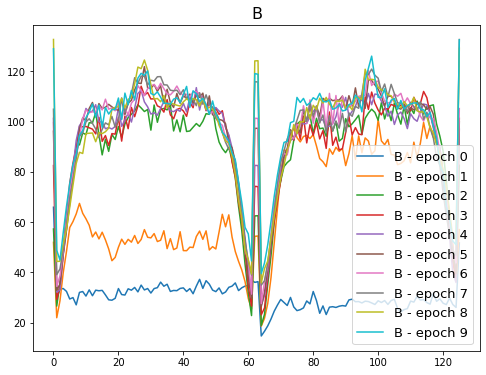

In [106]:
x_axis = np.arange(len(B_log[0]))
plt.figure(figsize=(8,6))
for i in range(n_epochs):
    B = B_log[i]
    plt.plot(x_axis, B, label='B - epoch %d'%i)
plt.legend(fontsize=13)
plt.title("B", fontsize=16)
plt.show()

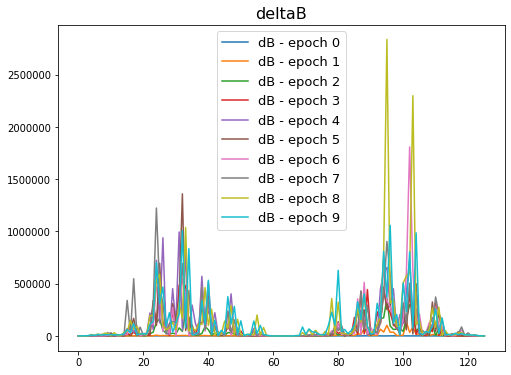

In [107]:
x_axis = np.arange(len(B_log[0]))
plt.figure(figsize=(8,6))
for i in range(n_epochs):
    dB = dB_log[i]
    plt.plot(x_axis, dB, label='dB - epoch %d'%i)
plt.legend(fontsize=13)
plt.title("deltaB", fontsize=16)
plt.show()

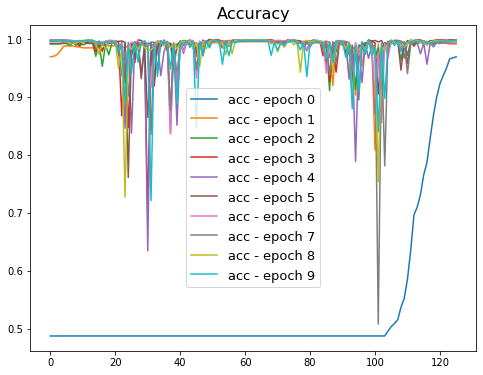

In [108]:
x_axis = np.arange(len(B_log[0]))
plt.figure(figsize=(8,6))
for i in range(n_epochs):
    plt.plot(x_axis, acc_log[i], label='acc - epoch %d'%i)
plt.legend(fontsize=13)
plt.title("Accuracy", fontsize=16)
plt.show()

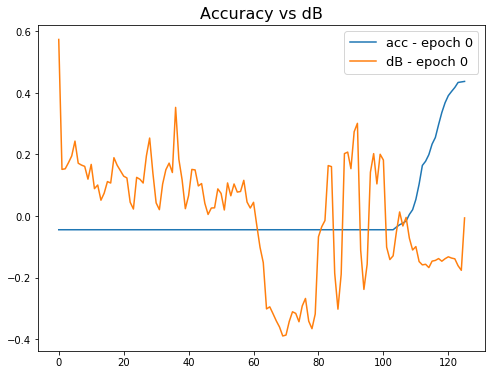

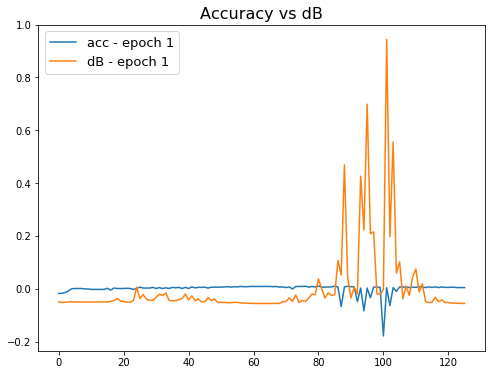

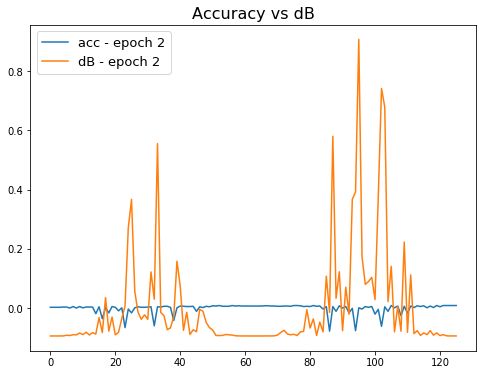

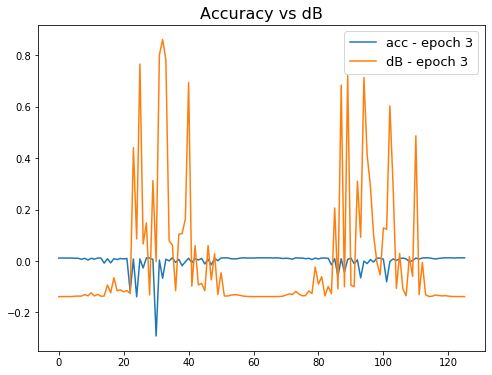

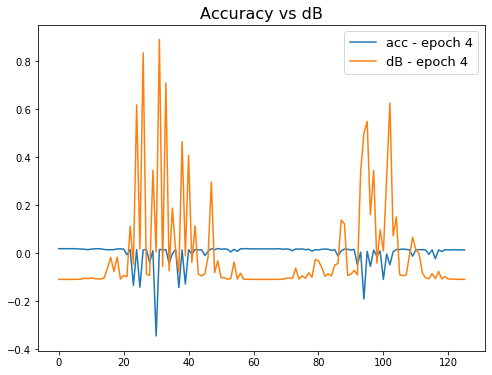

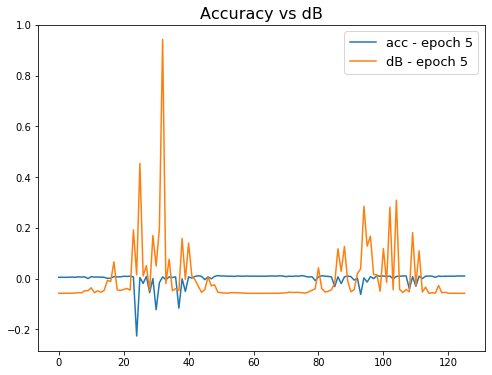

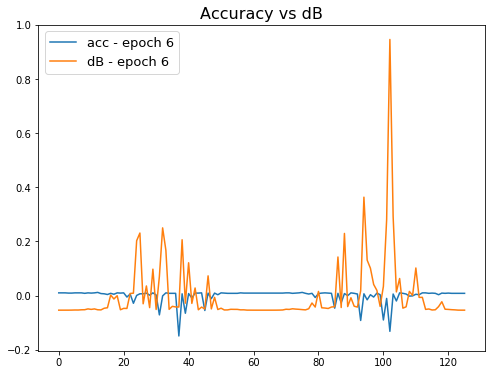

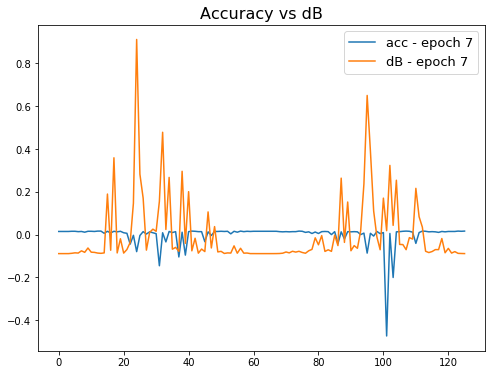

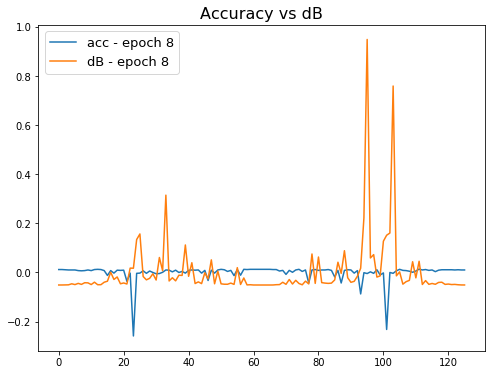

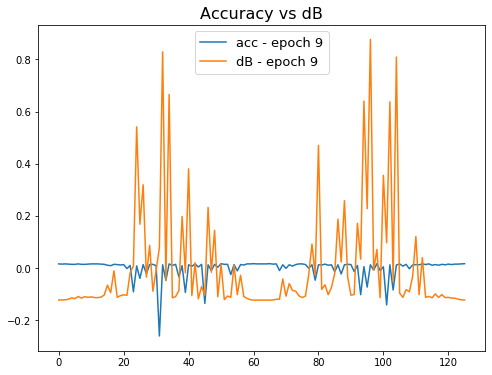

In [109]:
x_axis = np.arange(len(B_log[0]))
for i in range(n_epochs):

    plt.figure(figsize=(8,6))
    plt.plot(x_axis, acc_log[i] - acc_log[i].mean(), label='acc - epoch %d'%i)
    dB_scaled = dB_log[i]/dB_log[i].max()
    plt.plot(x_axis, dB_scaled - dB_scaled.mean(), label='dB - epoch %d'%i)
    plt.legend(fontsize=13)
    plt.title("Accuracy vs dB", fontsize=16)
    plt.show()

## 16 x 16 version

In [67]:
B = 584
factor = 2
(dataset, label) = gen.get_computer_characters(factor=factor)
batch_size = {'train_batch_size':B, 'val_batch_size':16, 'test_batch_size':128}
train_loader, val_loader, test_loader = prepare_dataset(dataset, label, 0.8, 0.2, **batch_size)
print("Number of batches in training set: ", len(train_loader))
print("Number of batches in validation set: ", len(val_loader))
print("Number of batches in test set: ", len(test_loader))

Number of files in datasets/0-9_and_A-Z/Sample001 :  1016 

Number of files in datasets/0-9_and_A-Z/Sample002 :  1016 

(1844,)
Number of batches in training set:  2
Number of batches in validation set:  18
Number of batches in test set:  3


In [68]:
reload(tn)

<module 'TensorNetwork' from '/home/nicola/Nicola_unipd/QuintoAnno/Quantum Information/TensorNetworkForML/TensorNetwork/TensorNetwork.py'>

In [69]:
calibration_batch = next(iter(val_loader))
x_calibration = np.array([calibration_batch[i][0] for i in range(len(calibration_batch))])

In [70]:
N = int((32/factor)**2)
M = 10
net = tn.Network(N=N, M=M, L=2, normalize=True, calibration_X=x_calibration)

Normalizing weights...
Scaling factor: 6.40
Calibrating weights on dataset...
f_max for random input of 16 samples :  1.9741304472667469e-22
Rescaling factor for calibration:  0.8226522917452058
f_max for random input of 16 samples (after):  0.999999999999998


In [71]:
n_epochs = 2
train_acc, val_acc, B_log, dB_log, acc_log = net.train(train_loader, val_loader, lr = 0.01, n_epochs = n_epochs, print_freq=1)


right sweep step  0
phi (TX):  584.0
right:  18155.416595859766
Accuracy (before optim.):  0.5188356164383562
f:  3348.529210776431
f:  586.5688087417022
DeltaB (before GC):  17305.145110237994
DeltaB (after GC):  73.29621610286452
B: 	 73.2962161028645
Accuracy (after optim.):  0.5188356164383562

right sweep step  1
phi (TX):  584.0
circle:  9776.942682531439
Accuracy (before optim.):  0.5188356164383562
f:  3202.393177364774
f:  584.4362781743823
DeltaB (before GC):  9301.895096133694
DeltaB (after GC):  33.40965889762155
B: 	 33.40965889762154
Accuracy (after optim.):  0.4811643835616438

right sweep step  2
phi (TX):  584.0
circle:  10661.622708190645
Accuracy (before optim.):  0.4811643835616438
f:  3048.3072113073695
f:  581.903421548588
DeltaB (before GC):  10120.794237279131
DeltaB (after GC):  34.8528663007657
B: 	 34.852866300765704
Accuracy (after optim.):  0.4811643835616438

right sweep step  3
phi (TX):  584.0
circle:  11393.203306656646
Accuracy (before optim.):  0.481

circle:  8083.439012996951
Accuracy (before optim.):  0.4811643835616438
f:  1837.586012623254
f:  516.1460269226872
DeltaB (before GC):  5.324720796398717
DeltaB (after GC):  5.324720796398717
B: 	 29.907127405941246
Accuracy (after optim.):  0.4811643835616438

right sweep step  32
phi (TX):  584.0
circle:  8744.360512608702
Accuracy (before optim.):  0.4811643835616438
f:  1838.9212326912702
f:  516.1124467396395
DeltaB (before GC):  5.766237793065333
DeltaB (after GC):  5.766237793065333
B: 	 30.21449313911431
Accuracy (after optim.):  0.4811643835616438

right sweep step  33
phi (TX):  584.0
circle:  7893.65188109602
Accuracy (before optim.):  0.4811643835616438
f:  1836.7988726804087
f:  516.1628537299432
DeltaB (before GC):  5.191130498434653
DeltaB (after GC):  5.191130498434653
B: 	 29.618257355651252
Accuracy (after optim.):  0.4811643835616438

right sweep step  34
phi (TX):  584.0739607324658
circle:  7016.458216553811
Accuracy (before optim.):  0.4811643835616438
f:  1837.

Accuracy (after optim.):  0.4811643835616438

right sweep step  60
phi (TX):  623.3805569630074
circle:  4717.349292472308
Accuracy (before optim.):  0.4811643835616438
f:  2232.297098751274
f:  504.8090072417488
DeltaB (before GC):  362.8659315619851
DeltaB (after GC):  37.902250657673605
B: 	 37.9022506576736
Accuracy (after optim.):  0.4811643835616438

right sweep step  61
phi (TX):  591.2525209188531
circle:  5021.82393846402
Accuracy (before optim.):  0.4811643835616438
f:  2236.9247258614696
f:  504.9631414589141
DeltaB (before GC):  92.37752312806951
DeltaB (after GC):  37.520193051138804
B: 	 37.520193051138804
Accuracy (after optim.):  0.4811643835616438

right sweep step  62
phi (TX):  584.0
circle:  6556.3106722037355
Accuracy (before optim.):  0.4811643835616438
f:  2281.002732368322
f:  504.0219807076946
DeltaB (before GC):  47.23617981330213
DeltaB (after GC):  36.17192754461672
B: 	 36.17192754461672
Accuracy (after optim.):  0.4811643835616438

right sweep step  63
phi

Accuracy (after optim.):  0.4811643835616438

right sweep step  89
phi (TX):  712.4639494184646
circle:  9912.89081561808
Accuracy (before optim.):  0.4811643835616438
f:  3732.0596233687593
f:  479.3610743105482
DeltaB (before GC):  549.1280482410168
DeltaB (after GC):  40.46221994015326
B: 	 40.462219940153254
Accuracy (after optim.):  0.4811643835616438

right sweep step  90
phi (TX):  707.0319436759942
circle:  10866.170031818921
Accuracy (before optim.):  0.4811643835616438
f:  3785.493424266723
f:  478.6035678886053
DeltaB (before GC):  691.7260868649989
DeltaB (after GC):  36.49647591343525
B: 	 36.49647591343525
Accuracy (after optim.):  0.4811643835616438

right sweep step  91
phi (TX):  666.9424629937134
circle:  7409.972648684198
Accuracy (before optim.):  0.4811643835616438
f:  3705.140342922261
f:  478.07804697369437
DeltaB (before GC):  633.1438958158719
DeltaB (after GC):  39.66884727348419
B: 	 39.66884727348418
Accuracy (after optim.):  0.4811643835616438

right sweep 

circle:  18866.235958342604
Accuracy (before optim.):  0.4811643835616438
f:  6782.093413929919
f:  445.2255369289215
DeltaB (before GC):  506.9992084345721
DeltaB (after GC):  36.79789083776921
B: 	 36.79789083776921
Accuracy (after optim.):  0.4811643835616438

right sweep step  120
phi (TX):  684.1262551224397
circle:  18871.808760421172
Accuracy (before optim.):  0.4811643835616438
f:  7035.251713141975
f:  443.3561588450042
DeltaB (before GC):  534.3092452478791
DeltaB (after GC):  38.02010308703332
B: 	 38.02010308703333
Accuracy (after optim.):  0.4811643835616438

right sweep step  121
phi (TX):  713.1273785742529
circle:  18880.899405324337
Accuracy (before optim.):  0.4811643835616438
f:  7280.887730888671
f:  441.8217963607468
DeltaB (before GC):  532.3560895364101
DeltaB (after GC):  37.421353910456084
B: 	 37.42135391045607
Accuracy (after optim.):  0.4811643835616438

right sweep step  122
phi (TX):  690.0146721141216
circle:  17200.105125491053
Accuracy (before optim.): 

Accuracy (after optim.):  0.4811643835616438

right sweep step  148
phi (TX):  662.5166589879902
circle:  27973.255762258326
Accuracy (before optim.):  0.4811643835616438
f:  13632.793062803945
f:  409.26079689958567
DeltaB (before GC):  765.234404207573
DeltaB (after GC):  40.44634540676591
B: 	 40.44634540676591
Accuracy (after optim.):  0.4811643835616438

right sweep step  149
phi (TX):  663.196468991383
circle:  37654.91168889694
Accuracy (before optim.):  0.4811643835616438
f:  13528.904708788743
f:  408.57617901532274
DeltaB (before GC):  489.9199802618107
DeltaB (after GC):  39.84705109709593
B: 	 39.847051097095935
Accuracy (after optim.):  0.4811643835616438

right sweep step  150
phi (TX):  670.5965684308167
circle:  43508.702094117856
Accuracy (before optim.):  0.4811643835616438
f:  13576.443120466045
f:  407.47767473936597
DeltaB (before GC):  504.00734362905644
DeltaB (after GC):  36.45789773744926
B: 	 36.45789773744926
Accuracy (after optim.):  0.4811643835616438

righ

Accuracy (after optim.):  0.4811643835616438

right sweep step  175
phi (TX):  584.0
circle:  68238.47597066054
Accuracy (before optim.):  0.4811643835616438
f:  24936.49015949916
f:  378.7560721090857
DeltaB (before GC):  8.849130370584088
DeltaB (after GC):  8.849130370584088
B: 	 38.62747217272477
Accuracy (after optim.):  0.4811643835616438

right sweep step  176
phi (TX):  584.0
circle:  69224.1479744314
Accuracy (before optim.):  0.4811643835616438
f:  25034.001486413075
f:  378.5897427934404
DeltaB (before GC):  7.2185430986551475
DeltaB (after GC):  7.2185430986551475
B: 	 39.843441965019814
Accuracy (after optim.):  0.4811643835616438

right sweep step  177
phi (TX):  594.6051190316996
circle:  67861.53880617667
Accuracy (before optim.):  0.4811643835616438
f:  25147.68758805903
f:  378.40196341896865
DeltaB (before GC):  31.562520274397325
DeltaB (after GC):  31.562520274397325
B: 	 37.61528880062739
Accuracy (after optim.):  0.4811643835616438

right sweep step  178
phi (TX)

Accuracy (after optim.):  0.4811643835616438

right sweep step  204
phi (TX):  588.4677687455112
circle:  85972.70344686328
Accuracy (before optim.):  0.4811643835616438
f:  31808.107451784927
f:  367.774037319054
DeltaB (before GC):  47.53916708475198
DeltaB (after GC):  37.67266187302566
B: 	 37.67266187302566
Accuracy (after optim.):  0.4811643835616438

right sweep step  205
phi (TX):  584.3624391979669
circle:  100206.55256927223
Accuracy (before optim.):  0.4811643835616438
f:  34001.74850572222
f:  365.23666041244195
DeltaB (before GC):  21.702617847853325
DeltaB (after GC):  21.702617847853325
B: 	 36.886821512253434
Accuracy (after optim.):  0.4811643835616438

right sweep step  206
phi (TX):  584.0
circle:  108320.25222107882
Accuracy (before optim.):  0.4811643835616438
f:  35087.19478108725
f:  364.0589701535854
DeltaB (before GC):  8.537121339470122
DeltaB (after GC):  8.537121339470122
B: 	 37.95260551017997
Accuracy (after optim.):  0.4811643835616438

right sweep step  

f:  358.10885167550555
DeltaB (before GC):  42.701820449110315
DeltaB (after GC):  36.6926407077749
B: 	 36.6926407077749
Accuracy (after optim.):  0.4811643835616438

right sweep step  232
phi (TX):  622.1608041608623
circle:  123915.59641808146
Accuracy (before optim.):  0.4811643835616438
f:  40382.17756783367
f:  359.7504895489842
DeltaB (before GC):  24.44242356852708
DeltaB (after GC):  24.44242356852708
B: 	 39.70070568178681
Accuracy (after optim.):  0.4811643835616438

right sweep step  233
phi (TX):  605.951504427711
circle:  134861.1680073779
Accuracy (before optim.):  0.4811643835616438
f:  40798.66886127828
f:  359.3903678586654
DeltaB (before GC):  148.41940401831187
DeltaB (after GC):  35.084930832024284
B: 	 35.08493083202429
Accuracy (after optim.):  0.4811643835616438

right sweep step  234
phi (TX):  594.7944007905315
circle:  135804.56356427146
Accuracy (before optim.):  0.4811643835616438
f:  41833.6778797539
f:  358.5093078755507
DeltaB (before GC):  287.661401849

Accuracy (after optim.):  0.4811643835616438

left sweep step  249
Accuracy (before optim.):  0.4811643835616438
f:  42636.238517434496
f:  357.8367209127626
deltaB (before GC):  7.448607938131077
deltaB (after GC):  7.448607938131077
B: 	 29.116729059141548
Accuracy (after optim.):  0.4811643835616438

left sweep step  248
Accuracy (before optim.):  0.4811643835616438
f:  42691.88925923046
f:  357.7918383150261
deltaB (before GC):  8.753492314236139
deltaB (after GC):  8.753492314236139
B: 	 30.07472025840664
Accuracy (after optim.):  0.4811643835616438

left sweep step  247
Accuracy (before optim.):  0.4811643835616438
f:  42592.42898429361
f:  357.87057695754754
deltaB (before GC):  9.191790244621664
deltaB (after GC):  9.191790244621664
B: 	 28.268767189320084
Accuracy (after optim.):  0.4811643835616438

left sweep step  246
Accuracy (before optim.):  0.4811643835616438
f:  42738.89975126005
f:  357.75294980666297
deltaB (before GC):  9.810339103348296
deltaB (after GC):  9.810339

deltaB (after GC):  29.95179893761295
B: 	 29.951798937612956
Accuracy (after optim.):  0.4811643835616438

left sweep step  214
Accuracy (before optim.):  0.4811643835616438
f:  50490.91595571853
f:  352.07450065936524
deltaB (before GC):  188.38202051461857
deltaB (after GC):  32.11851407523313
B: 	 32.11851407523313
Accuracy (after optim.):  0.4811643835616438

left sweep step  213
Accuracy (before optim.):  0.4811643835616438
f:  50317.56662078785
f:  352.334666749185
deltaB (before GC):  159.34671955900703
deltaB (after GC):  31.675596341517515
B: 	 31.675596341517515
Accuracy (after optim.):  0.4811643835616438

left sweep step  212
Accuracy (before optim.):  0.4811643835616438
f:  50455.44886616523
f:  352.29084018848437
deltaB (before GC):  160.77843976678665
deltaB (after GC):  31.429154936712692
B: 	 31.429154936712695
Accuracy (after optim.):  0.4811643835616438

left sweep step  211
Accuracy (before optim.):  0.4811643835616438
f:  50156.764595858156
f:  353.01031335145456


Accuracy (before optim.):  0.4828767123287671
f:  142648.88398766235
f:  326.38345509992973
deltaB (before GC):  46.8290550025108
deltaB (after GC):  29.697884189393026
B: 	 29.697884189393026
Accuracy (after optim.):  0.4828767123287671

left sweep step  179
Accuracy (before optim.):  0.4828767123287671
f:  142651.27134711423
f:  326.12605385671316
deltaB (before GC):  20.649693255580427
deltaB (after GC):  20.649693255580427
B: 	 31.715593059857735
Accuracy (after optim.):  0.4828767123287671

left sweep step  178
Accuracy (before optim.):  0.4828767123287671
f:  143828.58849795893
f:  325.98714094809037
deltaB (before GC):  15.03543383222452
deltaB (after GC):  15.03543383222452
B: 	 31.582947715089126
Accuracy (after optim.):  0.4828767123287671

left sweep step  177
Accuracy (before optim.):  0.4828767123287671
f:  146290.69585668482
f:  325.81346331896145
deltaB (before GC):  11.740844573520269
deltaB (after GC):  11.740844573520269
B: 	 30.225328371848573
Accuracy (after optim.)

Accuracy (after optim.):  0.5496575342465754

left sweep step  148
Accuracy (before optim.):  0.5496575342465754
f:  216485.52430894843
f:  319.3702222775363
deltaB (before GC):  39.61783585442744
deltaB (after GC):  30.419531270015
B: 	 30.419531270015
Accuracy (after optim.):  0.559931506849315

left sweep step  147
Accuracy (before optim.):  0.559931506849315
f:  219214.80788509344
f:  319.09443977526803
deltaB (before GC):  28.99133041373531
deltaB (after GC):  27.37072785709676
B: 	 27.37072785709676
Accuracy (after optim.):  0.5821917808219178

left sweep step  146
Accuracy (before optim.):  0.5821917808219178
f:  223721.3141157187
f:  318.6628480651993
deltaB (before GC):  24.106292324019325
deltaB (after GC):  24.106292324019325
B: 	 26.14457883847525
Accuracy (after optim.):  0.5976027397260274

left sweep step  145
Accuracy (before optim.):  0.5976027397260274
f:  231788.69192357344
f:  318.2891678526569
deltaB (before GC):  20.816696346395247
deltaB (after GC):  20.816696346

Accuracy (before optim.):  0.9058219178082192
f:  542445.330783826
f:  308.0762636845344
deltaB (before GC):  30.106835232527676
deltaB (after GC):  29.236312842235428
B: 	 29.23631284223542
Accuracy (after optim.):  0.9058219178082192

left sweep step  114
Accuracy (before optim.):  0.9058219178082192
f:  572704.7881188095
f:  307.1532845086413
deltaB (before GC):  30.645293048587057
deltaB (after GC):  27.801576101763025
B: 	 27.801576101763025
Accuracy (after optim.):  0.9075342465753424

left sweep step  113
Accuracy (before optim.):  0.9075342465753424
f:  614499.4808556497
f:  306.3900902121295
deltaB (before GC):  31.843126103648988
deltaB (after GC):  28.45774612415177
B: 	 28.457746124151768
Accuracy (after optim.):  0.9075342465753424

left sweep step  112
Accuracy (before optim.):  0.9075342465753424
f:  664601.5495311245
f:  305.5952093884804
deltaB (before GC):  32.21726865474501
deltaB (after GC):  27.626780023690177
B: 	 27.62678002369018
Accuracy (after optim.):  0.9075

Accuracy (after optim.):  0.9195205479452054

left sweep step  81
Accuracy (before optim.):  0.9195205479452054
f:  1765897.214455165
f:  283.407537648737
deltaB (before GC):  14.833990791400467
deltaB (after GC):  14.833990791400467
B: 	 28.064622955157038
Accuracy (after optim.):  0.9195205479452054

left sweep step  80
Accuracy (before optim.):  0.9195205479452054
f:  1808727.3395278861
f:  282.8936376946079
deltaB (before GC):  13.98089568740917
deltaB (after GC):  13.98089568740917
B: 	 27.21300409048218
Accuracy (after optim.):  0.9195205479452054

left sweep step  79
Accuracy (before optim.):  0.9195205479452054
f:  1841451.3283983367
f:  282.48580638589056
deltaB (before GC):  12.737391290506334
deltaB (after GC):  12.737391290506334
B: 	 27.75254250104186
Accuracy (after optim.):  0.9212328767123288

left sweep step  78
Accuracy (before optim.):  0.9212328767123288
f:  1865160.8952326872
f:  282.18179598706735
deltaB (before GC):  13.826749323242412
deltaB (after GC):  13.8267

Accuracy (before optim.):  0.9212328767123288
f:  2597207.9087882107
f:  266.27677136278754
deltaB (before GC):  11.629123258593326
deltaB (after GC):  11.629123258593326
B: 	 30.56800944164432
Accuracy (after optim.):  0.9212328767123288

left sweep step  48
Accuracy (before optim.):  0.9212328767123288
f:  2572335.189418533
f:  266.4490664323334
deltaB (before GC):  9.686229147603385
deltaB (after GC):  9.686229147603385
B: 	 27.781394036309237
Accuracy (after optim.):  0.9212328767123288

left sweep step  47
Accuracy (before optim.):  0.9212328767123288
f:  2559821.8699617097
f:  266.5211041042198
deltaB (before GC):  10.987973321731182
deltaB (after GC):  10.987973321731182
B: 	 28.503816071151256
Accuracy (after optim.):  0.9212328767123288

left sweep step  46
Accuracy (before optim.):  0.9212328767123288
f:  2552343.8075703443
f:  266.5528020126203
deltaB (before GC):  33.09229842994281
deltaB (after GC):  28.359739745542715
B: 	 28.359739745542715
Accuracy (after optim.):  0.92

Accuracy (after optim.):  0.9212328767123288

left sweep step  13
Accuracy (before optim.):  0.9212328767123288
f:  3936501.0986696407
f:  257.83256107542223
deltaB (before GC):  17.368714449739517
deltaB (after GC):  17.368714449739517
B: 	 34.52981830255982
Accuracy (after optim.):  0.9212328767123288

left sweep step  12
Accuracy (before optim.):  0.9212328767123288
f:  3987942.2352873245
f:  257.58187406271134
deltaB (before GC):  18.610684799976177
deltaB (after GC):  18.610684799976177
B: 	 32.66059657883869
Accuracy (after optim.):  0.9212328767123288

left sweep step  11
Accuracy (before optim.):  0.9212328767123288
f:  4046366.6025883174
f:  257.3034458627911
deltaB (before GC):  17.39829200968612
deltaB (after GC):  17.39829200968612
B: 	 34.903085393117436
Accuracy (after optim.):  0.9212328767123288

left sweep step  10
Accuracy (before optim.):  0.9212328767123288
f:  4095952.668870576
f:  257.06973435619557
deltaB (before GC):  18.348564780052104
deltaB (after GC):  18.34

Accuracy (after optim.):  0.964041095890411

right sweep step  19
phi (TX):  584.0
circle:  23307081.686591618
Accuracy (before optim.):  0.964041095890411
f:  603801.704614815
f:  285.79624202246544
DeltaB (before GC):  1631.5060305284492
DeltaB (after GC):  64.15512887095535
B: 	 64.15512887095535
Accuracy (after optim.):  0.916095890410959

right sweep step  20
phi (TX):  584.0
circle:  22380790.780569583
Accuracy (before optim.):  0.916095890410959
f:  1319894.9809764877
f:  275.3402433877939
DeltaB (before GC):  499.31011095713905
DeltaB (after GC):  66.0859592962084
B: 	 66.0859592962084
Accuracy (after optim.):  0.9623287671232876

right sweep step  21
phi (TX):  584.0
circle:  22477570.198054347
Accuracy (before optim.):  0.9623287671232876
f:  597418.0605993449
f:  285.9896315192033
DeltaB (before GC):  1772.651787722108
DeltaB (after GC):  60.09052364388567
B: 	 60.09052364388566
Accuracy (after optim.):  0.922945205479452

right sweep step  22
phi (TX):  585.9620165482372
ci

Accuracy (after optim.):  0.9178082191780822

right sweep step  47
phi (TX):  584.0
circle:  12278929.351185167
Accuracy (before optim.):  0.9178082191780822
f:  1663850.659415742
f:  269.1142167708259
DeltaB (before GC):  436.3606112208581
DeltaB (after GC):  63.80376557300828
B: 	 63.80376557300828
Accuracy (after optim.):  0.9503424657534246

right sweep step  48
phi (TX):  584.0
circle:  11810342.683438065
Accuracy (before optim.):  0.9503424657534246
f:  914645.1274885922
f:  280.83051601329726
DeltaB (before GC):  9893.182353577986
DeltaB (after GC):  60.65664305160744
B: 	 60.656643051607446
Accuracy (after optim.):  0.9178082191780822

right sweep step  49
phi (TX):  584.4142135623731
circle:  14099703.411785876
Accuracy (before optim.):  0.9178082191780822
f:  1691854.6364369781
f:  268.52261707915886
DeltaB (before GC):  626.2192567146571
DeltaB (after GC):  61.71408384697484
B: 	 61.71408384697484
Accuracy (after optim.):  0.9554794520547946

right sweep step  50
phi (TX):  

Accuracy (after optim.):  0.9657534246575342

right sweep step  75
phi (TX):  677.7111251172796
circle:  5714163.041624524
Accuracy (before optim.):  0.9657534246575342
f:  1843676.2107383658
f:  262.08934614186524
DeltaB (before GC):  569.2280202478595
DeltaB (after GC):  58.78168426155868
B: 	 58.78168426155867
Accuracy (after optim.):  0.9674657534246576

right sweep step  76
phi (TX):  629.5051692932102
circle:  6061871.2969096815
Accuracy (before optim.):  0.9674657534246576
f:  1822010.2649387121
f:  261.69331877449565
DeltaB (before GC):  2437.303372066394
DeltaB (after GC):  47.36195492455253
B: 	 47.36195492455254
Accuracy (after optim.):  0.9674657534246576

right sweep step  77
phi (TX):  594.1505683343967
circle:  7307130.026970952
Accuracy (before optim.):  0.9674657534246576
f:  1873954.8508114684
f:  260.5778503089594
DeltaB (before GC):  420.01317321404133
DeltaB (after GC):  57.87917375636772
B: 	 57.87917375636771
Accuracy (after optim.):  0.958904109589041

right swe

DeltaB (before GC):  103.24660987096738
DeltaB (after GC):  68.55068717405932
B: 	 68.55068717405933
Accuracy (after optim.):  0.9623287671232876

right sweep step  102
phi (TX):  684.3924680865673
circle:  8786079.6124663
Accuracy (before optim.):  0.9623287671232876
f:  6022263.003926243
f:  206.76196785507798
DeltaB (before GC):  126.46464051278735
DeltaB (after GC):  64.4424559488851
B: 	 64.4424559488851
Accuracy (after optim.):  0.9623287671232876

right sweep step  103
phi (TX):  681.2348533541892
circle:  9041925.423181837
Accuracy (before optim.):  0.9623287671232876
f:  5932107.945275107
f:  206.21617959030647
DeltaB (before GC):  167.3163512218193
DeltaB (after GC):  63.520098602245724
B: 	 63.520098602245724
Accuracy (after optim.):  0.9623287671232876

right sweep step  104
phi (TX):  682.0456920113329
circle:  9024688.854039362
Accuracy (before optim.):  0.9623287671232876
f:  5467782.8487575725
f:  204.92368228706766
DeltaB (before GC):  189.88479144555578
DeltaB (after 

phi (TX):  584.0
circle:  21071214.409328938
Accuracy (before optim.):  0.9743150684931506
f:  10280037.30429243
f:  141.1380715048321
DeltaB (before GC):  926.6223414680283
DeltaB (after GC):  62.40841841727929
B: 	 62.40841841727929
Accuracy (after optim.):  0.9726027397260274

right sweep step  129
phi (TX):  594.0053323476095
circle:  21412023.69993557
Accuracy (before optim.):  0.9726027397260274
f:  9409918.117173307
f:  141.93318802218602
DeltaB (before GC):  1018.9977330052526
DeltaB (after GC):  60.58006526814918
B: 	 60.580065268149184
Accuracy (after optim.):  0.9726027397260274

right sweep step  130
phi (TX):  623.121542342242
circle:  22584553.620892435
Accuracy (before optim.):  0.9726027397260274
f:  10840402.971194696
f:  140.71907684164643
DeltaB (before GC):  1714.0526947369488
DeltaB (after GC):  63.50058343852863
B: 	 63.50058343852862
Accuracy (after optim.):  0.9726027397260274

right sweep step  131
phi (TX):  643.0346088075347
circle:  19582194.285680875
Accura

Accuracy (after optim.):  0.9777397260273972

right sweep step  158
phi (TX):  584.0
circle:  32285583.061814502
Accuracy (before optim.):  0.9777397260273972
f:  9358849.289993897
f:  118.94992420663829
DeltaB (before GC):  1303.9648210722949
DeltaB (after GC):  62.70834965931543
B: 	 62.708349659315424
Accuracy (after optim.):  0.9726027397260274

right sweep step  159
phi (TX):  584.0
circle:  27814747.00619087
Accuracy (before optim.):  0.9726027397260274
f:  10665028.99989165
f:  133.7950671644897
DeltaB (before GC):  4703.0854609126
DeltaB (after GC):  59.25962652512362
B: 	 59.25962652512363
Accuracy (after optim.):  0.9777397260273972

right sweep step  160
phi (TX):  584.0
circle:  25052296.393086977
Accuracy (before optim.):  0.9777397260273972
f:  9568709.665857613
f:  116.95317128619908
DeltaB (before GC):  1104.4546177469651
DeltaB (after GC):  61.508858365304505
B: 	 61.508858365304505
Accuracy (after optim.):  0.9777397260273972

right sweep step  161
phi (TX):  594.2498

circle:  30292489.915780474
Accuracy (before optim.):  0.9845890410958904
f:  9334233.034202348
f:  110.40192626583959
DeltaB (before GC):  4694.2704217407245
DeltaB (after GC):  55.914287935610034
B: 	 55.91428793561004
Accuracy (after optim.):  0.9828767123287672

right sweep step  187
phi (TX):  637.2139416096073
circle:  36187568.365195744
Accuracy (before optim.):  0.9828767123287672
f:  9545942.513808528
f:  121.22438378471432
DeltaB (before GC):  11479.025773660467
DeltaB (after GC):  57.432712767566926
B: 	 57.432712767566926
Accuracy (after optim.):  0.9845890410958904

right sweep step  188
phi (TX):  595.8031778690781
circle:  36045364.9092189
Accuracy (before optim.):  0.9845890410958904
f:  9113169.952960983
f:  108.02197024416695
DeltaB (before GC):  4477.805531018871
DeltaB (after GC):  56.45494266949822
B: 	 56.45494266949822
Accuracy (after optim.):  0.9863013698630136

right sweep step  189
phi (TX):  586.1420504899156
circle:  34185727.2032458
Accuracy (before optim.


right sweep step  215
phi (TX):  752.5710653798935
circle:  44555058.53043498
Accuracy (before optim.):  0.9845890410958904
f:  10540954.236349808
f:  81.17096424852579
DeltaB (before GC):  662.7341490672075
DeltaB (after GC):  60.43011403853822
B: 	 60.43011403853823
Accuracy (after optim.):  0.988013698630137

right sweep step  216
phi (TX):  760.1701324207693
circle:  52367894.924647436
Accuracy (before optim.):  0.988013698630137
f:  10581574.42783335
f:  78.08990953681806
DeltaB (before GC):  391.1914634012404
DeltaB (after GC):  66.28126635644105
B: 	 66.28126635644105
Accuracy (after optim.):  0.9897260273972602

right sweep step  217
phi (TX):  729.164767137252
circle:  78017614.14718221
Accuracy (before optim.):  0.9897260273972602
f:  10603424.38136358
f:  76.2791655115802
DeltaB (before GC):  2403.0794500885763
DeltaB (after GC):  61.77111900220008
B: 	 61.77111900220007
Accuracy (after optim.):  0.988013698630137

right sweep step  218
phi (TX):  668.4661053098393
circle: 

Accuracy (after optim.):  0.9914383561643836

right sweep step  244
phi (TX):  584.0
circle:  169691748.89094007
Accuracy (before optim.):  0.9914383561643836
f:  21614337.536865015
f:  80.37833655428611
DeltaB (before GC):  50533.10170827496
DeltaB (after GC):  60.02613136499258
B: 	 60.02613136499258
Accuracy (after optim.):  0.9914383561643836

right sweep step  245
phi (TX):  584.0
circle:  161990602.08331844
Accuracy (before optim.):  0.9914383561643836
f:  16648898.281449504
f:  58.482259344294775
DeltaB (before GC):  523.1443970650591
DeltaB (after GC):  57.58911837458014
B: 	 57.58911837458014
Accuracy (after optim.):  0.9914383561643836

right sweep step  246
phi (TX):  584.0
circle:  155125925.4601133
Accuracy (before optim.):  0.9914383561643836
f:  19186169.548924208
f:  55.68125933411828
DeltaB (before GC):  520.8350500226292
DeltaB (after GC):  62.32338275080615
B: 	 62.32338275080616
Accuracy (after optim.):  0.988013698630137

right sweep step  247
phi (TX):  584.0
circ

Accuracy (after optim.):  0.9897260273972602

left sweep step  236
Accuracy (before optim.):  0.9897260273972602
f:  49220308.54281571
f:  79.11035804481634
deltaB (before GC):  245732.24487179887
deltaB (after GC):  120.08316180966392
B: 	 120.08316180966392
Accuracy (after optim.):  0.9897260273972602

left sweep step  235
Accuracy (before optim.):  0.9897260273972602
f:  28421844.295166187
f:  42.94317837770686
deltaB (before GC):  17104667.360099718
deltaB (after GC):  108.74408684294087
B: 	 108.74408684294087
Accuracy (after optim.):  0.9931506849315068

left sweep step  234
Accuracy (before optim.):  0.9931506849315068
f:  45126310.95099671
f:  52.7931877549999
deltaB (before GC):  104193.30760001953
deltaB (after GC):  113.72206348558507
B: 	 113.72206348558507
Accuracy (after optim.):  0.9845890410958904

left sweep step  233
Accuracy (before optim.):  0.9845890410958904
f:  24553617.41333985
f:  56.514598077879405
deltaB (before GC):  14925617.562939372
deltaB (after GC):  10

deltaB (before GC):  8310.612530528013
deltaB (after GC):  104.0265262347048
B: 	 104.02652623470482
Accuracy (after optim.):  0.9931506849315068

left sweep step  203
Accuracy (before optim.):  0.9931506849315068
f:  49592162.48704826
f:  89.09180212449652
deltaB (before GC):  128389.89292139956
deltaB (after GC):  107.91974583609539
B: 	 107.91974583609539
Accuracy (after optim.):  0.9897260273972602

left sweep step  202
Accuracy (before optim.):  0.9897260273972602
f:  39553050.73371946
f:  29.949296925491776
deltaB (before GC):  7430.376873839341
deltaB (after GC):  96.8429394344355
B: 	 96.8429394344355
Accuracy (after optim.):  0.988013698630137

left sweep step  201
Accuracy (before optim.):  0.988013698630137
f:  46315981.66831869
f:  49.06883807518085
deltaB (before GC):  119269.22961075528
deltaB (after GC):  107.39986874415462
B: 	 107.39986874415462
Accuracy (after optim.):  0.988013698630137

left sweep step  200
Accuracy (before optim.):  0.988013698630137
f:  43888077.0

Accuracy (before optim.):  0.9657534246575342
f:  54132613.84207166
f:  133.30116502140623
deltaB (before GC):  438523.54551340046
deltaB (after GC):  103.77999633162827
B: 	 103.77999633162827
Accuracy (after optim.):  0.9691780821917808

left sweep step  170
Accuracy (before optim.):  0.9691780821917808
f:  52142343.62576324
f:  40.90197971208387
deltaB (before GC):  531055.5839961963
deltaB (after GC):  101.09337631819946
B: 	 101.09337631819946
Accuracy (after optim.):  0.9931506849315068

left sweep step  169
Accuracy (before optim.):  0.9931506849315068
f:  53619614.18812562
f:  49.87053274139011
deltaB (before GC):  18706.13270474108
deltaB (after GC):  113.3819409265841
B: 	 113.38194092658411
Accuracy (after optim.):  0.9863013698630136

left sweep step  168
Accuracy (before optim.):  0.9863013698630136
f:  51667589.96315972
f:  33.07839133033093
deltaB (before GC):  54361.09039132572
deltaB (after GC):  110.65409638328511
B: 	 110.65409638328512
Accuracy (after optim.):  0.98

Accuracy (after optim.):  0.988013698630137

left sweep step  137
Accuracy (before optim.):  0.988013698630137
f:  49779915.61194144
f:  28.235106215388083
deltaB (before GC):  6693.464701043771
deltaB (after GC):  83.55826933438561
B: 	 83.55826933438561
Accuracy (after optim.):  0.988013698630137

left sweep step  136
Accuracy (before optim.):  0.988013698630137
f:  50347194.30345634
f:  27.593791873436718
deltaB (before GC):  736.855635000908
deltaB (after GC):  79.93027139723077
B: 	 79.93027139723075
Accuracy (after optim.):  0.9897260273972602

left sweep step  135
Accuracy (before optim.):  0.9897260273972602
f:  49432020.609985285
f:  27.365206536838357
deltaB (before GC):  700.259801737313
deltaB (after GC):  90.73028547387668
B: 	 90.73028547387668
Accuracy (after optim.):  0.9897260273972602

left sweep step  134
Accuracy (before optim.):  0.9897260273972602
f:  45686171.34675452
f:  26.29541524750858
deltaB (before GC):  502.5082168328132
deltaB (after GC):  82.116706079019

Accuracy (before optim.):  0.9931506849315068
f:  37755519.822859585
f:  26.492170941097477
deltaB (before GC):  659.5368782849237
deltaB (after GC):  87.9265181132537
B: 	 87.92651811325368
Accuracy (after optim.):  0.9931506849315068

left sweep step  103
Accuracy (before optim.):  0.9931506849315068
f:  33644273.4543849
f:  26.22170753737202
deltaB (before GC):  297.2137944630364
deltaB (after GC):  89.93087717629129
B: 	 89.9308771762913
Accuracy (after optim.):  0.9897260273972602

left sweep step  102
Accuracy (before optim.):  0.9897260273972602
f:  35646729.815989755
f:  25.907287771224652
deltaB (before GC):  257.3243817588656
deltaB (after GC):  93.22614172288648
B: 	 93.2261417228865
Accuracy (after optim.):  0.9931506849315068

left sweep step  101
Accuracy (before optim.):  0.9931506849315068
f:  35436692.725381285
f:  25.488353157535514
deltaB (before GC):  201.63322488341612
deltaB (after GC):  93.96844341987826
B: 	 93.96844341987824
Accuracy (after optim.):  0.99315068

Accuracy (before optim.):  0.9948630136986302
f:  35447630.84253703
f:  24.922168917380198
deltaB (before GC):  70191.35523760275
deltaB (after GC):  106.88985831799934
B: 	 106.88985831799934
Accuracy (after optim.):  0.9931506849315068

left sweep step  69
Accuracy (before optim.):  0.9931506849315068
f:  40280770.81778416
f:  24.209878611356956
deltaB (before GC):  9372.669791444945
deltaB (after GC):  105.00559983030143
B: 	 105.00559983030143
Accuracy (after optim.):  0.9948630136986302

left sweep step  68
Accuracy (before optim.):  0.9948630136986302
f:  33509867.792113908
f:  30.90482544181134
deltaB (before GC):  166179.3927845471
deltaB (after GC):  95.33520332900807
B: 	 95.33520332900807
Accuracy (after optim.):  0.9914383561643836

left sweep step  67
Accuracy (before optim.):  0.9914383561643836
f:  47232345.9887889
f:  26.44949849416084
deltaB (before GC):  25787.203473452188
deltaB (after GC):  102.121350591175
B: 	 102.12135059117499
Accuracy (after optim.):  0.9623287

deltaB (before GC):  94727.03803402028
deltaB (after GC):  111.48850289328439
B: 	 111.48850289328442
Accuracy (after optim.):  0.9965753424657534

left sweep step  35
Accuracy (before optim.):  0.9965753424657534
f:  31146383.67253813
f:  67.48212916866188
deltaB (before GC):  16966095.347868714
deltaB (after GC):  107.26482655032429
B: 	 107.2648265503243
Accuracy (after optim.):  0.9811643835616438

left sweep step  34
Accuracy (before optim.):  0.9811643835616438
f:  80586797.07398853
f:  30.53561535721308
deltaB (before GC):  132035.16878558704
deltaB (after GC):  113.90434136524902
B: 	 113.90434136524902
Accuracy (after optim.):  1.0

left sweep step  33
Accuracy (before optim.):  1.0
f:  25761452.270294722
f:  23.384613384661126
deltaB (before GC):  43310.95600982584
deltaB (after GC):  107.92152409214725
B: 	 107.92152409214724
Accuracy (after optim.):  0.9708904109589042

left sweep step  32
Accuracy (before optim.):  0.9708904109589042
f:  32134765.410483323
f:  516.14160465


left sweep step  3
Accuracy (before optim.):  0.9897260273972602
f:  24811589.38509079
f:  32.05614556678437
deltaB (before GC):  59364.783123229354
deltaB (after GC):  50.11846974246523
B: 	 50.11846974246523
Accuracy (after optim.):  0.9897260273972602

left sweep step  2
Accuracy (before optim.):  0.9897260273972602
f:  27313177.750131086
f:  32.71584617122867
deltaB (before GC):  253173.35037157335
deltaB (after GC):  37.98227123002606
B: 	 37.98227123002605
Accuracy (after optim.):  0.9811643835616438

left sweep step  1
Accuracy (before optim.):  0.9811643835616438
f:  61598962.432873234
f:  32.76082483897288
deltaB (before GC):  67166.55035502104
deltaB (after GC):  63.97755766184211
B: 	 63.97755766184211
Accuracy (after optim.):  0.9828767123287672
Epoch 0 - train accuracy : 0.7132 - val accuracy: 0.9757

right sweep step  0
phi (TX):  584.0
right:  604580624.4395478
Accuracy (before optim.):  0.9845890410958904
f:  57568657.03358532
f:  34.237534705408144
DeltaB (before GC):

Accuracy (after optim.):  0.9845890410958904

right sweep step  26
phi (TX):  589.4709297190554
circle:  871774864.6957219
Accuracy (before optim.):  0.9845890410958904
f:  76639466.4889124
f:  31.952168554582002
DeltaB (before GC):  63867.00947016516
DeltaB (after GC):  121.73289442775945
B: 	 121.73289442775946
Accuracy (after optim.):  0.7773972602739726

right sweep step  27
phi (TX):  586.5612736603595
circle:  943249729.3244373
Accuracy (before optim.):  0.7773972602739726
f:  12458998.255988056
f:  462.37693122842416
DeltaB (before GC):  925310748.4465141
DeltaB (after GC):  117.97444404944841
B: 	 117.97444404944842
Accuracy (after optim.):  0.9845890410958904

right sweep step  28
phi (TX):  584.7141079019927
circle:  723181375.844926
Accuracy (before optim.):  0.9845890410958904
f:  66807337.61985109
f:  38.1789171107621
DeltaB (before GC):  409361.41760299064
DeltaB (after GC):  124.72119155043328
B: 	 124.72119155043325
Accuracy (after optim.):  0.9794520547945206

right sw

Accuracy (after optim.):  0.988013698630137

right sweep step  54
phi (TX):  764.8648523792244
circle:  464400864.00124055
Accuracy (before optim.):  0.988013698630137
f:  92175317.27407235
f:  23.344970463022047
DeltaB (before GC):  15277.910472046002
DeltaB (after GC):  118.37492942282178
B: 	 118.37492942282177
Accuracy (after optim.):  0.9948630136986302

right sweep step  55
phi (TX):  795.1161627938404
circle:  341357631.41230655
Accuracy (before optim.):  0.9948630136986302
f:  84039734.43630877
f:  20.35207847065965
DeltaB (before GC):  132815.45083851618
DeltaB (after GC):  122.73903141219822
B: 	 122.73903141219819
Accuracy (after optim.):  0.9845890410958904

right sweep step  56
phi (TX):  776.3530287115701
circle:  407372481.39069796
Accuracy (before optim.):  0.9845890410958904
f:  94316975.21730113
f:  25.309397201014797
DeltaB (before GC):  29072.930528156656
DeltaB (after GC):  128.55106244395986
B: 	 128.55106244395984
Accuracy (after optim.):  0.9914383561643836

rig

Accuracy (after optim.):  0.9863013698630136

right sweep step  84
phi (TX):  696.8384948884664
circle:  171252557.95640278
Accuracy (before optim.):  0.9863013698630136
f:  92837082.05623835
f:  26.142251493228294
DeltaB (before GC):  5053.780463918985
DeltaB (after GC):  110.56528277830338
B: 	 110.56528277830337
Accuracy (after optim.):  0.9897260273972602

right sweep step  85
phi (TX):  703.8914381299835
circle:  208981097.07096827
Accuracy (before optim.):  0.9897260273972602
f:  82154050.77742434
f:  25.47494368815871
DeltaB (before GC):  4900.351821788996
DeltaB (after GC):  115.69902108850818
B: 	 115.69902108850815
Accuracy (after optim.):  0.9914383561643836

right sweep step  86
phi (TX):  702.873382180743
circle:  224678629.40192366
Accuracy (before optim.):  0.9914383561643836
f:  79033002.53724027
f:  25.727182884923472
DeltaB (before GC):  2899.4234088885614
DeltaB (after GC):  117.0101268434044
B: 	 117.01012684340441
Accuracy (after optim.):  0.9914383561643836

right

Accuracy (before optim.):  0.9931506849315068
f:  66872278.21761748
f:  39.701581017336146
DeltaB (before GC):  4473.02980149871
DeltaB (after GC):  97.29651995093249
B: 	 97.29651995093252
Accuracy (after optim.):  0.9982876712328768

right sweep step  114
phi (TX):  615.0403750605386
circle:  267003669.2922618
Accuracy (before optim.):  0.9982876712328768
f:  56166730.19259919
f:  30.055066526638786
DeltaB (before GC):  35623.64743210401
DeltaB (after GC):  103.1794209765237
B: 	 103.17942097652372
Accuracy (after optim.):  0.9931506849315068

right sweep step  115
phi (TX):  651.7221635426158
circle:  195609330.76617804
Accuracy (before optim.):  0.9931506849315068
f:  69451529.16493315
f:  41.91244293175925
DeltaB (before GC):  8031.067008189821
DeltaB (after GC):  104.06338543748441
B: 	 104.06338543748443
Accuracy (after optim.):  0.9965753424657534

right sweep step  116
phi (TX):  674.1693949312471
circle:  227913268.7794112
Accuracy (before optim.):  0.9965753424657534
f:  664

Accuracy (after optim.):  0.9965753424657534

right sweep step  144
phi (TX):  584.0
circle:  507125734.64189637
Accuracy (before optim.):  0.9965753424657534
f:  75409572.73028037
f:  45.76815003721069
DeltaB (before GC):  59076.53206213923
DeltaB (after GC):  125.46637485811856
B: 	 125.46637485811854
Accuracy (after optim.):  0.9982876712328768

right sweep step  145
phi (TX):  593.0610108910204
circle:  442875329.7536163
Accuracy (before optim.):  0.9982876712328768
f:  57880541.97324036
f:  23.193959269460038
DeltaB (before GC):  604447.8119073333
DeltaB (after GC):  116.20450319691416
B: 	 116.20450319691417
Accuracy (after optim.):  0.988013698630137

right sweep step  146
phi (TX):  628.1724759983377
circle:  469515117.1672371
Accuracy (before optim.):  0.988013698630137
f:  83425827.65230061
f:  105.51346418298225
DeltaB (before GC):  200216.83875905714
DeltaB (after GC):  118.42380492540772
B: 	 118.42380492540772
Accuracy (after optim.):  0.9982876712328768

right sweep step

Accuracy (after optim.):  1.0

right sweep step  174
phi (TX):  584.0
circle:  559263724.7060988
Accuracy (before optim.):  1.0
f:  60111712.31992613
f:  17.476379238482295
DeltaB (before GC):  202247.33697730227
DeltaB (after GC):  122.81764598781318
B: 	 122.8176459878132
Accuracy (after optim.):  0.6952054794520548

right sweep step  175
phi (TX):  584.0
circle:  517119818.8231493
Accuracy (before optim.):  0.6952054794520548
f:  92147801.12452447
f:  256.1642090987725
DeltaB (before GC):  16155666.673592132
DeltaB (after GC):  129.74627899125
B: 	 129.74627899125
Accuracy (after optim.):  1.0

right sweep step  176
phi (TX):  584.0
circle:  570121107.4193708
Accuracy (before optim.):  1.0
f:  62512672.40012461
f:  19.394778179542968
DeltaB (before GC):  163381.90672872693
DeltaB (after GC):  124.54937532510661
B: 	 124.54937532510661
Accuracy (after optim.):  0.738013698630137

right sweep step  177
phi (TX):  593.0985587660283
circle:  639922569.930711
Accuracy (before optim.):  0

Accuracy (after optim.):  1.0

right sweep step  201
phi (TX):  727.4714417080615
circle:  382573789.1331524
Accuracy (before optim.):  1.0
f:  64063430.61216367
f:  12.702670090746558
DeltaB (before GC):  2604.8185027768213
DeltaB (after GC):  123.15673957143632
B: 	 123.15673957143633
Accuracy (after optim.):  0.9486301369863014

right sweep step  202
phi (TX):  670.2782779305762
circle:  445128677.25265753
Accuracy (before optim.):  0.9486301369863014
f:  73124924.84408474
f:  103.68139139781967
DeltaB (before GC):  632488.5547266332
DeltaB (after GC):  121.5619264144777
B: 	 121.56192641447767
Accuracy (after optim.):  0.9914383561643836

right sweep step  203
phi (TX):  617.9299487098623
circle:  566254701.6099703
Accuracy (before optim.):  0.9914383561643836
f:  54611301.39200702
f:  19.95949804557003
DeltaB (before GC):  273077.85190553294
DeltaB (after GC):  121.84595151316424
B: 	 121.84595151316425
Accuracy (after optim.):  0.9623287671232876

right sweep step  204
phi (TX): 

DeltaB (before GC):  64241.68597015351
DeltaB (after GC):  125.98225050374188
B: 	 125.98225050374188
Accuracy (after optim.):  0.9195205479452054

right sweep step  231
phi (TX):  642.601388225293
circle:  836490628.1333197
Accuracy (before optim.):  0.9195205479452054
f:  121916711.33287674
f:  147.67431237042544
DeltaB (before GC):  23125713.99306838
DeltaB (after GC):  130.56765575909822
B: 	 130.56765575909822
Accuracy (after optim.):  0.9982876712328768

right sweep step  232
phi (TX):  627.6112186675193
circle:  666966453.4760823
Accuracy (before optim.):  0.9982876712328768
f:  82965387.25309767
f:  17.378613648939822
DeltaB (before GC):  118412.08115076329
DeltaB (after GC):  123.83763502580115
B: 	 123.83763502580115
Accuracy (after optim.):  0.9075342465753424

right sweep step  233
phi (TX):  611.357895375334
circle:  621463751.5731316
Accuracy (before optim.):  0.9075342465753424
f:  128797962.34184486
f:  156.77031845129048
DeltaB (before GC):  18776566.697797585
DeltaB (

Accuracy (after optim.):  1.0

left sweep step  250
Accuracy (before optim.):  1.0
f:  207242249.50388575
f:  22.332917474663837
deltaB (before GC):  25538.442642336096
deltaB (after GC):  78.49244292757533
B: 	 78.49244292757533
Accuracy (after optim.):  0.9982876712328768

left sweep step  249
Accuracy (before optim.):  0.9982876712328768
f:  191981531.31324303
f:  8.63893333661067
deltaB (before GC):  41547.64957162914
deltaB (after GC):  86.12500715070168
B: 	 86.12500715070169
Accuracy (after optim.):  1.0

left sweep step  248
Accuracy (before optim.):  1.0
f:  220464317.62536687
f:  30.771197325546577
deltaB (before GC):  46337.81672560331
deltaB (after GC):  98.80691724795727
B: 	 98.80691724795727
Accuracy (after optim.):  0.9965753424657534

left sweep step  247
Accuracy (before optim.):  0.9965753424657534
f:  195343082.0010959
f:  9.652286904238256
deltaB (before GC):  68594.78320675775
deltaB (after GC):  103.52438722774794
B: 	 103.52438722774792
Accuracy (after optim.): 


left sweep step  215
Accuracy (before optim.):  0.9982876712328768
f:  432834534.5868551
f:  7.885566797386524
deltaB (before GC):  401643.1381576843
deltaB (after GC):  108.0682444465123
B: 	 108.06824444651232
Accuracy (after optim.):  0.9948630136986302

left sweep step  214
Accuracy (before optim.):  0.9948630136986302
f:  476852003.91639376
f:  7.188315196023718
deltaB (before GC):  61310.8094297145
deltaB (after GC):  114.84763691020738
B: 	 114.84763691020738
Accuracy (after optim.):  0.9965753424657534

left sweep step  213
Accuracy (before optim.):  0.9965753424657534
f:  434837988.45765567
f:  10.962541580747619
deltaB (before GC):  1229738.646286128
deltaB (after GC):  110.27263070143185
B: 	 110.27263070143184
Accuracy (after optim.):  0.9726027397260274

left sweep step  212
Accuracy (before optim.):  0.9726027397260274
f:  460558714.5949521
f:  101.96206504919878
deltaB (before GC):  1673286.6155612508
deltaB (after GC):  110.35265429383607
B: 	 110.35265429383605
Accura

f:  57.75265262853334
deltaB (before GC):  108120214.08961546
deltaB (after GC):  129.09855753155347
B: 	 129.09855753155347
Accuracy (after optim.):  0.9606164383561644

left sweep step  179
Accuracy (before optim.):  0.9606164383561644
f:  431104828.307153
f:  58.184237333712666
deltaB (before GC):  264181286.1789106
deltaB (after GC):  125.66697880419125
B: 	 125.66697880419125
Accuracy (after optim.):  0.9948630136986302

left sweep step  178
Accuracy (before optim.):  0.9948630136986302
f:  697639989.9795232
f:  70.6143144497387
deltaB (before GC):  208953166.53703016
deltaB (after GC):  128.0972211588055
B: 	 128.0972211588055
Accuracy (after optim.):  0.9777397260273972

left sweep step  177
Accuracy (before optim.):  0.9777397260273972
f:  431555162.9746562
f:  32.32217947610857
deltaB (before GC):  271099777.2801522
deltaB (after GC):  136.20185333271735
B: 	 136.20185333271735
Accuracy (after optim.):  0.9606164383561644

left sweep step  176
Accuracy (before optim.):  0.9606

deltaB (before GC):  1653696.3911041035
deltaB (after GC):  118.24283766376756
B: 	 118.24283766376757
Accuracy (after optim.):  0.9965753424657534

left sweep step  143
Accuracy (before optim.):  0.9965753424657534
f:  849261783.1308413
f:  20.0086885875194
deltaB (before GC):  166123150.10831648
deltaB (after GC):  114.83510632460099
B: 	 114.83510632460101
Accuracy (after optim.):  0.9897260273972602

left sweep step  142
Accuracy (before optim.):  0.9897260273972602
f:  1183294598.470015
f:  95.28380838740989
deltaB (before GC):  117783556.52579942
deltaB (after GC):  118.88154398908353
B: 	 118.88154398908353
Accuracy (after optim.):  0.9965753424657534

left sweep step  141
Accuracy (before optim.):  0.9965753424657534
f:  885323865.5827487
f:  14.538274662699804
deltaB (before GC):  2183344.443445316
deltaB (after GC):  121.18860627007739
B: 	 121.18860627007737
Accuracy (after optim.):  0.964041095890411

left sweep step  140
Accuracy (before optim.):  0.964041095890411
f:  122

Accuracy (after optim.):  0.9982876712328768

left sweep step  111
Accuracy (before optim.):  0.9982876712328768
f:  1164155494.199698
f:  24.611110520075187
deltaB (before GC):  240882.11108090135
deltaB (after GC):  114.19085194212826
B: 	 114.19085194212826
Accuracy (after optim.):  0.9982876712328768

left sweep step  110
Accuracy (before optim.):  0.9982876712328768
f:  991006234.8054731
f:  3.629776933325385
deltaB (before GC):  210.0669277643487
deltaB (after GC):  116.28687538995031
B: 	 116.28687538995032
Accuracy (after optim.):  0.9965753424657534

left sweep step  109
Accuracy (before optim.):  0.9965753424657534
f:  839293496.3365166
f:  6.263149781110196
deltaB (before GC):  370167.75144488376
deltaB (after GC):  115.59761714133954
B: 	 115.59761714133955
Accuracy (after optim.):  0.9982876712328768

left sweep step  108
Accuracy (before optim.):  0.9982876712328768
f:  983165902.8570453
f:  4.884579838492494
deltaB (before GC):  428.83252713291074
deltaB (after GC):  115

Accuracy (after optim.):  1.0

left sweep step  77
Accuracy (before optim.):  1.0
f:  1122854395.34239
f:  1.5680975521310345
deltaB (before GC):  57.99733029521765
deltaB (after GC):  57.99733029521765
B: 	 112.99751049285143
Accuracy (after optim.):  0.9965753424657534

left sweep step  76
Accuracy (before optim.):  0.9965753424657534
f:  1117897398.1185532
f:  3.9961178372326542
deltaB (before GC):  547910.3603652979
deltaB (after GC):  111.51256622300346
B: 	 111.51256622300347
Accuracy (after optim.):  0.9982876712328768

left sweep step  75
Accuracy (before optim.):  0.9982876712328768
f:  1162469905.003494
f:  3.369260860972251
deltaB (before GC):  27591.809237172205
deltaB (after GC):  110.29105749436621
B: 	 110.2910574943662
Accuracy (after optim.):  1.0

left sweep step  74
Accuracy (before optim.):  1.0
f:  1114399568.6766503
f:  3.3770148413159404
deltaB (before GC):  355845.7093161049
deltaB (after GC):  109.30920876803731
B: 	 109.30920876803728
Accuracy (after optim.): 

Accuracy (before optim.):  0.9965753424657534
f:  1220695738.5994778
f:  7.986955558203438
deltaB (before GC):  48062386.326797694
deltaB (after GC):  113.31091327547327
B: 	 113.31091327547327
Accuracy (after optim.):  0.9931506849315068

left sweep step  39
Accuracy (before optim.):  0.9931506849315068
f:  1525584538.2363563
f:  5.895202587573575
deltaB (before GC):  1177962.8661647523
deltaB (after GC):  119.42768099573851
B: 	 119.4276809957385
Accuracy (after optim.):  1.0

left sweep step  38
Accuracy (before optim.):  1.0
f:  1034792596.3524052
f:  1.8062956915347945
deltaB (before GC):  374066.5932962119
deltaB (after GC):  122.04826868725894
B: 	 122.04826868725897
Accuracy (after optim.):  0.9965753424657534

left sweep step  37
Accuracy (before optim.):  0.9965753424657534
f:  1662918138.5325768
f:  6.539189095777754
deltaB (before GC):  938606.3136666268
deltaB (after GC):  123.12783658549935
B: 	 123.12783658549935
Accuracy (after optim.):  0.9965753424657534

left sweep s

Accuracy (before optim.):  0.9965753424657534
f:  2366011399.956587
f:  3.2678139016274237
deltaB (before GC):  771716.7602838337
deltaB (after GC):  93.3522927656683
B: 	 93.35229276566832
Accuracy (after optim.):  0.9965753424657534

left sweep step  5
Accuracy (before optim.):  0.9965753424657534
f:  2294079066.1097293
f:  4.269993834216363
deltaB (before GC):  375000.93710063543
deltaB (after GC):  79.91409164903743
B: 	 79.91409164903742
Accuracy (after optim.):  0.9948630136986302

left sweep step  4
Accuracy (before optim.):  0.9948630136986302
f:  745814285.1768348
f:  15.209253142003027
deltaB (before GC):  30607005.16223821
deltaB (after GC):  63.233371776606916
B: 	 63.23337177660692
Accuracy (after optim.):  0.9965753424657534

left sweep step  3
Accuracy (before optim.):  0.9965753424657534
f:  2210794248.0557723
f:  3.2574708228698017
deltaB (before GC):  404099.1663543886
deltaB (after GC):  47.44170780067935
B: 	 47.44170780067934
Accuracy (after optim.):  0.99657534246

Accuracy (after optim.):  0.9914383561643836

right sweep step  25
phi (TX):  589.1150595091608
circle:  10342003688.524202
Accuracy (before optim.):  0.9914383561643836
f:  1794337055.974753
f:  9.046720592094738
DeltaB (before GC):  702362.028699077
DeltaB (after GC):  115.10098512397265
B: 	 115.10098512397263
Accuracy (after optim.):  0.9965753424657534

right sweep step  26
phi (TX):  587.138955601463
circle:  15278726332.033161
Accuracy (before optim.):  0.9965753424657534
f:  801431007.9569048
f:  4.176944294991491
DeltaB (before GC):  839016.3020126077
DeltaB (after GC):  122.9378107479264
B: 	 122.93781074792639
Accuracy (after optim.):  0.9965753424657534

right sweep step  27
phi (TX):  584.9050982660892
circle:  11449687611.30264
Accuracy (before optim.):  0.9965753424657534
f:  1381082978.4586618
f:  8.180922456221708
DeltaB (before GC):  1143957.8262627241
DeltaB (after GC):  109.23839221875525
B: 	 109.23839221875527
Accuracy (after optim.):  0.9931506849315068

right sw

circle:  6869563917.743388
Accuracy (before optim.):  0.9948630136986302
f:  678192845.3370264
f:  14.191666604637375
DeltaB (before GC):  140908957.4028409
DeltaB (after GC):  121.95480219131792
B: 	 121.95480219131792
Accuracy (after optim.):  0.9982876712328768

right sweep step  55
phi (TX):  785.5723273810996
circle:  7562790107.06923
Accuracy (before optim.):  0.9982876712328768
f:  853983677.044195
f:  5.115414203784288
DeltaB (before GC):  1855422.67285447
DeltaB (after GC):  118.56560368906632
B: 	 118.56560368906634
Accuracy (after optim.):  0.9982876712328768

right sweep step  56
phi (TX):  770.3829062142356
circle:  7938754183.24948
Accuracy (before optim.):  0.9982876712328768
f:  853202642.0659575
f:  3.0910483430149
DeltaB (before GC):  289587.792681884
DeltaB (after GC):  117.2574872215121
B: 	 117.2574872215121
Accuracy (after optim.):  1.0

right sweep step  57
phi (TX):  740.8147493320112
circle:  10195194922.970734
Accuracy (before optim.):  1.0
f:  720286608.39772

DeltaB (after GC):  2.0596703732446575
B: 	 127.85260107929918
Accuracy (after optim.):  1.0

right sweep step  86
phi (TX):  710.3189387328612
circle:  9906928381.521944
Accuracy (before optim.):  1.0
f:  990462745.218735
f:  0.038717561343878104
DeltaB (before GC):  1.8744415089033974
DeltaB (after GC):  1.8744415089033974
B: 	 126.78519293270845
Accuracy (after optim.):  1.0

right sweep step  87
phi (TX):  702.0556560456946
circle:  7412288581.869584
Accuracy (before optim.):  1.0
f:  991814810.347045
f:  0.03872814681653033
DeltaB (before GC):  1.8237369330186732
DeltaB (after GC):  1.8237369330186732
B: 	 124.14717241200958
Accuracy (after optim.):  1.0

right sweep step  88
phi (TX):  685.760908155862
circle:  7907952643.0500555
Accuracy (before optim.):  1.0
f:  988394676.6398597
f:  0.03933744600141632
DeltaB (before GC):  2.0355210001049233
DeltaB (after GC):  2.0355210001049233
B: 	 126.97250931091882
Accuracy (after optim.):  1.0

right sweep step  89
phi (TX):  711.5128711

Accuracy (after optim.):  1.0

right sweep step  117
phi (TX):  663.2695035110205
circle:  9919842672.613155
Accuracy (before optim.):  1.0
f:  988206587.9927855
f:  2.035522156980321
DeltaB (before GC):  9141892.923590027
DeltaB (after GC):  121.99460704510804
B: 	 121.99460704510807
Accuracy (after optim.):  1.0

right sweep step  118
phi (TX):  670.98447523406
circle:  8618057115.185568
Accuracy (before optim.):  1.0
f:  1155761663.7156246
f:  0.05795700850933316
DeltaB (before GC):  2.5552024849023285
DeltaB (after GC):  2.5552024849023285
B: 	 113.91405205999817
Accuracy (after optim.):  1.0

right sweep step  119
phi (TX):  683.7566675798059
circle:  7624320889.24491
Accuracy (before optim.):  1.0
f:  1137700634.5099363
f:  0.05584550500715898
DeltaB (before GC):  2.0266323513831015
DeltaB (after GC):  2.0266323513831015
B: 	 120.96945542470705
Accuracy (after optim.):  1.0

right sweep step  120
phi (TX):  684.5465274834658
circle:  9148630400.398178
Accuracy (before optim.):  1

phi (TX):  660.5376724810162
circle:  9494685273.292885
Accuracy (before optim.):  0.9982876712328768
f:  1000041143.2252326
f:  6.820367540896594
DeltaB (before GC):  2155696.1146777123
DeltaB (after GC):  111.39771898626311
B: 	 111.3977189862631
Accuracy (after optim.):  0.9965753424657534

right sweep step  149
phi (TX):  667.0977151408445
circle:  12778415659.524166
Accuracy (before optim.):  0.9965753424657534
f:  791097826.2837511
f:  11.023823905246534
DeltaB (before GC):  143869456.9375132
DeltaB (after GC):  123.72856262142918
B: 	 123.72856262142918
Accuracy (after optim.):  0.9195205479452054

right sweep step  150
phi (TX):  676.0215747704001
circle:  13109145214.167286
Accuracy (before optim.):  0.9195205479452054
f:  1466891476.3525734
f:  213.85704227453516
DeltaB (before GC):  63769974.5287647
DeltaB (after GC):  125.63122457171738
B: 	 125.63122457171738
Accuracy (after optim.):  0.9982876712328768

right sweep step  151
phi (TX):  684.2042612128032
circle:  139186381

Accuracy (before optim.):  0.7191780821917808
f:  1527698972.0670824
f:  285.1064773812593
DeltaB (before GC):  75761847.93642041
DeltaB (after GC):  128.68515209670068
B: 	 128.68515209670068
Accuracy (after optim.):  1.0

right sweep step  177
phi (TX):  595.4873411817516
circle:  9466525124.914135
Accuracy (before optim.):  1.0
f:  873570882.0598884
f:  4.639919145656772
DeltaB (before GC):  2446745.098659308
DeltaB (after GC):  125.77459349136767
B: 	 125.77459349136768
Accuracy (after optim.):  0.6472602739726028

right sweep step  178
phi (TX):  626.9602090231198
circle:  6447965011.582193
Accuracy (before optim.):  0.6472602739726028
f:  1445956401.6022468
f:  300.8747791566081
DeltaB (before GC):  67281458.11079392
DeltaB (after GC):  123.10711627615933
B: 	 123.10711627615936
Accuracy (after optim.):  0.9965753424657534

right sweep step  179
phi (TX):  658.6487180462905
circle:  9437425477.00496
Accuracy (before optim.):  0.9965753424657534
f:  998670964.3006155
f:  13.016664

Accuracy (before optim.):  1.0
f:  1107411568.2845693
f:  3.0017241259978116
DeltaB (before GC):  522695.93130665034
DeltaB (after GC):  120.5148432433109
B: 	 120.51484324331092
Accuracy (after optim.):  0.9914383561643836

right sweep step  207
phi (TX):  584.0
circle:  7111878165.013789
Accuracy (before optim.):  0.9914383561643836
f:  760047802.5498613
f:  17.00040185285092
DeltaB (before GC):  86651137.71521494
DeltaB (after GC):  113.59940459820892
B: 	 113.59940459820893
Accuracy (after optim.):  1.0

right sweep step  208
phi (TX):  584.0
circle:  7730590272.082825
Accuracy (before optim.):  1.0
f:  1109284452.1574469
f:  3.0012271070808203
DeltaB (before GC):  624136.5813603275
DeltaB (after GC):  114.8219942950652
B: 	 114.8219942950652
Accuracy (after optim.):  0.9982876712328768

right sweep step  209
phi (TX):  586.9059955722585
circle:  6684875242.371637
Accuracy (before optim.):  0.9982876712328768
f:  821639307.9753746
f:  12.000332014876387
DeltaB (before GC):  3772158

Accuracy (after optim.):  1.0

right sweep step  236
phi (TX):  584.2995018407607
circle:  5734810663.207936
Accuracy (before optim.):  1.0
f:  1342224559.3322911
f:  0.0011838029733463361
DeltaB (before GC):  0.04653025085110353
DeltaB (after GC):  0.04653025085110353
B: 	 111.76529428808112
Accuracy (after optim.):  1.0

right sweep step  237
phi (TX):  584.0
circle:  5095311171.056567
Accuracy (before optim.):  1.0
f:  1334956718.3372893
f:  0.0012125371101575743
DeltaB (before GC):  0.047549380661547236
DeltaB (after GC):  0.047549380661547236
B: 	 120.48288719725343
Accuracy (after optim.):  1.0

right sweep step  238
phi (TX):  584.0
circle:  5209153833.4487
Accuracy (before optim.):  1.0
f:  1330093750.9006839
f:  0.0012675829000561424
DeltaB (before GC):  0.048413216295267084
DeltaB (after GC):  0.048413216295267084
B: 	 118.38394039584628
Accuracy (after optim.):  1.0

right sweep step  239
phi (TX):  584.0
circle:  4119529222.4855876
Accuracy (before optim.):  1.0
f:  1325498

Accuracy (after optim.):  1.0

left sweep step  241
Accuracy (before optim.):  1.0
f:  1264719891.039237
f:  0.002027916672117268
deltaB (before GC):  0.08322644660533611
deltaB (after GC):  0.08322644660533611
B: 	 112.21632005501397
Accuracy (after optim.):  1.0

left sweep step  240
Accuracy (before optim.):  1.0
f:  1265379862.573398
f:  0.002080042618026408
deltaB (before GC):  0.08987653767424729
deltaB (after GC):  0.08987653767424729
B: 	 107.97193385017368
Accuracy (after optim.):  1.0

left sweep step  239
Accuracy (before optim.):  1.0
f:  1266355253.011278
f:  0.002126033492690921
deltaB (before GC):  0.090244285971456
deltaB (after GC):  0.090244285971456
B: 	 113.92762801698626
Accuracy (after optim.):  1.0

left sweep step  238
Accuracy (before optim.):  1.0
f:  1266218725.732491
f:  0.0021232857860198533
deltaB (before GC):  0.08725094656060899
deltaB (after GC):  0.08725094656060899
B: 	 110.8982843895495
Accuracy (after optim.):  1.0

left sweep step  237
Accuracy (be

Accuracy (after optim.):  0.9982876712328768

left sweep step  206
Accuracy (before optim.):  0.9982876712328768
f:  1045561227.4351504
f:  3.000987252563892
deltaB (before GC):  2396721.457828164
deltaB (after GC):  119.12274822696456
B: 	 119.12274822696453
Accuracy (after optim.):  0.9931506849315068

left sweep step  205
Accuracy (before optim.):  0.9931506849315068
f:  1387947941.830346
f:  10.007392402218578
deltaB (before GC):  946592.4601156208
deltaB (after GC):  114.75931166758076
B: 	 114.75931166758077
Accuracy (after optim.):  0.9982876712328768

left sweep step  204
Accuracy (before optim.):  0.9982876712328768
f:  1051967836.8154961
f:  3.0009006684249364
deltaB (before GC):  2276070.601502466
deltaB (after GC):  123.14690974628743
B: 	 123.14690974628743
Accuracy (after optim.):  0.9948630136986302

left sweep step  203
Accuracy (before optim.):  0.9948630136986302
f:  1451676041.5375378
f:  54.81045339911617
deltaB (before GC):  16555338.84878647
deltaB (after GC):  13

deltaB (before GC):  143597808.73092535
deltaB (after GC):  120.99366047104651
B: 	 120.9936604710465
Accuracy (after optim.):  0.9828767123287672

left sweep step  170
Accuracy (before optim.):  0.9828767123287672
f:  2030316393.5911002
f:  22.01455825382517
deltaB (before GC):  57486778.03073251
deltaB (after GC):  126.5041885010091
B: 	 126.50418850100911
Accuracy (after optim.):  0.9537671232876712

left sweep step  169
Accuracy (before optim.):  0.9537671232876712
f:  2114324979.052525
f:  51.262699965242746
deltaB (before GC):  21373403.80242466
deltaB (after GC):  128.8039413295201
B: 	 128.80394132952006
Accuracy (after optim.):  0.9811643835616438

left sweep step  168
Accuracy (before optim.):  0.9811643835616438
f:  2077880489.9841342
f:  27.55748972023551
deltaB (before GC):  51304550.03529015
deltaB (after GC):  127.78731307972257
B: 	 127.78731307972254
Accuracy (after optim.):  0.9982876712328768

left sweep step  167
Accuracy (before optim.):  0.9982876712328768
f:  191

deltaB (before GC):  0.17703225133206113
deltaB (after GC):  0.17703225133206113
B: 	 116.3822602667349
Accuracy (after optim.):  1.0

left sweep step  134
Accuracy (before optim.):  1.0
f:  1954823907.2639136
f:  0.0008549201244368314
deltaB (before GC):  0.1648156028213491
deltaB (after GC):  0.1648156028213491
B: 	 114.752501679741
Accuracy (after optim.):  1.0

left sweep step  133
Accuracy (before optim.):  1.0
f:  1935812570.7006874
f:  0.0007946964757795265
deltaB (before GC):  0.14589048450869793
deltaB (after GC):  0.14589048450869793
B: 	 117.85616509444829
Accuracy (after optim.):  1.0

left sweep step  132
Accuracy (before optim.):  1.0
f:  1984960101.734094
f:  1.0009284277383794
deltaB (before GC):  1765698.9687454395
deltaB (after GC):  119.10003805011699
B: 	 119.10003805011699
Accuracy (after optim.):  0.9726027397260274

left sweep step  131
Accuracy (before optim.):  0.9726027397260274
f:  2152349388.8690715
f:  70.92262874301777
deltaB (before GC):  14725373.7164492

Accuracy (after optim.):  1.0

left sweep step  98
Accuracy (before optim.):  1.0
f:  1620244816.3395703
f:  9.221917281187608e-05
deltaB (before GC):  0.007878495972090274
deltaB (after GC):  0.007878495972090274
B: 	 129.88749109209894
Accuracy (after optim.):  1.0

left sweep step  97
Accuracy (before optim.):  1.0
f:  1626509842.7126124
f:  9.1580702837561e-05
deltaB (before GC):  0.0073300981030393385
deltaB (after GC):  0.0073300981030393385
B: 	 126.12634579513195
Accuracy (after optim.):  1.0

left sweep step  96
Accuracy (before optim.):  1.0
f:  1636922184.5868986
f:  0.9994823958423171
deltaB (before GC):  38105.142200563205
deltaB (after GC):  130.74835562322437
B: 	 130.74835562322437
Accuracy (after optim.):  1.0

left sweep step  95
Accuracy (before optim.):  1.0
f:  1266888254.0732574
f:  16.000310500246975
deltaB (before GC):  63546196.742310055
deltaB (after GC):  130.276484335352
B: 	 130.276484335352
Accuracy (after optim.):  0.9982876712328768

left sweep step  94


Accuracy (before optim.):  1.0
f:  1726170090.8066156
f:  3.82518206231798e-05
deltaB (before GC):  0.00514834334629944
deltaB (after GC):  0.00514834334629944
B: 	 111.49608801728697
Accuracy (after optim.):  1.0

left sweep step  61
Accuracy (before optim.):  1.0
f:  1719726109.602016
f:  3.667750317079964e-05
deltaB (before GC):  0.004453077094382671
deltaB (after GC):  0.004453077094382671
B: 	 112.16695502537414
Accuracy (after optim.):  1.0

left sweep step  60
Accuracy (before optim.):  1.0
f:  1717204012.2305043
f:  3.649864494515972e-05
deltaB (before GC):  0.003573029369056442
deltaB (after GC):  0.003573029369056442
B: 	 116.8452066806324
Accuracy (after optim.):  1.0

left sweep step  59
Accuracy (before optim.):  1.0
f:  1717391626.6638277
f:  3.698825606310658e-05
deltaB (before GC):  0.005310713846077772
deltaB (after GC):  0.005310713846077772
B: 	 111.18492454889304
Accuracy (after optim.):  1.0

left sweep step  58
Accuracy (before optim.):  1.0
f:  1716451255.2322345

Accuracy (after optim.):  0.9948630136986302

left sweep step  26
Accuracy (before optim.):  0.9948630136986302
f:  3888097857.7389016
f:  4.000000360643321
deltaB (before GC):  490021.25316615414
deltaB (after GC):  120.99534748986795
B: 	 120.99534748986792
Accuracy (after optim.):  0.9965753424657534

left sweep step  25
Accuracy (before optim.):  0.9965753424657534
f:  1651971623.1100936
f:  24.00009354841335
deltaB (before GC):  214251447.24032897
deltaB (after GC):  120.85275241928514
B: 	 120.85275241928514
Accuracy (after optim.):  0.9948630136986302

left sweep step  24
Accuracy (before optim.):  0.9948630136986302
f:  4223455848.3306084
f:  4.000000024473106
deltaB (before GC):  360453.6033203129
deltaB (after GC):  123.68442843237418
B: 	 123.68442843237418
Accuracy (after optim.):  1.0

left sweep step  23
Accuracy (before optim.):  1.0
f:  2221422422.2455034
f:  8.000150829453373
deltaB (before GC):  35964730.3886196
deltaB (after GC):  121.82996376982112
B: 	 121.82996376

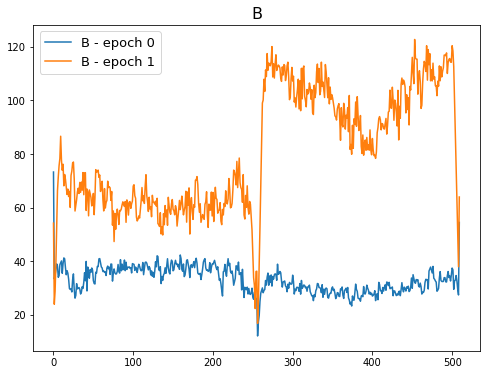

In [72]:
x_axis = np.arange(len(B_log[0]))
plt.figure(figsize=(8,6))
for i in range(n_epochs):
    B = B_log[i]
    plt.plot(x_axis, B, label='B - epoch %d'%i)
plt.legend(fontsize=13)
plt.title("B", fontsize=16)
plt.show()

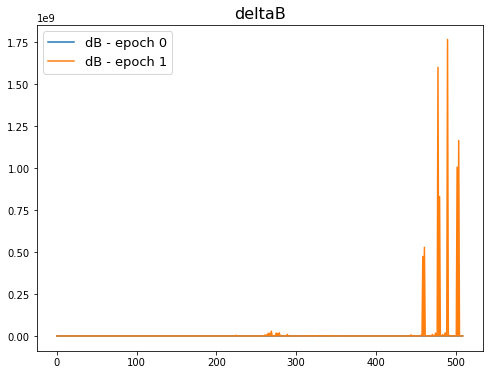

In [73]:
x_axis = np.arange(len(B_log[0]))
plt.figure(figsize=(8,6))
for i in range(n_epochs):
    dB = dB_log[i]
    plt.plot(x_axis, dB, label='dB - epoch %d'%i)
plt.legend(fontsize=13)
plt.title("deltaB", fontsize=16)
plt.show()

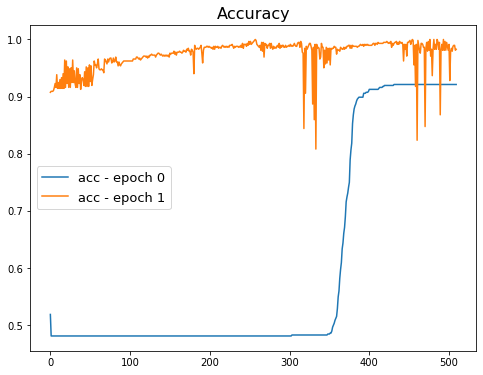

In [74]:
x_axis = np.arange(len(B_log[0]))
plt.figure(figsize=(8,6))
for i in range(n_epochs):
    plt.plot(x_axis, acc_log[i], label='acc - epoch %d'%i)
plt.legend(fontsize=13)
plt.title("Accuracy", fontsize=16)
plt.show()

# Time profiling

In [ ]:
import time

## Scaling in the number of samples

In [ ]:
n_samples = [1000*i**2 for i in range(1,9)]
print("Number of samples tried: \n", n_samples)

# keep them fixed
linear_dim = 5
M = 20

In [ ]:
times_n_samples = []
for n in n_samples:
    print("Testing with %d samples..."%n)
    (data, label) = gen.create_dataset(n, sigma=0.7)
    batch_size = {'train_batch_size':16, 'val_batch_size':128, 'test_batch_size':128}
    train_loader, val_loader, test_loader = prepare_dataset(data, label, 0.8, 0.2, **batch_size)
    
    # independent from the number of samples
    net = tn.Network(N=linear_dim**2, M=M, L=2)
    
    start = time.time()
    train_acc, val_acc = net.train(train_loader, val_loader, lr = 0.5, n_epochs = 1, print_freq=1)
    dt = time.time() - start
    print("Time for 1 epoch: %.2f s \n"%dt)
    times_n_samples.append(dt)

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(n_samples, times_n_samples, '-o', label='M = %d \nlinear dim = %d'%(M,linear_dim))
plt.xlabel("Number of samples", fontsize=16)
plt.ylabel("Time for one epoch [s]", fontsize=16)
plt.title(r"Training time vs $n_{samples}$", fontsize=16)
plt.legend(fontsize=13)
plt.show()

## Scaling in the number of pixels

In [ ]:
linear_dims = np.arange(4,29,4)
print("Linear dimensions tested: \n", linear_dims)

# keep them fixed
n_samples = 1000
M = 20

In [ ]:
times_linear_dims = []
for linear_dim in linear_dims:
    print("Testing with %d x %d images..."%(linear_dim,linear_dim))
    (data, label) = gen.create_dataset(n_samples, sigma=0.7, linear_dim = linear_dim)
    batch_size = {'train_batch_size':16, 'val_batch_size':128, 'test_batch_size':128}
    train_loader, val_loader, test_loader = prepare_dataset(data, label, 0.8, 0.2, **batch_size)
    
    # independent from the number of samples
    net = tn.Network(N=linear_dim**2, M=M, L=2)
    
    start = time.time()
    train_acc, val_acc = net.train(train_loader, val_loader, lr = 0.5, n_epochs = 1, print_freq=1)
    dt = time.time() - start
    print("Time for 1 epoch: %.2f s \n"%dt)
    times_linear_dims.append(dt)

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(linear_dims**2, times_linear_dims, '-o', label='M = %d \nnum samples = %d'%(M,n_samples))
plt.xlabel("Number of pixels", fontsize=16)
plt.ylabel("Time for one epoch [s]", fontsize=16)
plt.title(r"Training time vs $n_{pixels}$", fontsize=16)
plt.legend(fontsize=13)
plt.show()

## Scaling in the bond dimension

In [ ]:
Ms = [10*i for i in range(1,11)]
print("Bond dimensions tested: \n", Ms)

# keep them fixed
n_samples = 1000
linear_dim = 5

In [ ]:
times_bond_dims = []
for M in Ms:
    print("Testing with bond dimension %d..."%M)
    (data, label) = gen.create_dataset(n_samples, sigma=0.7)
    batch_size = {'train_batch_size':16, 'val_batch_size':128, 'test_batch_size':128}
    train_loader, val_loader, test_loader = prepare_dataset(data, label, 0.8, 0.2, **batch_size)
    
    # independent from the number of samples
    net = tn.Network(N=linear_dim**2, M=M, L=2)
    
    start = time.time()
    train_acc, val_acc = net.train(train_loader, val_loader, lr = 0.5, n_epochs = 1, print_freq=1)
    dt = time.time() - start
    print("Time for 1 epoch: %.2f s \n"%dt)
    times_bond_dims.append(dt)

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(Ms, times_bond_dims, '-o', label='linear dim = %d \nnum samples = %d'%(linear_dim,n_samples))
plt.xlabel("Bond dimension", fontsize=16)
plt.ylabel("Time for one epoch [s]", fontsize=16)
plt.title("Training time vs bond dimension", fontsize=16)
plt.legend(fontsize=13)
plt.show()

## Weight initialization

**Objective:** study what is the dependence in the output magnitude of the various dimensions so that we can choose how to normalize the matrices A during initialization.

**Parameters:**
* Number of pixels N
* Bond dimension M
* Batch size B
* Embedding dimension D (fixed to 2)

Only the first 3 will be inquired.

**Methodology:** Use random input in [0,1] and random initialization in [0,1] for different dimensions and look at the absolute value of the output (take the output among the L with the highest absolute value).

In [ ]:
from importlib import reload
reload(tn)

### Dependence on the number of pixels N

In [ ]:
linear_dims = np.arange(4,16)
print("Linear dimensions tested: \n", linear_dims)

# keep them fixed
n_samples = 1000
M = 20

In [ ]:
magnitude_linear_dims = []
for linear_dim in linear_dims:
    print("Testing with %d x %d images..."%(linear_dim,linear_dim))
    (data, label) = gen.create_dataset(n_samples, sigma=0.7, linear_dim = linear_dim)
    batch_size = {'train_batch_size':16, 'val_batch_size':128, 'test_batch_size':128}
    train_loader, val_loader, test_loader = prepare_dataset(data, label, 0.8, 0.2, **batch_size)
    
    # independent from the number of samples
    net = tn.Network(N=linear_dim**2, M=M, L=2)
    
    batch = next(iter(train_loader))
    X = np.array([batch[i][0] for i in range(len(batch))])
    f = net.forward(X)
    f_max = np.abs(f.elem).max()
    magnitude_linear_dims.append(f_max)

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
magnitude_linear_dims

In [ ]:
Ns = linear_dims**2
y = np.log10(magnitude_linear_dims)
X = Ns.reshape(-1,1)
reg = LinearRegression().fit(X, y)
plt.figure(figsize=(8,6))
plt.plot(Ns, y, label = 'data')
plt.plot(Ns, reg.predict(X), label = 'slope = %.2f'%reg.coef_)
plt.ylabel(r'$log_{10}(f_{max})$', fontsize = 16)
plt.xlabel('Number of pixels N', fontsize = 16)
plt.legend(fontsize=13)
plt.show()

As we can see the dependence on N is exponential, meaning that we can have an exponential suppression (or divergence) if the network is not accurately initialized.

### Isolating dependence C(N)

In [ ]:
y_scaled = y - Ns*np.log10(M)
X = Ns.reshape(-1,1)
reg_C = LinearRegression().fit(X, y_scaled)
plt.figure(figsize=(8,6))
plt.plot(Ns, y_scaled, label = 'data')
plt.plot(Ns, reg_C.predict(X), label = 'slope = %.2f'%reg_C.coef_)
plt.ylabel(r'$log_{10}(f_{max})$', fontsize = 16)
plt.xlabel('Number of pixels N', fontsize = 16)
plt.legend(fontsize=13)
plt.show()

In [ ]:
1/(10**(-0.18))

### Bond dimension M

In [ ]:
Ms = [5*i for i in range(1,21)]
print("Bond dimensions tested: \n", Ms)

# keep them fixed
n_samples = 1000
linear_dim = 5

In [ ]:
magnitude_bond_dims = []
for M in Ms:
    print("Testing with bond dimension %d..."%M)
    (data, label) = gen.create_dataset(n_samples, sigma=0.7, linear_dim=linear_dim)
    batch_size = {'train_batch_size':16, 'val_batch_size':128, 'test_batch_size':128}
    train_loader, val_loader, test_loader = prepare_dataset(data, label, 0.8, 0.2, **batch_size)
    
    # independent from the number of samples
    net = tn.Network(N=linear_dim**2, M=M, L=2)
    
    batch = next(iter(train_loader))
    X = np.array([batch[i][0] for i in range(len(batch))])
    f = net.forward(X)
    f_max = np.abs(f.elem).max()
    magnitude_bond_dims.append(f_max)

In [ ]:
y = np.log10(magnitude_bond_dims)
X = np.log10(np.array(Ms)).reshape(-1,1)
reg_M = LinearRegression().fit(X, y)
plt.figure(figsize=(8,6))
plt.plot(X, y, label = 'data')
plt.plot(X, reg_M.predict(X), label = 'slope = %.3f'%reg_M.coef_)
plt.ylabel(r'$log_{10}(f_{max})$', fontsize = 16)
plt.xlabel(r'Bond dimension $log_{10}(M)$', fontsize = 16)
plt.legend(fontsize=13)
plt.show()

In [ ]:
print(10**reg_M.intercept_)

The output magnitude has a power law dependence on the bond dimension. Notice how the slope is equal to N.
This makes sense since we already know that f is exponential in N. Now we also can approximate the scaling of the f as:
$$f \approx C(N)*M^N$$

### Batch dimension B

In [ ]:
M = 20
n_samples = 1000
linear_dim = 5

train_batch_sizes = np.array([2**i for i in range(1,10)])

In [ ]:
magnitude_batch_size = []
for B in train_batch_sizes:
    (data, label) = gen.create_dataset(n_samples, sigma=0.7, linear_dim = linear_dim)
    batch_size = {'train_batch_size': int(B), 'val_batch_size':128, 'test_batch_size':128}
    train_loader, val_loader, test_loader = prepare_dataset(data, label, 0.8, 0.2, **batch_size)
    
    # independent from the number of samples
    net = tn.Network(N=linear_dim**2, M=M, L=2)
    
    batch = next(iter(train_loader))
    X = np.array([batch[i][0] for i in range(len(batch))])
    f = net.forward(X)
    f_max = np.abs(f.elem).max()
    magnitude_batch_size.append(f_max)

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(train_batch_sizes, magnitude_batch_size, label = 'data')
plt.ylabel(r'$f_{max}$', fontsize = 16)
plt.xlabel('Batch size B', fontsize = 16)
plt.legend(fontsize=13)
plt.show()

No clear dependence emerges on the batch size.

### Conclusion on initialization

The simplest and most reliable initialization is the one that takes into account the number of pixels given as input and disregards all the rest. However remains the problem of choosing the factor with which the weights should be divided. To find an exact factor a priori is not immediate and is also a risky procedure, hence it's better to devise an empirical method to do so.



In [ ]:
linear_dim = 5
n_samples = 1000
M = 10

In [ ]:
reload(tn)

In [ ]:
Cs = np.arange(1,21)
(data, label) = gen.create_dataset(n_samples, sigma=0.7, linear_dim = linear_dim)
batch_size = {'train_batch_size':16, 'val_batch_size':128, 'test_batch_size':128}
train_loader, val_loader, test_loader = prepare_dataset(data, label, 0.8, 0.2, **batch_size)
batch = next(iter(train_loader))
X = np.array([batch[i][0] for i in range(len(batch))])

magnitude_C = []
for C in Cs:
    
    net = tn.Network(N=linear_dim**2, M=M, L=2, normalize=False)
    
    for i in range(net.N):
        net.As[i].elem *= C
    
    f = net.forward(X)
    f_max = np.abs(f.elem).max()
    print('f_max: ', f_max)
    magnitude_C.append(f_max)

In [ ]:
plt.figure(figsize=(8,6))
X = np.log10(Cs).reshape(-1,1)
y = np.log10(np.array(magnitude_C))
y = y/y[0]
reg_scale = LinearRegression().fit(X, y)
plt.plot(X, y, label='data')
plt.plot(X, reg_scale.predict(X), label = 'slope = %.2f\nintercept = %.2f'%(reg_scale.coef_,reg_scale.intercept_))
plt.ylabel(r'$log_{10}(f_{max})$', fontsize = 16)
plt.xlabel(r'Scaling factor $log_{10}(C)$', fontsize = 16)
plt.legend(fontsize=13)
plt.show()

In [ ]:
Ms = np.array([5*i for i in range(1,21)])
Cs = np.arange(1,21)
(data, label) = gen.create_dataset(n_samples, sigma=0.7, linear_dim = linear_dim)
batch_size = {'train_batch_size':16, 'val_batch_size':128, 'test_batch_size':128}
train_loader, val_loader, test_loader = prepare_dataset(data, label, 0.8, 0.2, **batch_size)
batch = next(iter(train_loader))
X = np.array([batch[i][0] for i in range(len(batch))])

magnitude_C_M = []
for M in Ms:
    magnitude_C = []
    for C in Cs:

        net = tn.Network(N=linear_dim**2, M=M, L=2, normalize=False)

        for i in range(net.N):
            net.As[i].elem *= C

        f = net.forward(X)
        f_max = np.abs(f.elem).max()
        magnitude_C.append(f_max)
        
    magnitude_C = np.array(magnitude_C)
    magnitude_C_M.append(magnitude_C)
    
magnitude_C_M = np.array(magnitude_C_M)

In [ ]:
magnitude_C_M.shape

In [ ]:
alphas = []
for i,M in enumerate(Ms):
    X = np.log10(Cs).reshape(-1,1)
    y = np.log10(np.array(magnitude_C_M[i,:]))
    y = y/y[0]
    reg = LinearRegression().fit(X, y)
    alphas.append(reg.coef_)
alphas = np.array(alphas)

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(Ms, alphas)
plt.xlabel('Bond dimension M', fontsize=16)
plt.ylabel(r'$\alpha$ coefficient', fontsize=16)
plt.show()

In [ ]:
reload(tn)

In [ ]:
linear_dims = np.arange(4,29,4)
print("Linear dimensions tested: \n", linear_dims)

# keep them fixed
n_samples = 1000
M = 20

In [ ]:
magnitude_linear_dims = []
for linear_dim in linear_dims:
    print("Testing with %d x %d images..."%(linear_dim,linear_dim))
    (data, label) = gen.create_dataset(n_samples, sigma=0.7, linear_dim = linear_dim)
    batch_size = {'train_batch_size':16, 'val_batch_size':128, 'test_batch_size':128}
    train_loader, val_loader, test_loader = prepare_dataset(data, label, 0.8, 0.2, **batch_size)
    
    # independent from the number of samples
    net = tn.Network(N=linear_dim**2, M=M, L=2, normalize=True)
    
    batch = next(iter(train_loader))
    X = np.array([batch[i][0] for i in range(len(batch))])
    f = net.forward(X)
    f_max = np.abs(f.elem).max()
    magnitude_linear_dims.append(f_max)

In [ ]:
u = np.random.random(10000)
x = np.cos(np.pi/2*u)
x.mean()

In [ ]:
magnitude_linear_dims

In [ ]:
Ns = linear_dims**2
y = np.log10(magnitude_linear_dims)
X = Ns.reshape(-1,1)
reg = LinearRegression().fit(X, y)
plt.figure(figsize=(8,6))
plt.plot(Ns, y, label = 'data')
plt.plot(Ns, reg.predict(X), label = 'slope = %.2f'%reg.coef_)
plt.ylabel(r'$log_{10}(f_{max})$', fontsize = 16)
plt.xlabel('Number of pixels N', fontsize = 16)
plt.legend(fontsize=13)
plt.show()

### Gradient clipping
**Idea**: 

# MNIST dataset

In [84]:
import skimage.measure

def pooling(X):
    X = skimage.measure.block_reduce(X, (1,2,2), np.max)
    return X

In [87]:
MNIST_data = gen.get_MNIST_dataset(data_root_dir = './datasets', download=False)
train_data, train_labels, test_data, test_labels = MNIST_data
data = np.concatenate((train_data,test_data))[:5000]
data = pooling(data)
B = 3328
labels = np.concatenate((train_labels,test_labels))[:5000]
batch_size = {'train_batch_size':B, 'val_batch_size':128, 'test_batch_size':128}
train_loader, val_loader, test_loader = prepare_dataset(data, labels, 6/7, 0.2, **batch_size)
print("Number of batches in training set: ", len(train_loader))
print("Number of batches in validation set: ", len(val_loader))
print("Number of batches in test set: ", len(test_loader))

Number of batches in training set:  1
Number of batches in validation set:  6
Number of batches in test set:  6


In [88]:
reload(tn)

<module 'TensorNetwork' from '/home/nicola/Nicola_unipd/QuintoAnno/Quantum Information/TensorNetworkForML/TensorNetwork/TensorNetwork.py'>

In [92]:
calibration_batch = next(iter(val_loader))
x_calibration = np.array([calibration_batch[i][0] for i in range(len(calibration_batch))])

In [93]:
net = tn.Network(N=196, M=10, L=10, normalize=True, calibration_X=x_calibration)#, sigma=0.23)

Normalizing weights...
Scaling factor: 6.40
Calibrating weights on dataset...
f_max for random input of 128 samples :  1.5106389770442598e-21
Rescaling factor for calibration:  0.7830170665432787
f_max for random input of 128 samples (after):  1.0000000000000087


In [94]:
n_epochs = 2
train_acc, val_acc, B_log, dB_log, acc_log = net.train(train_loader, val_loader, lr = 0.01, n_epochs = n_epochs, print_freq=1)


right sweep step  0
phi (TX):  3328.0
right:  12490.47758807292
Accuracy (before optim.):  0.10757211538461539
f:  11766.907090697177
f:  16676.20983859702
DeltaB (before GC):  13022.153163029507
DeltaB (after GC):  372.2011643694036
B: 	 372.20116436940367
Accuracy (after optim.):  0.10757211538461539

right sweep step  1
phi (TX):  3328.0
circle:  9283.2995007874
Accuracy (before optim.):  0.10757211538461539
f:  11285.974937761144
f:  16674.72234981966
DeltaB (before GC):  9319.965008358326
DeltaB (after GC):  192.1987398319137
B: 	 192.1987398319137
Accuracy (after optim.):  0.10096153846153846

right sweep step  2
phi (TX):  3328.0
circle:  10257.005016024434
Accuracy (before optim.):  0.10096153846153846
f:  10457.453683270669
f:  16672.143013993238
DeltaB (before GC):  9611.096390159506
DeltaB (after GC):  240.33900367584263
B: 	 240.33900367584266
Accuracy (after optim.):  0.10096153846153846

right sweep step  3
phi (TX):  3328.0
circle:  10657.0990572671
Accuracy (before opt

Accuracy (after optim.):  0.1024639423076923

right sweep step  27
phi (TX):  3328.0
circle:  903.7503654337098
Accuracy (before optim.):  0.1024639423076923
f:  438.86174736429797
f:  16639.697988161282
DeltaB (before GC):  77.99283324715405
DeltaB (after GC):  77.99283324715405
B: 	 303.4184970677612
Accuracy (after optim.):  0.1024639423076923

right sweep step  28
phi (TX):  3328.0
circle:  911.2626045371871
Accuracy (before optim.):  0.1024639423076923
f:  428.75832794389237
f:  16639.605203819017
DeltaB (before GC):  79.5732248673084
DeltaB (after GC):  79.5732248673084
B: 	 296.4820732780287
Accuracy (after optim.):  0.10276442307692307

right sweep step  29
phi (TX):  3328.0
circle:  840.1629673694105
Accuracy (before optim.):  0.10276442307692307
f:  417.5127115145931
f:  16639.52667531352
DeltaB (before GC):  73.6901997258387
DeltaB (after GC):  73.6901997258387
B: 	 297.19148379725755
Accuracy (after optim.):  0.10276442307692307

right sweep step  30
phi (TX):  3328.0000000

Accuracy (after optim.):  0.10216346153846154

right sweep step  54
phi (TX):  3328.000000000002
circle:  906.2787683055773
Accuracy (before optim.):  0.10216346153846154
f:  443.34320184265533
f:  16637.937963852117
DeltaB (before GC):  57.96336410477362
DeltaB (after GC):  57.96336410477362
B: 	 295.1868837636672
Accuracy (after optim.):  0.10186298076923077

right sweep step  55
phi (TX):  3328.0
circle:  876.6949087883434
Accuracy (before optim.):  0.10186298076923077
f:  447.4340101544172
f:  16637.908079354624
DeltaB (before GC):  54.276974198401646
DeltaB (after GC):  54.276974198401646
B: 	 295.4822445515174
Accuracy (after optim.):  0.10216346153846154

right sweep step  56
phi (TX):  3328.0
circle:  972.8258482930352
Accuracy (before optim.):  0.10216346153846154
f:  452.36100488900524
f:  16637.8524093506
DeltaB (before GC):  57.11781722864707
DeltaB (after GC):  57.11781722864707
B: 	 277.12469267119445
Accuracy (after optim.):  0.10216346153846154

right sweep step  57
phi

Accuracy (after optim.):  0.0946514423076923

right sweep step  81
phi (TX):  3328.000000000006
circle:  1276.4449011144227
Accuracy (before optim.):  0.0946514423076923
f:  522.5898518785151
f:  16635.887789222877
DeltaB (before GC):  91.3378994587216
DeltaB (after GC):  91.3378994587216
B: 	 341.05200843075454
Accuracy (after optim.):  0.09705528846153846

right sweep step  82
phi (TX):  3328.0000000000005
circle:  1306.5144123234227
Accuracy (before optim.):  0.09705528846153846
f:  529.0026216157817
f:  16635.812964181332
DeltaB (before GC):  71.79685605333087
DeltaB (after GC):  71.79685605333087
B: 	 354.3972219201829
Accuracy (after optim.):  0.09405048076923077

right sweep step  83
phi (TX):  3328.0
circle:  1237.0061922418479
Accuracy (before optim.):  0.09405048076923077
f:  536.2743098103952
f:  16635.739191697856
DeltaB (before GC):  61.84290682655863
DeltaB (after GC):  61.84290682655863
B: 	 341.4198272626316
Accuracy (after optim.):  0.09435096153846154

right sweep ste

Accuracy (after optim.):  0.09585336538461539

right sweep step  107
phi (TX):  3328.000000000026
circle:  1945.3230853396806
Accuracy (before optim.):  0.09585336538461539
f:  699.6848133533717
f:  16633.021432380945
DeltaB (before GC):  206.62171917673476
DeltaB (after GC):  206.62171917673476
B: 	 324.2124046846692
Accuracy (after optim.):  0.09555288461538461

right sweep step  108
phi (TX):  3328.0000000000146
circle:  2128.370510913634
Accuracy (before optim.):  0.09555288461538461
f:  717.9592283564298
f:  16632.81689119173
DeltaB (before GC):  203.87710089943158
DeltaB (after GC):  203.87710089943158
B: 	 304.9253090516782
Accuracy (after optim.):  0.09735576923076923

right sweep step  109
phi (TX):  3328.0000000000055
circle:  2033.9175864414342
Accuracy (before optim.):  0.09735576923076923
f:  740.0762053932348
f:  16632.571484688502
DeltaB (before GC):  150.7295746075749
DeltaB (after GC):  150.7295746075749
B: 	 313.80181110236595
Accuracy (after optim.):  0.0985576923076

Accuracy (after optim.):  0.10426682692307693

right sweep step  134
phi (TX):  3328.0000000000314
circle:  3128.9721735893368
Accuracy (before optim.):  0.10426682692307693
f:  1263.3259296269594
f:  16624.7630358274
DeltaB (before GC):  535.2958548965365
DeltaB (after GC):  318.05129278533235
B: 	 318.05129278533235
Accuracy (after optim.):  0.10366586538461539

right sweep step  135
phi (TX):  3328.0000000000227
circle:  3262.167147257723
Accuracy (before optim.):  0.10366586538461539
f:  1292.7906029817211
f:  16624.02318677122
DeltaB (before GC):  426.64802863838906
DeltaB (after GC):  323.8136007414463
B: 	 323.8136007414463
Accuracy (after optim.):  0.10787259615384616

right sweep step  136
phi (TX):  3328.0000000000127
circle:  3432.7102408495552
Accuracy (before optim.):  0.10787259615384616
f:  1355.979356609491
f:  16623.037007136507
DeltaB (before GC):  329.89447581696777
DeltaB (after GC):  328.0619511064116
B: 	 328.0619511064116
Accuracy (after optim.):  0.1078725961538

Accuracy (after optim.):  0.12830528846153846

right sweep step  160
phi (TX):  3328.0000000000314
circle:  4502.627677572515
Accuracy (before optim.):  0.12830528846153846
f:  2349.7868716105963
f:  16601.69932736576
DeltaB (before GC):  522.9101432512437
DeltaB (after GC):  318.6716513753412
B: 	 318.67165137534124
Accuracy (after optim.):  0.12740384615384615

right sweep step  161
phi (TX):  3328.000000000027
circle:  4397.607384452263
Accuracy (before optim.):  0.12740384615384615
f:  2403.183603727463
f:  16600.452738780066
DeltaB (before GC):  434.58691788782073
DeltaB (after GC):  324.0552360258216
B: 	 324.0552360258216
Accuracy (after optim.):  0.12620192307692307

right sweep step  162
phi (TX):  3328.000000000018
circle:  4398.804844612302
Accuracy (before optim.):  0.12620192307692307
f:  2474.7619729154153
f:  16598.73456460406
DeltaB (before GC):  374.929928783468
DeltaB (after GC):  330.87595109363303
B: 	 330.87595109363303
Accuracy (after optim.):  0.12980769230769232

Accuracy (after optim.):  0.14603365384615385

right sweep step  187
phi (TX):  3328.0000000000027
circle:  5231.897421495279
Accuracy (before optim.):  0.14603365384615385
f:  3235.471849692016
f:  16564.860107981796
DeltaB (before GC):  414.46312565475716
DeltaB (after GC):  382.2458008595773
B: 	 382.2458008595773
Accuracy (after optim.):  0.14873798076923078

right sweep step  188
phi (TX):  3328.000000000002
circle:  5519.810570962728
Accuracy (before optim.):  0.14873798076923078
f:  3225.711704775648
f:  16563.930101013055
DeltaB (before GC):  407.0854076336328
DeltaB (after GC):  346.9266414586709
B: 	 346.9266414586709
Accuracy (after optim.):  0.14813701923076922

right sweep step  189
phi (TX):  3328.000000000002
circle:  5453.706974721644
Accuracy (before optim.):  0.14813701923076922
f:  3279.7070868516357
f:  16562.067842474084
DeltaB (before GC):  381.38373093167206
DeltaB (after GC):  358.1096961628082
B: 	 358.1096961628082
Accuracy (after optim.):  0.14603365384615385

Accuracy (after optim.):  0.1424278846153846

left sweep step  173
Accuracy (before optim.):  0.1424278846153846
f:  3729.8212315416467
f:  16541.546770242367
deltaB (before GC):  5755.526059084667
deltaB (after GC):  276.8972554137308
B: 	 276.8972554137309
Accuracy (after optim.):  0.13431490384615385

left sweep step  172
Accuracy (before optim.):  0.13431490384615385
f:  3865.8949379979495
f:  16548.323900098283
deltaB (before GC):  7709.231090576665
deltaB (after GC):  276.5626983062691
B: 	 276.56269830626917
Accuracy (after optim.):  0.13521634615384615

left sweep step  171
Accuracy (before optim.):  0.13521634615384615
f:  4925.287873190943
f:  16523.491143092895
deltaB (before GC):  8017.41446534422
deltaB (after GC):  289.82569738194314
B: 	 289.82569738194314
Accuracy (after optim.):  0.12289663461538461

left sweep step  170
Accuracy (before optim.):  0.12289663461538461
f:  3385.500401070226
f:  16573.598678555092
deltaB (before GC):  8810.795152786295
deltaB (after GC): 

Accuracy (after optim.):  0.140625

left sweep step  141
Accuracy (before optim.):  0.140625
f:  4101.935131803977
f:  16562.056782273423
deltaB (before GC):  12486.016216681273
deltaB (after GC):  293.12662975749106
B: 	 293.126629757491
Accuracy (after optim.):  0.12109375

left sweep step  140
Accuracy (before optim.):  0.12109375
f:  5795.708539984932
f:  16521.680534599676
deltaB (before GC):  16190.96898187375
deltaB (after GC):  292.581932417379
B: 	 292.581932417379
Accuracy (after optim.):  0.1349158653846154

left sweep step  139
Accuracy (before optim.):  0.1349158653846154
f:  3982.7571825875916
f:  16553.281636828033
deltaB (before GC):  12234.05302526298
deltaB (after GC):  284.6088872022819
B: 	 284.60888720228195
Accuracy (after optim.):  0.12139423076923077

left sweep step  138
Accuracy (before optim.):  0.12139423076923077
f:  4790.56106303828
f:  16529.252744284102
deltaB (before GC):  16925.110263570532
deltaB (after GC):  293.39148666671804
B: 	 293.39148666671804

Accuracy (after optim.):  0.13581730769230768

left sweep step  109
Accuracy (before optim.):  0.13581730769230768
f:  3482.733039231783
f:  16546.53763462246
deltaB (before GC):  11039.974609924606
deltaB (after GC):  286.33279803272114
B: 	 286.33279803272114
Accuracy (after optim.):  0.1201923076923077

left sweep step  108
Accuracy (before optim.):  0.1201923076923077
f:  4429.914084850226
f:  16511.643311309454
deltaB (before GC):  7638.524212891067
deltaB (after GC):  296.80020531863323
B: 	 296.80020531863323
Accuracy (after optim.):  0.14963942307692307

left sweep step  107
Accuracy (before optim.):  0.14963942307692307
f:  3304.956981011098
f:  16532.794934232494
deltaB (before GC):  6171.762433415954
deltaB (after GC):  299.33186202856217
B: 	 299.3318620285622
Accuracy (after optim.):  0.1541466346153846

left sweep step  106
Accuracy (before optim.):  0.1541466346153846
f:  3486.4016040640786
f:  16522.709571103667
deltaB (before GC):  4825.67795518122
deltaB (after GC):  

Accuracy (after optim.):  0.14543269230769232

left sweep step  77
Accuracy (before optim.):  0.14543269230769232
f:  3988.987034123548
f:  16488.42221402712
deltaB (before GC):  4113.502237025806
deltaB (after GC):  294.80069749485017
B: 	 294.80069749485017
Accuracy (after optim.):  0.12590144230769232

left sweep step  76
Accuracy (before optim.):  0.12590144230769232
f:  4623.96222360874
f:  16477.162936879566
deltaB (before GC):  5575.110824748557
deltaB (after GC):  301.8599558397175
B: 	 301.8599558397175
Accuracy (after optim.):  0.14423076923076922

left sweep step  75
Accuracy (before optim.):  0.14423076923076922
f:  4010.8338678356017
f:  16493.142181760795
deltaB (before GC):  5081.538242305702
deltaB (after GC):  299.42603657657673
B: 	 299.42603657657673
Accuracy (after optim.):  0.10667067307692307

left sweep step  74
Accuracy (before optim.):  0.10667067307692307
f:  4813.360850598738
f:  16485.87972879322
deltaB (before GC):  11519.936992197978
deltaB (after GC):  31

Accuracy (after optim.):  0.11989182692307693

left sweep step  45
Accuracy (before optim.):  0.11989182692307693
f:  7636.704126162304
f:  16455.55108846896
deltaB (before GC):  20046.416701402937
deltaB (after GC):  294.6809039844515
B: 	 294.68090398445156
Accuracy (after optim.):  0.10366586538461539

left sweep step  44
Accuracy (before optim.):  0.10366586538461539
f:  6447.970105710872
f:  16437.503139791577
deltaB (before GC):  9118.984204113374
deltaB (after GC):  291.94736181146334
B: 	 291.94736181146334
Accuracy (after optim.):  0.10967548076923077

left sweep step  43
Accuracy (before optim.):  0.10967548076923077
f:  9180.687367932404
f:  16472.595314164533
deltaB (before GC):  27590.063007335673
deltaB (after GC):  301.55246747872843
B: 	 301.5524674787284
Accuracy (after optim.):  0.10817307692307693

left sweep step  42
Accuracy (before optim.):  0.10817307692307693
f:  5940.60933466037
f:  16437.483844483482
deltaB (before GC):  8120.076866358897
deltaB (after GC):  2

Accuracy (after optim.):  0.11298076923076923

left sweep step  13
Accuracy (before optim.):  0.11298076923076923
f:  21126.217333699937
f:  16429.855525366376
deltaB (before GC):  143523.08184482425
deltaB (after GC):  327.57360719963594
B: 	 327.57360719963594
Accuracy (after optim.):  0.1015625

left sweep step  12
Accuracy (before optim.):  0.1015625
f:  23161.558147711756
f:  16468.82008898507
deltaB (before GC):  199728.58953965444
deltaB (after GC):  333.75392662351607
B: 	 333.7539266235161
Accuracy (after optim.):  0.11087740384615384

left sweep step  11
Accuracy (before optim.):  0.11087740384615384
f:  35170.25997800546
f:  16435.97249897998
deltaB (before GC):  413564.8001652219
deltaB (after GC):  330.71708905580556
B: 	 330.71708905580556
Accuracy (after optim.):  0.10606971153846154

left sweep step  10
Accuracy (before optim.):  0.10606971153846154
f:  38068.19585489251
f:  16536.69097612902
deltaB (before GC):  557510.3307326308
deltaB (after GC):  318.3285814992901
B

Accuracy (after optim.):  0.11268028846153846

right sweep step  16
phi (TX):  3328.0
circle:  332398.9223623979
Accuracy (before optim.):  0.11268028846153846
f:  60069.387496577445
f:  16347.089174292323
DeltaB (before GC):  1131558.042778518
DeltaB (after GC):  267.66228109322225
B: 	 267.6622810932223
Accuracy (after optim.):  0.10216346153846154

right sweep step  17
phi (TX):  3328.0
circle:  261704.0012016938
Accuracy (before optim.):  0.10216346153846154
f:  18277.158834085967
f:  16083.228742659212
DeltaB (before GC):  132249.18548827208
DeltaB (after GC):  248.7745245086577
B: 	 248.77452450865766
Accuracy (after optim.):  0.11598557692307693

right sweep step  18
phi (TX):  3328.0000000000014
circle:  329413.5618424479
Accuracy (before optim.):  0.11598557692307693
f:  62390.24756221481
f:  16369.33098582704
DeltaB (before GC):  1125568.637929245
DeltaB (after GC):  252.73411836624018
B: 	 252.73411836624018
Accuracy (after optim.):  0.09975961538461539

right sweep step  19

Accuracy (after optim.):  0.10787259615384616

right sweep step  43
phi (TX):  3328.0000000000014
circle:  147419.64947658367
Accuracy (before optim.):  0.10787259615384616
f:  17514.100139361904
f:  16358.43788282244
DeltaB (before GC):  188253.90161335462
DeltaB (after GC):  292.94087537526184
B: 	 292.9408753752619
Accuracy (after optim.):  0.10426682692307693

right sweep step  44
phi (TX):  3328.0000000000045
circle:  232127.83421194306
Accuracy (before optim.):  0.10426682692307693
f:  37019.69289280766
f:  16326.287321742651
DeltaB (before GC):  587623.5359641423
DeltaB (after GC):  295.8026256869196
B: 	 295.80262568691955
Accuracy (after optim.):  0.09705528846153846

right sweep step  45
phi (TX):  3328.0000000000123
circle:  189850.79517670211
Accuracy (before optim.):  0.09705528846153846
f:  13073.152525533573
f:  16301.47932893136
DeltaB (before GC):  137393.84160333444
DeltaB (after GC):  282.6321815759292
B: 	 282.6321815759292
Accuracy (after optim.):  0.11087740384615

Accuracy (after optim.):  0.1045673076923077

right sweep step  69
phi (TX):  3328.0
circle:  190331.52803732714
Accuracy (before optim.):  0.1045673076923077
f:  21303.205668627557
f:  16471.37051496623
DeltaB (before GC):  317874.48338890023
DeltaB (after GC):  289.96647444810174
B: 	 289.9664744481017
Accuracy (after optim.):  0.12469951923076923

right sweep step  70
phi (TX):  3328.0
circle:  218879.1990946038
Accuracy (before optim.):  0.12469951923076923
f:  21866.21183704663
f:  16355.847564524984
DeltaB (before GC):  362415.408717592
DeltaB (after GC):  305.22760052998376
B: 	 305.2276005299837
Accuracy (after optim.):  0.10516826923076923

right sweep step  71
phi (TX):  3328.000000000002
circle:  228897.55184953052
Accuracy (before optim.):  0.10516826923076923
f:  15547.053968113838
f:  16439.003640181774
DeltaB (before GC):  285743.25746354717
DeltaB (after GC):  291.87153758429895
B: 	 291.8715375842989
Accuracy (after optim.):  0.11598557692307693

right sweep step  72
p

Accuracy (after optim.):  0.10396634615384616

right sweep step  95
phi (TX):  3328.000000000005
circle:  200708.03264479755
Accuracy (before optim.):  0.10396634615384616
f:  13935.991729246705
f:  16471.019573885867
DeltaB (before GC):  197206.78804925986
DeltaB (after GC):  278.4863069464993
B: 	 278.4863069464993
Accuracy (after optim.):  0.1171875

right sweep step  96
phi (TX):  3328.000000000001
circle:  263493.7048365815
Accuracy (before optim.):  0.1171875
f:  18328.008833302305
f:  16418.26527652949
DeltaB (before GC):  356075.25329783506
DeltaB (after GC):  285.2105356142954
B: 	 285.21053561429545
Accuracy (after optim.):  0.1024639423076923

right sweep step  97
phi (TX):  3328.0
circle:  256204.1086148425
Accuracy (before optim.):  0.1024639423076923
f:  12460.33066215779
f:  16484.043437833436
DeltaB (before GC):  243160.82360476162
DeltaB (after GC):  275.71230294026554
B: 	 275.7123029402655
Accuracy (after optim.):  0.12920673076923078

right sweep step  98
phi (TX): 

Accuracy (after optim.):  0.15234375

right sweep step  122
phi (TX):  3328.0000000000146
circle:  196566.44519824846
Accuracy (before optim.):  0.15234375
f:  8984.655779114486
f:  16450.791420591067
DeltaB (before GC):  108682.05821111995
DeltaB (after GC):  281.1564854519866
B: 	 281.15648545198667
Accuracy (after optim.):  0.11508413461538461

right sweep step  123
phi (TX):  3328.0000000000064
circle:  190911.5560196468
Accuracy (before optim.):  0.11508413461538461
f:  9465.87684555632
f:  16528.732976423114
DeltaB (before GC):  134685.08692131157
DeltaB (after GC):  267.82678215969486
B: 	 267.82678215969486
Accuracy (after optim.):  0.1310096153846154

right sweep step  124
phi (TX):  3328.0000000000014
circle:  167136.81097585298
Accuracy (before optim.):  0.1310096153846154
f:  10305.18717340534
f:  16491.240781662553
DeltaB (before GC):  125047.05945251197
DeltaB (after GC):  275.17868947151845
B: 	 275.1786894715184
Accuracy (after optim.):  0.1141826923076923

right sweep 

Accuracy (after optim.):  0.1424278846153846

right sweep step  148
phi (TX):  3328.0000000000277
circle:  159903.04146037376
Accuracy (before optim.):  0.1424278846153846
f:  4826.243350956063
f:  16540.126192723514
DeltaB (before GC):  49834.944543810365
DeltaB (after GC):  289.9944020587398
B: 	 289.99440205873975
Accuracy (after optim.):  0.14152644230769232

right sweep step  149
phi (TX):  3328.000000000017
circle:  179649.91238009534
Accuracy (before optim.):  0.14152644230769232
f:  4711.749182595018
f:  16520.331578299287
DeltaB (before GC):  44052.015884505105
DeltaB (after GC):  290.7236352915252
B: 	 290.7236352915252
Accuracy (after optim.):  0.14152644230769232

right sweep step  150
phi (TX):  3328.0000000000077
circle:  193527.45255163667
Accuracy (before optim.):  0.14152644230769232
f:  7772.21073412484
f:  16527.938540050294
DeltaB (before GC):  101127.26965344437
DeltaB (after GC):  289.90875708267225
B: 	 289.9087570826722
Accuracy (after optim.):  0.11989182692307

Accuracy (after optim.):  0.12560096153846154

right sweep step  175
phi (TX):  3328.0000000000114
circle:  150198.85111301194
Accuracy (before optim.):  0.12560096153846154
f:  5511.750530783687
f:  16562.95332413738
DeltaB (before GC):  66889.97626583082
DeltaB (after GC):  300.2679498045954
B: 	 300.2679498045954
Accuracy (after optim.):  0.12590144230769232

right sweep step  176
phi (TX):  3328.0000000000064
circle:  120132.81737617028
Accuracy (before optim.):  0.12590144230769232
f:  6043.352532169025
f:  16544.967003088837
DeltaB (before GC):  51445.845850932725
DeltaB (after GC):  295.41782013200793
B: 	 295.417820132008
Accuracy (after optim.):  0.11598557692307693

right sweep step  177
phi (TX):  3328.0000000000027
circle:  128334.91682310431
Accuracy (before optim.):  0.11598557692307693
f:  7613.162923293418
f:  16568.608534843035
DeltaB (before GC):  81864.34511642934
DeltaB (after GC):  306.49953018730423
B: 	 306.4995301873042
Accuracy (after optim.):  0.11508413461538

Accuracy (after optim.):  0.09615384615384616

left sweep step  187
Accuracy (before optim.):  0.09615384615384616
f:  10845.554091652855
f:  16486.62682651297
deltaB (before GC):  58935.924474745036
deltaB (after GC):  311.6049965708446
B: 	 311.6049965708446
Accuracy (after optim.):  0.11448317307692307

left sweep step  186
Accuracy (before optim.):  0.11448317307692307
f:  9930.992426657232
f:  16561.21883739444
deltaB (before GC):  75259.95551644635
deltaB (after GC):  283.17301782715333
B: 	 283.17301782715333
Accuracy (after optim.):  0.10126201923076923

left sweep step  185
Accuracy (before optim.):  0.10126201923076923
f:  7229.495896611215
f:  16495.236667196637
deltaB (before GC):  56704.90244229254
deltaB (after GC):  300.4540072825679
B: 	 300.4540072825679
Accuracy (after optim.):  0.12049278846153846

left sweep step  184
Accuracy (before optim.):  0.12049278846153846
f:  7495.02515863628
f:  16552.842623304005
deltaB (before GC):  82843.966601266
deltaB (after GC):  28

Accuracy (after optim.):  0.10126201923076923

left sweep step  155
Accuracy (before optim.):  0.10126201923076923
f:  7585.510427026124
f:  16500.592750735173
deltaB (before GC):  92508.37047154257
deltaB (after GC):  300.8304338972548
B: 	 300.8304338972548
Accuracy (after optim.):  0.11598557692307693

left sweep step  154
Accuracy (before optim.):  0.11598557692307693
f:  7810.206472628805
f:  16552.729824237933
deltaB (before GC):  118619.6807599049
deltaB (after GC):  301.6998626100334
B: 	 301.6998626100334
Accuracy (after optim.):  0.10366586538461539

left sweep step  153
Accuracy (before optim.):  0.10366586538461539
f:  7580.558963477614
f:  16506.60525043537
deltaB (before GC):  96107.79190189336
deltaB (after GC):  297.5056617109698
B: 	 297.5056617109698
Accuracy (after optim.):  0.11658653846153846

left sweep step  152
Accuracy (before optim.):  0.11658653846153846
f:  7814.3036113717735
f:  16548.680180326442
deltaB (before GC):  120517.85643439996
deltaB (after GC):  

Accuracy (after optim.):  0.13311298076923078

left sweep step  123
Accuracy (before optim.):  0.13311298076923078
f:  6440.648365926271
f:  16527.23364391071
deltaB (before GC):  105093.42287897853
deltaB (after GC):  283.66606993906635
B: 	 283.66606993906635
Accuracy (after optim.):  0.1307091346153846

left sweep step  122
Accuracy (before optim.):  0.1307091346153846
f:  4636.63322950763
f:  16525.151419044192
deltaB (before GC):  63645.93794419403
deltaB (after GC):  283.2427231279387
B: 	 283.24272312793863
Accuracy (after optim.):  0.1622596153846154

left sweep step  121
Accuracy (before optim.):  0.1622596153846154
f:  4790.790334150951
f:  16508.399795838086
deltaB (before GC):  63221.78753763328
deltaB (after GC):  279.75522107647737
B: 	 279.75522107647737
Accuracy (after optim.):  0.13942307692307693

left sweep step  120
Accuracy (before optim.):  0.13942307692307693
f:  3791.2726743812877
f:  16527.25685464689
deltaB (before GC):  26246.07989701794
deltaB (after GC):  2

Accuracy (after optim.):  0.12800480769230768

left sweep step  91
Accuracy (before optim.):  0.12800480769230768
f:  4393.054302027631
f:  16524.57676637883
deltaB (before GC):  39339.89301789121
deltaB (after GC):  295.6385060783348
B: 	 295.6385060783348
Accuracy (after optim.):  0.14032451923076922

left sweep step  90
Accuracy (before optim.):  0.14032451923076922
f:  4560.538941657737
f:  16516.62730718335
deltaB (before GC):  38108.58009193181
deltaB (after GC):  302.0536421301787
B: 	 302.0536421301786
Accuracy (after optim.):  0.1219951923076923

left sweep step  89
Accuracy (before optim.):  0.1219951923076923
f:  4611.78019084834
f:  16527.605805238793
deltaB (before GC):  39344.09052284374
deltaB (after GC):  287.6464343977682
B: 	 287.64643439776825
Accuracy (after optim.):  0.11268028846153846

left sweep step  88
Accuracy (before optim.):  0.11268028846153846
f:  5194.2133135462445
f:  16517.151094747474
deltaB (before GC):  53353.71692666669
deltaB (after GC):  308.6081

Accuracy (after optim.):  0.14693509615384615

left sweep step  59
Accuracy (before optim.):  0.14693509615384615
f:  8138.211441120902
f:  16505.300728346294
deltaB (before GC):  90469.78720601193
deltaB (after GC):  283.303769989755
B: 	 283.303769989755
Accuracy (after optim.):  0.09915865384615384

left sweep step  58
Accuracy (before optim.):  0.09915865384615384
f:  11343.203489890037
f:  16516.735440334956
deltaB (before GC):  145100.77709509432
deltaB (after GC):  290.9902419472592
B: 	 290.9902419472592
Accuracy (after optim.):  0.12079326923076923

left sweep step  57
Accuracy (before optim.):  0.12079326923076923
f:  10787.647631916618
f:  16513.368054704184
deltaB (before GC):  132607.3449750124
deltaB (after GC):  281.8849469573472
B: 	 281.8849469573472
Accuracy (after optim.):  0.09795673076923077

left sweep step  56
Accuracy (before optim.):  0.09795673076923077
f:  11432.299209652103
f:  16523.89862888498
deltaB (before GC):  134065.9052126797
deltaB (after GC):  290.

Accuracy (after optim.):  0.10817307692307693

left sweep step  27
Accuracy (before optim.):  0.10817307692307693
f:  23575.939889711535
f:  16546.241854430173
deltaB (before GC):  315362.27195466205
deltaB (after GC):  298.60736702900857
B: 	 298.60736702900857
Accuracy (after optim.):  0.10757211538461539

left sweep step  26
Accuracy (before optim.):  0.10757211538461539
f:  7701.576969015655
f:  16477.67669218445
deltaB (before GC):  71792.72581098917
deltaB (after GC):  286.96416639453014
B: 	 286.96416639453014
Accuracy (after optim.):  0.11688701923076923

left sweep step  25
Accuracy (before optim.):  0.11688701923076923
f:  21796.7608480275
f:  16530.658241605313
deltaB (before GC):  296129.6033797574
deltaB (after GC):  296.46978628130944
B: 	 296.4697862813095
Accuracy (after optim.):  0.11147836538461539

left sweep step  24
Accuracy (before optim.):  0.11147836538461539
f:  7198.015181007883
f:  16469.454329462806
deltaB (before GC):  74712.53299317381
deltaB (after GC):  

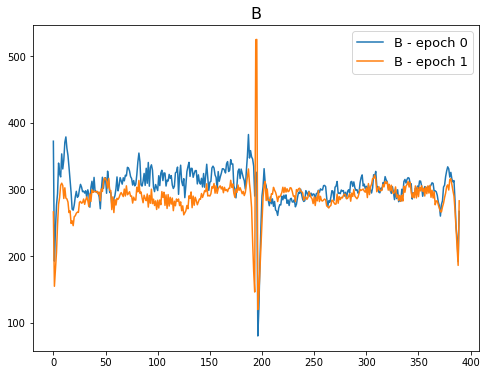

In [95]:
x_axis = np.arange(len(B_log[0]))
plt.figure(figsize=(8,6))
for i in range(n_epochs):
    B = B_log[i]
    plt.plot(x_axis, B, label='B - epoch %d'%i)
plt.legend(fontsize=13)
plt.title("B", fontsize=16)
plt.show()

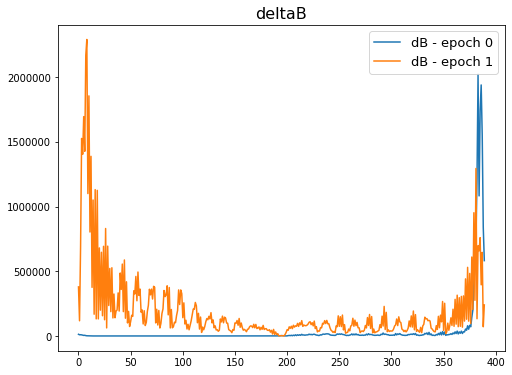

In [96]:
x_axis = np.arange(len(B_log[0]))
plt.figure(figsize=(8,6))
for i in range(n_epochs):
    dB = dB_log[i]
    plt.plot(x_axis, dB, label='dB - epoch %d'%i)
plt.legend(fontsize=13)
plt.title("deltaB", fontsize=16)
plt.show()

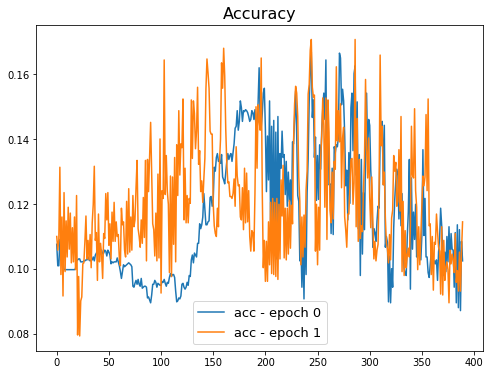

In [97]:
x_axis = np.arange(len(B_log[0]))
plt.figure(figsize=(8,6))
for i in range(n_epochs):
    plt.plot(x_axis, acc_log[i], label='acc - epoch %d'%i)
plt.legend(fontsize=13)
plt.title("Accuracy", fontsize=16)
plt.show()

In [248]:
np.exp(-7100)

0.0